<a href="https://colab.research.google.com/github/YangchenHuang/Algorithmic_Trading/blob/master/Evolution%20Strategy_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=ff394c86708c8d113d808bfcf9b4b92e76bc75cf5f2848642c1e06d2f49b56fb
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
from bayes_opt import BayesianOptimization

In [6]:
!rm -rf Algorithmic_Trading
!git clone https://github.com/YangchenHuang/Algorithmic_Trading

Cloning into 'Algorithmic_Trading'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 96 (delta 1), reused 0 (delta 0), pack-reused 90
Unpacking objects: 100% (96/96), done.


In [55]:
df = pd.read_csv('./Algorithmic_Trading/dataset/NVDA.csv')
df.head()

PERMNO      date       VOL  NUMTRD        PRC    OPENPRC
0   86580  1/3/2007  19273722   67875  24.053333  24.713333
1   86580  1/4/2007  15957279   53389  23.940000  23.966667
2   86580  1/5/2007  20729060   75741  22.440000  23.373333
3   86580  1/8/2007  10955217   43714  22.606667  22.520000
4   86580  1/9/2007  12750524   48630  22.166667  22.640000

In [0]:
data = df[['PRC', 'VOL', 'OPENPRC']].to_numpy().flatten()
data = data.tolist()
close = df['PRC'].tolist()
window_size = 30
skip = 5
l = len(close) - 1
test_size=l//2
dev_size=0

In [0]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d*3 : (t + 1)*3] if d >= 0 else -d * [data[0], data[1], data[2]] + data[0 : (t + 1)*3]
    res = []
    for i in range(n - 1):
        for j in range(3):
            if block[i*3+j]==0:
                res.append(0)
            else:
                res.append((block[(i + 1)*3+j] - block[i*3+j])/block[i*3+j])
    return np.array([res])

In [0]:
class Deep_Evolution_Strategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate, trade_train, buy, model
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.fsigma = sigma
        self.trade_train = trade_train
        self.buy = buy
        self.model = model
        self.wc = weights

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def get_weights(self):
        return self.weights

    def train(self, epoch = 100, print_every = 1):
        lasttime = time.time()
        reward_list=[]
        max_validate=0
        best_model=self.model
        for i in range(epoch):
            population = []
            rewards = np.zeros(self.population_size)
            for k in range(self.population_size):
                x = []
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                population.append(x)
            for k in range(self.population_size):
                weights_population = self._get_weight_from_population(
                    self.weights, population[k]
                )
                rewards[k] = self.reward_function(weights_population)
            e_rewards = np.exp(rewards - np.max(rewards))
            e_rewards = e_rewards / e_rewards.sum(axis=0)
            # for k in range(self.population_size):
            #     if rewards[k]>0:
            #         self.siglist[k] = np.clip(self.sigma*(rmax-rewards[k])/rran, 0.00001*self.sigma, self.sigma)
            #     if rewards[k]<=0:
            #         self.siglist[k]=self.sigma
            # print(self.siglist)
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                self.wc[index] = (
                    w
                    + self.learning_rate
                    * np.dot(A.T, e_rewards).T
                )
            now_reward=self.reward_function(self.wc)
            if i==0:
                final_reward = now_reward 
            if i>0:
                final_reward = reward_list[i-1]
            if i>0 and (self.sigma > self.fsigma/4 or now_reward > reward_list[i-1]):
                self.weights = self.wc
                final_reward = now_reward
            if i>0:
                if final_reward<=0:
                    self.sigma = self.fsigma
                if self.sigma > self.fsigma/2:
                    if final_reward>max(reward_list[max(0, i-5):i]):
                        self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.95, 0.999)
                    if final_reward<np.average(reward_list):
                        self.sigma=min(self.sigma*np.clip(np.average(reward_list)/(np.average(reward_list)-final_reward+1e-10),1.001, 1.05),self.fsigma)
                elif self.sigma > self.fsigma/4:
                    if final_reward>max(reward_list[max(0, i-10):i]):
                        self.sigma=self.sigma*np.clip((final_reward-max(reward_list))/(final_reward+1e-10),0.9, 0.95)
                elif self.sigma > self.fsigma/10:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*(np.random.random()*0.4+0.5)
                else:
                    if final_reward>max(reward_list):
                        self.sigma=self.sigma*(np.random.random()*0.5)
                # if final_reward<reward_list[i-1]:
                #     self.sigma=np.clip(self.sigma*(reward_list[i-1])/(final_reward-reward_list))
            print(self.sigma)
            reward_list.append(final_reward)
            # v=self.validate()
            # if (i + 1) % print_every == 0:
            #     print(
            #         'iter %d. reward: %f validate: %f %%'
            #         % (i + 1, final_reward, v)
            #     )
            if self.sigma<10e-5:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.trade_train()
                self.buy()
                break
            if (i + 1) % print_every == 0:
                print(
                    'iter %d. reward: %f'
                    % (i + 1, final_reward)
                )
                self.trade_train()
                self.buy()
            # if v > max_validate:
            #     best_model.set_weights=self.weights
            # if i==epoch-1:
            #     self.buy()
            
        print('time taken to train:', time.time() - lasttime, 'seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size)*0.01,
            np.random.randn(layer_size, output_size)*0.01,
            np.random.randn(layer_size+1, 1)*0.01,
            np.zeros((1, layer_size)),
            np.zeros((1, output_size)),
            np.zeros((1,1))
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-3]
        a1=np.tanh(feed)
        decision = np.dot(a1, self.weights[1]) + self.weights[-2]
        z = np.append(np.argmax(decision[0]), a1)
        trade = np.dot(z, self.weights[2]) + self.weights[-1]
        trade = max(trade[0], 0)
        return decision, trade

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

In [0]:
class Agent:
    def __init__(
        self,
        population_size,
        sigma,
        learning_rate,
        model,
        money,
        skip,
        window_size,
    ):
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.es = Deep_Evolution_Strategy(
            self.model.get_weights(),
            self.get_reward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
            self.trade_train,
            self.buy,
            self.model
        )

    def act(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy)

    def get_reward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = get_state(data, 30, self.window_size + 1)
        inventory = []
        quantity = 0
        pnl = []
        maxdown = []
        loss_penalty = 1
        risk_penalty = 1
        now_money = starting_money
        # final_money = starting_money
        for t in range(30, l-test_size-dev_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max_buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            if t>=60:
                maxdown.append(max(pnl[t-60:t-31])-pnl[t-31])
            state = next_state
        if now_money>starting_money and min(pnl)<0:
            loss_penalty = max(1, 1/(1+min(pnl)*0.01))
        if now_money>starting_money and max(maxdown)>0:
            risk_penalty = max(1, 1/(1-max(maxdown)*0.01))
        return ((now_money - starting_money) / starting_money) * 100/ (loss_penalty * risk_penalty)

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every = checkpoint)

    def trade_train(self):
        initial_money = self.initial_money
        state = get_state(data, 30, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        now_money = initial_money
        pnl=[]
        # final_money = starting_money
        for t in range(30, l-test_size, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max_buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            state = next_state
        invest = ((now_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (now_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.figure(figsize = (20, 10))
        plt.plot(pnl, label = 'pnl', c = 'r')
        plt.show()


    def buy(self):
        initial_money = self.initial_money
        state = get_state(data, l-test_size, self.window_size + 1)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        now_money = initial_money
        pnl=[]
        # final_money = starting_money
        for t in range(l-test_size, l, self.skip):
            action, trade = self.act(state)
            next_state = get_state(data, t + 1, self.window_size + 1)
            max_buy = min(trade, starting_money//close[t]//2, initial_money//close[t])
            if action == 1 and initial_money >= close[t]:
                buy_units = max_buy
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                # print(
                #     'day %d: buy %d units at price %f, total balance %f'
                #     % (t, buy_units, total_buy, initial_money)
                # )
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                sell_units = quantity
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                # final_money = initial_money
                states_sell.append(t)
                # print(
                #     'day %d, sell %d units at price %f, total balance %f,'
                #     % (t, sell_units, total_sell, initial_money)
                # )
            now_money=initial_money+quantity*close[t]
            pnl.append(((now_money - starting_money) / starting_money) * 100)
            state = next_state
        invest = ((now_money - starting_money) / starting_money) * 100
        print(
            '\ntotal gained %f, total investment %f %%'
            % (now_money - starting_money, invest)
        )
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'true close', c = 'g')
        plt.plot(
            close, 'X', label = 'predict buy', markevery = states_buy, c = 'b'
        )
        plt.plot(
            close, 'o', label = 'predict sell', markevery = states_sell, c = 'r'
        )
        plt.legend()
        plt.figure(figsize = (20, 10))
        plt.plot(pnl, label = 'pnl', c = 'r')
        plt.show()

In [0]:
def best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    model = Model(window_size*4, size_network, 3)
    agent = Agent(
        population_size,
        sigma,
        learning_rate,
        model,
        100000,
        skip,
        window_size,
    )
    agent.fit(5, 5)
    return agent.es.reward_function(agent.es.weights)

In [0]:
def find_best_agent(
    window_size, skip, population_size, sigma, learning_rate, size_network
):
    global accbest
    param = {
        'window_size': int(np.around(window_size))*4,
        'skip': int(np.around(skip)),
        'population_size': int(np.around(population_size)),
        'sigma': max(min(sigma, 1), 0.0001),
        'learning_rate': max(min(learning_rate, 0.5), 0.000001),
        'size_network': int(np.around(size_network)),
    }
    print('\nSearch parameters %s' % (param))
    investment = best_agent(**param)
    print('stop after 100 iteration with investment %f' % (investment))
    if investment > accbest:
        costbest = investment
    return investment

In [0]:
accbest = 0.0
NN_BAYESIAN = BayesianOptimization(
    find_best_agent,
    {
        'window_size': (7, 90),
        'skip': (1, 7),
        'population_size': (1, 150),
        'sigma': (0.01, 0.99),
        'learning_rate': (0.000001, 0.49),
        'size_network': (10, 1000),
    },
)
NN_BAYESIAN.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Search parameters {'window_size': 308, 'skip': 6, 'population_size': 135, 'sigma': 0.5005567900865452, 'learning_rate': 0.2327320663695231, 'size_network': 657}


KeyboardInterrupt: ignored

0.5
0.4995
0.5
0.5
0.475
iter 5. reward: 0.012746

total gained 12.748133, total investment 0.012748 %


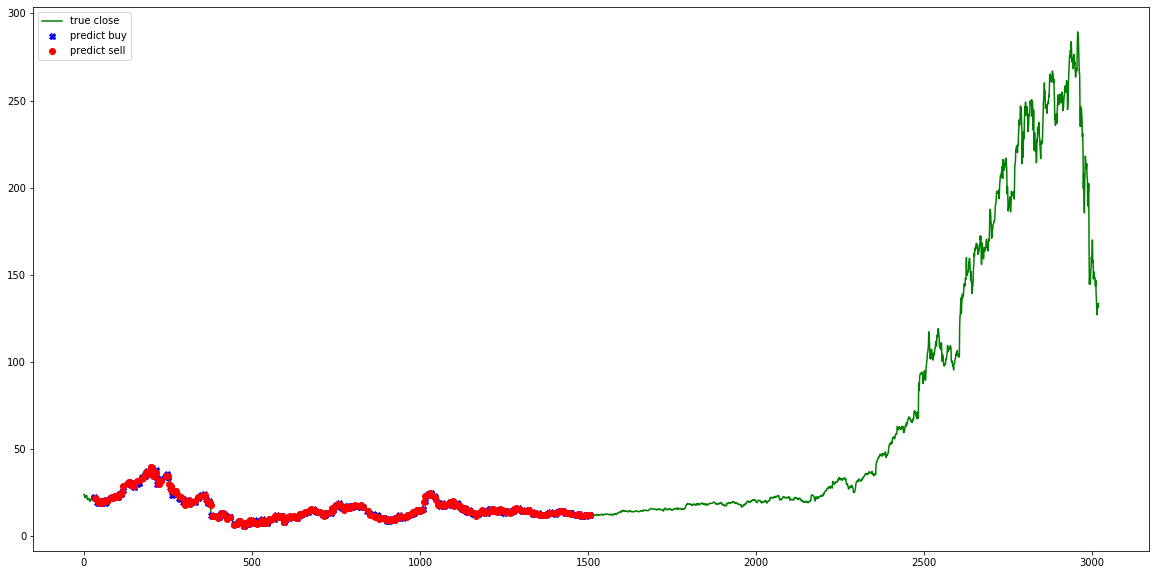

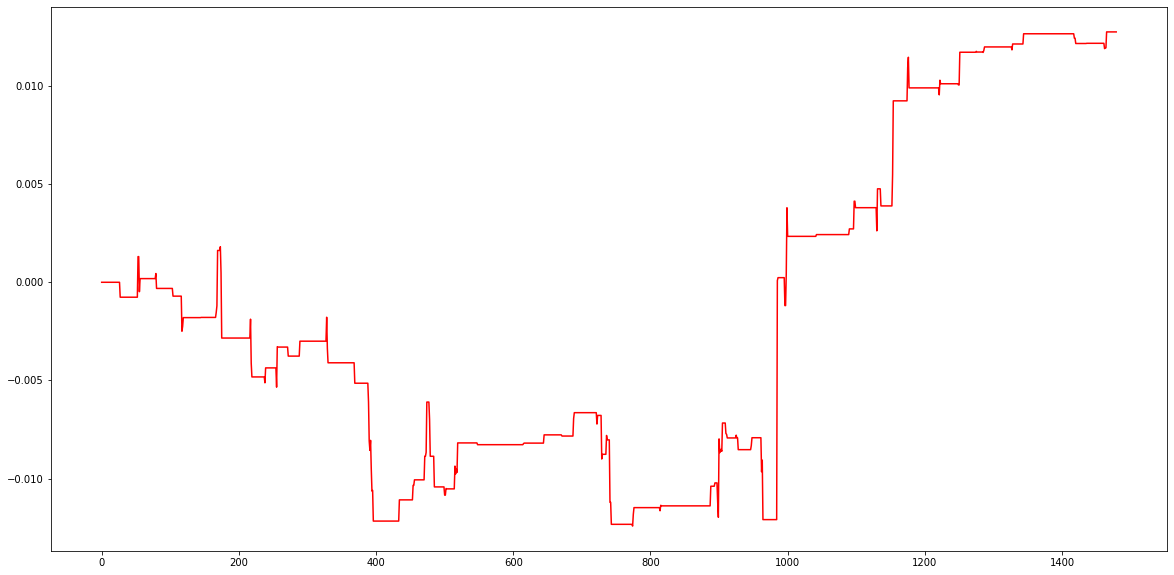


total gained -3.060000, total investment -0.003060 %


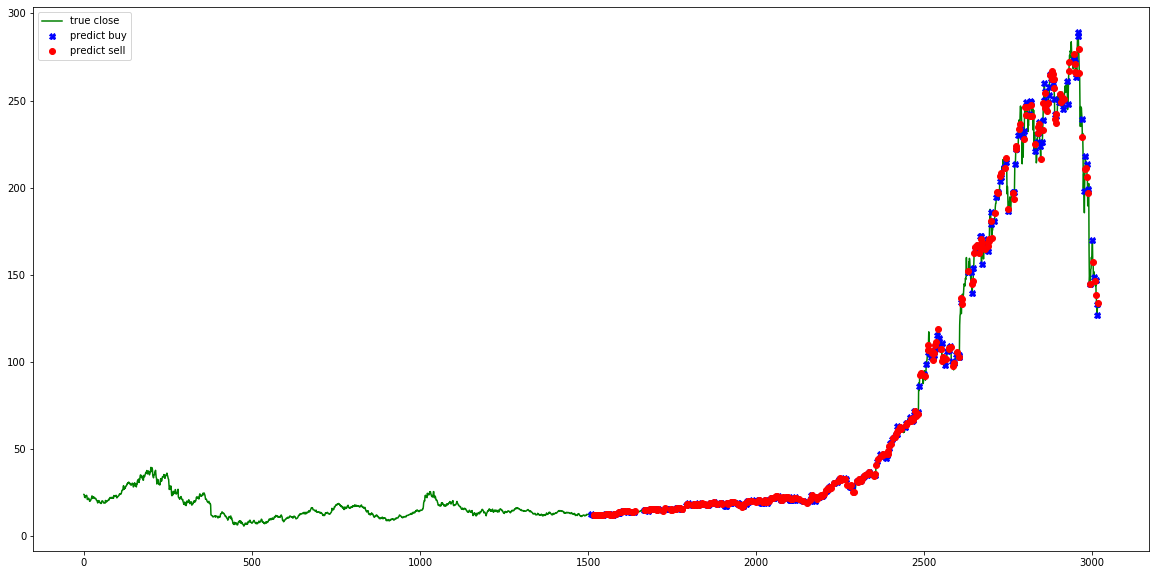

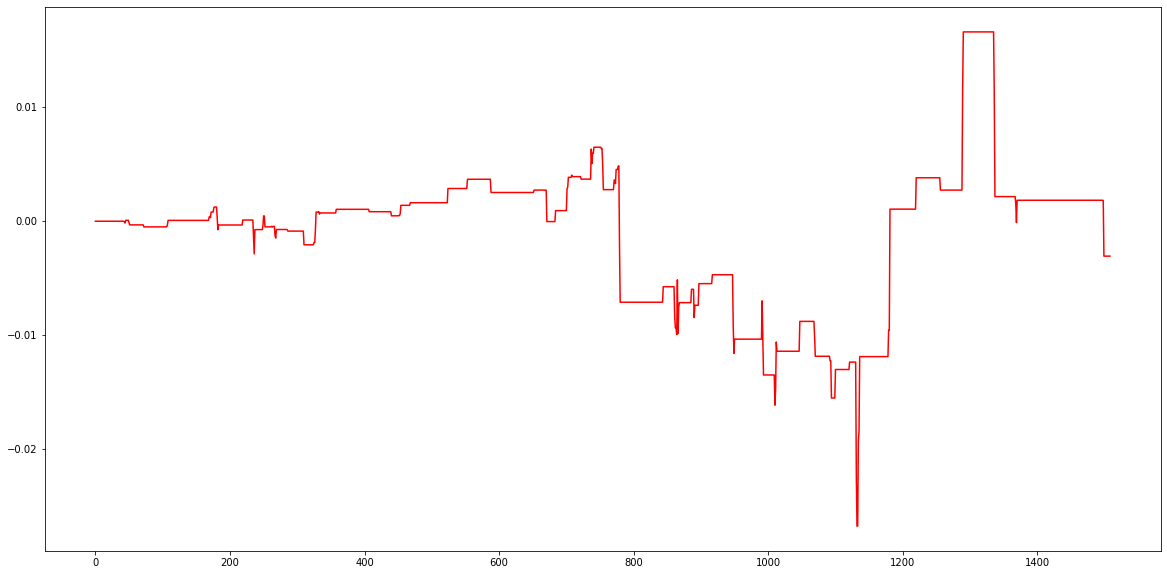

0.475
0.475
0.45125
0.5
0.5
iter 10. reward: -0.075774

total gained -75.774433, total investment -0.075774 %


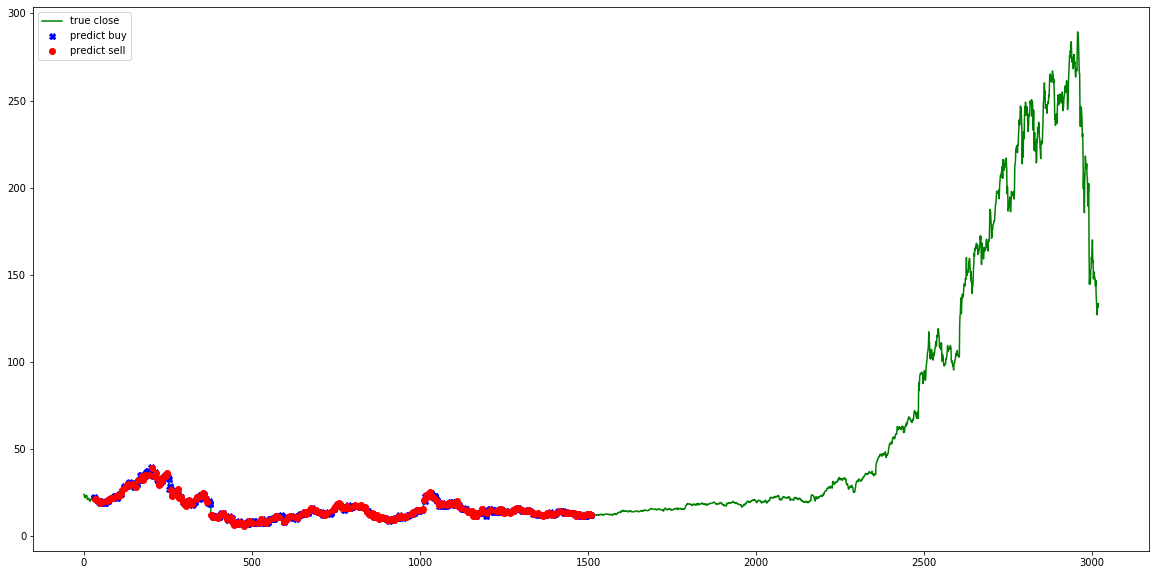

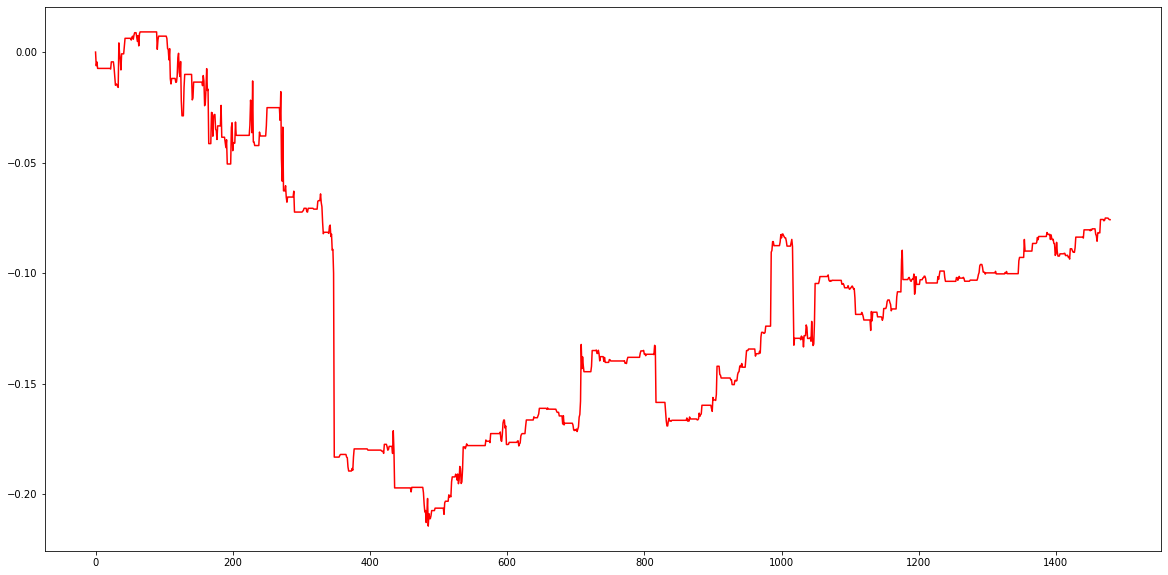


total gained -447.717990, total investment -0.447718 %


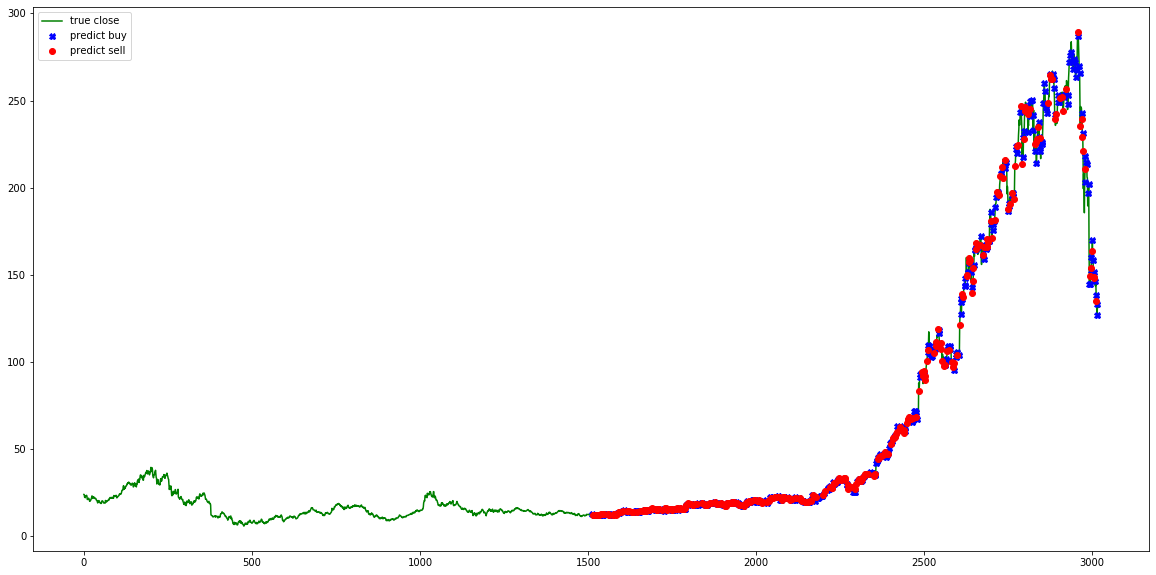

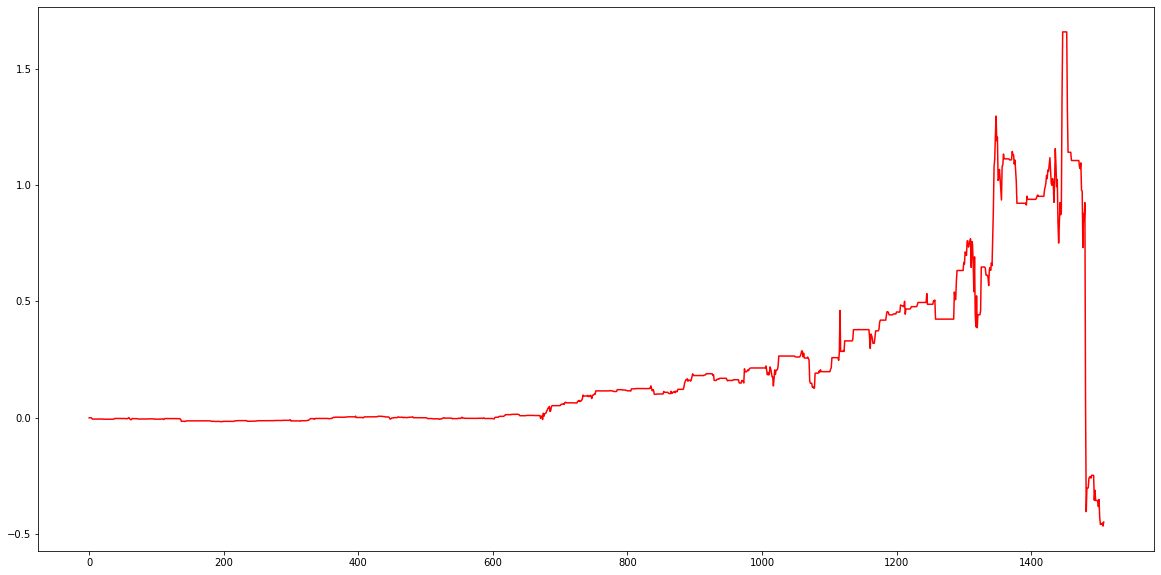

0.5
0.5
0.5
0.49999949999999993
0.4749995249999999
iter 15. reward: 0.013098

total gained 13.103233, total investment 0.013103 %


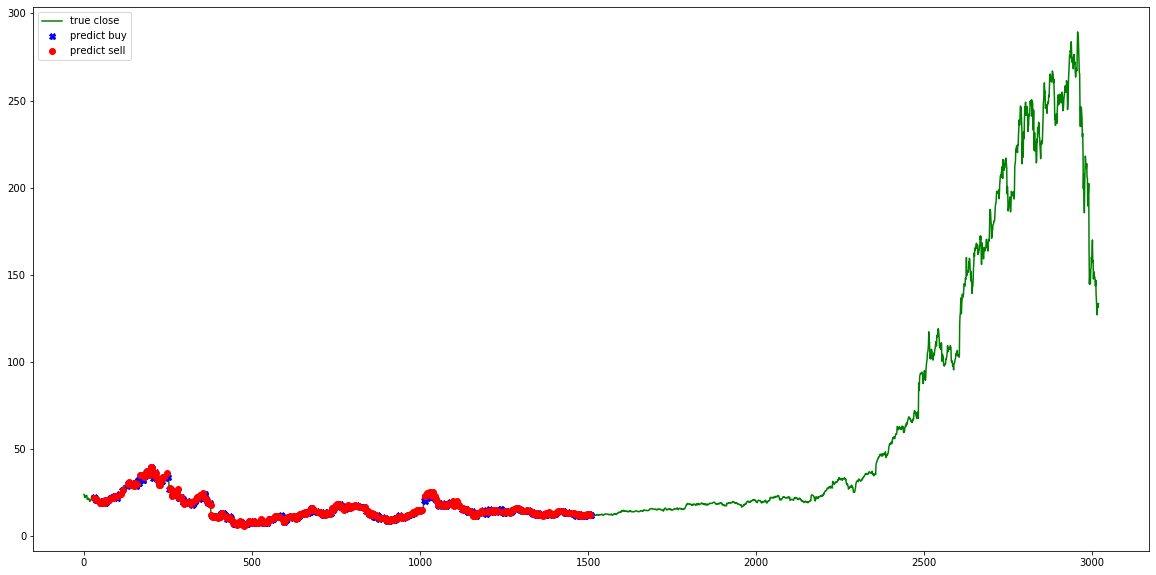

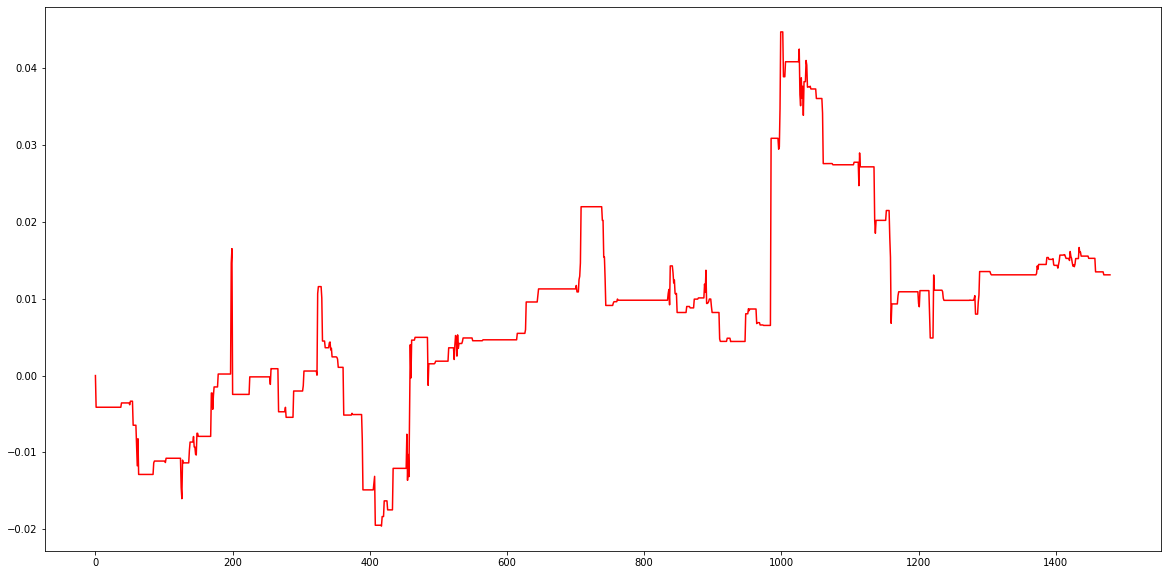


total gained -103.579330, total investment -0.103579 %


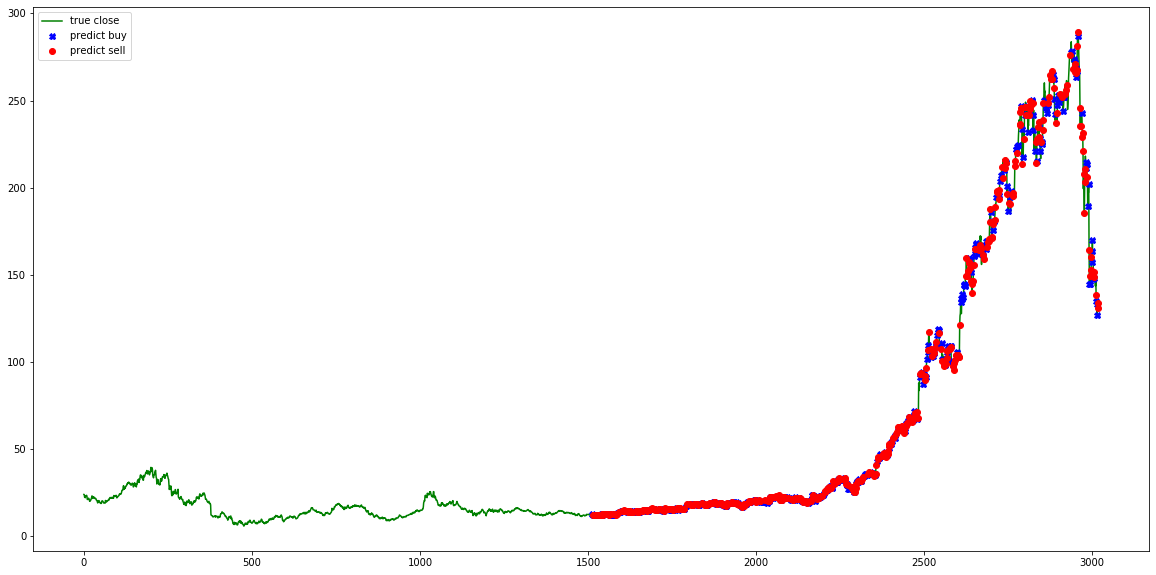

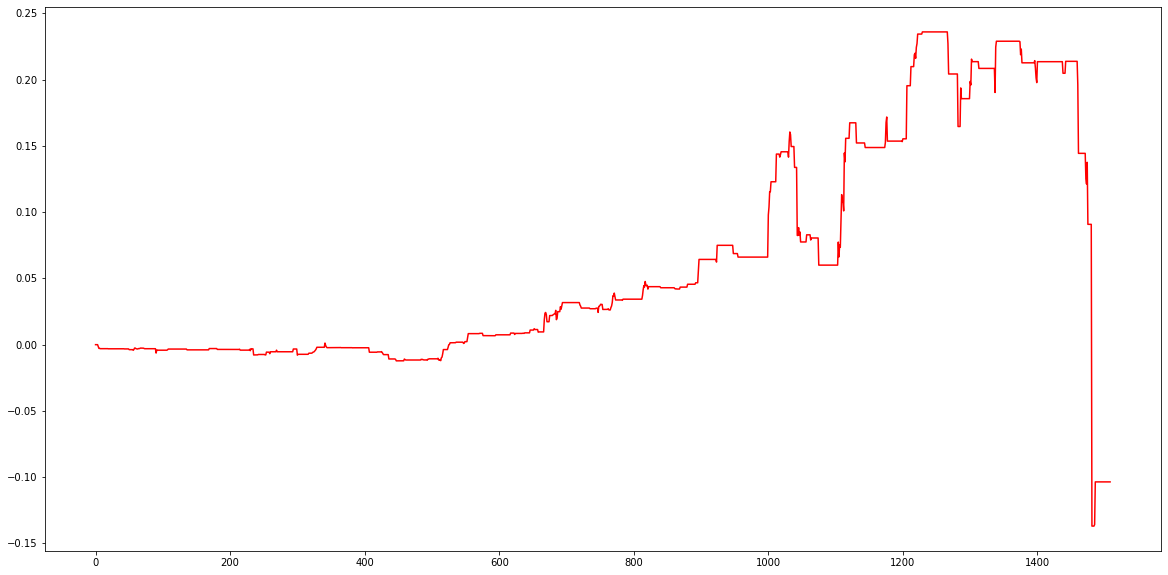

0.4512495487499999
0.5
0.5
0.5
0.5
iter 20. reward: -0.139560

total gained -139.559567, total investment -0.139560 %


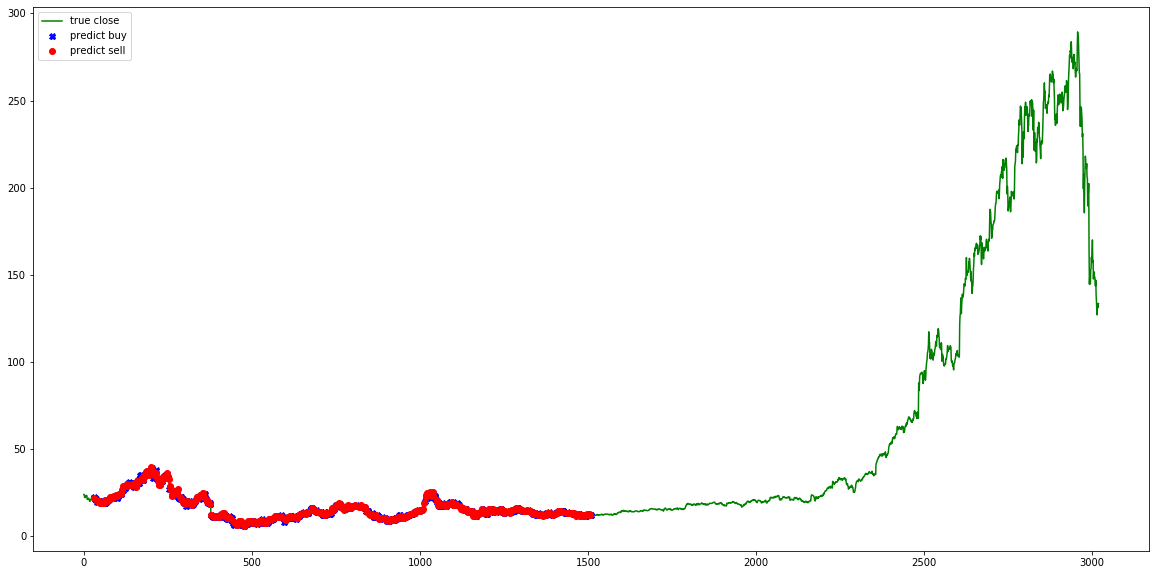

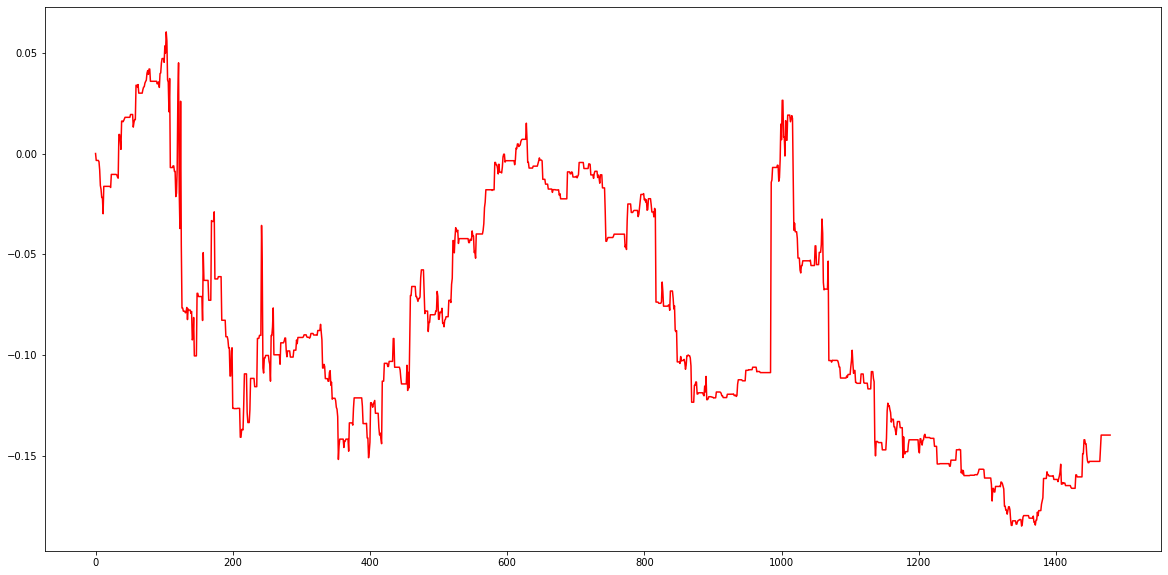


total gained 469.154510, total investment 0.469155 %


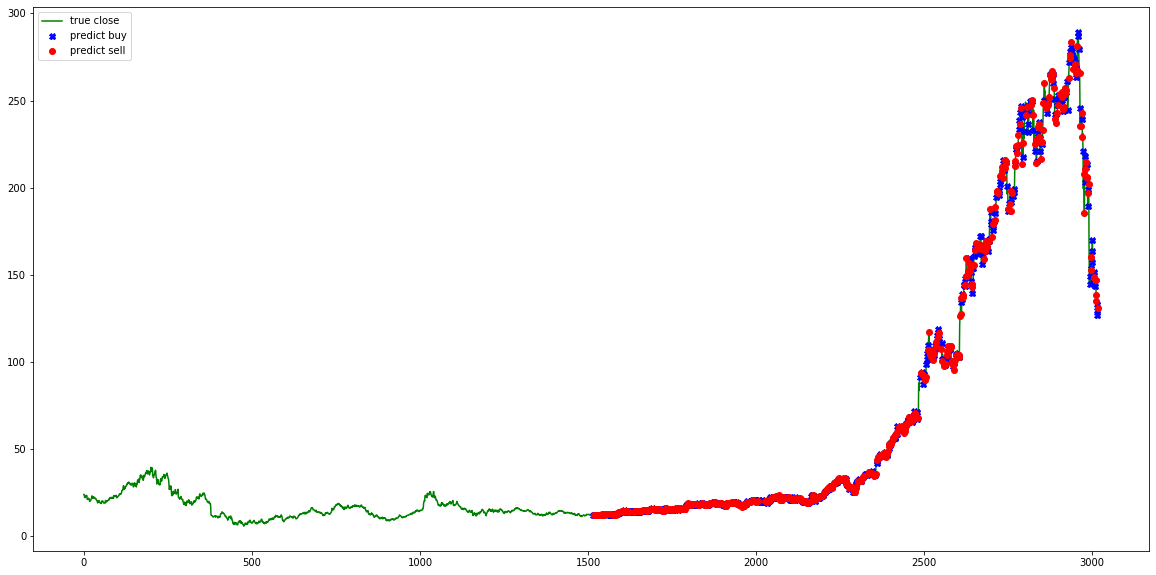

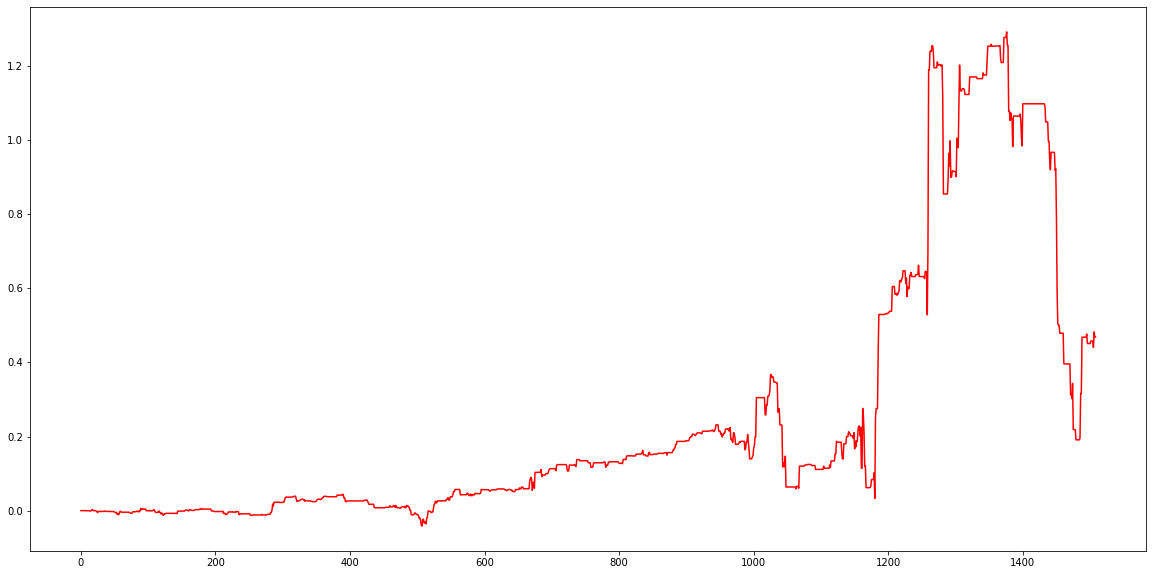

0.5
0.475
0.5
0.5
0.5
iter 25. reward: -0.029841

total gained -29.840700, total investment -0.029841 %


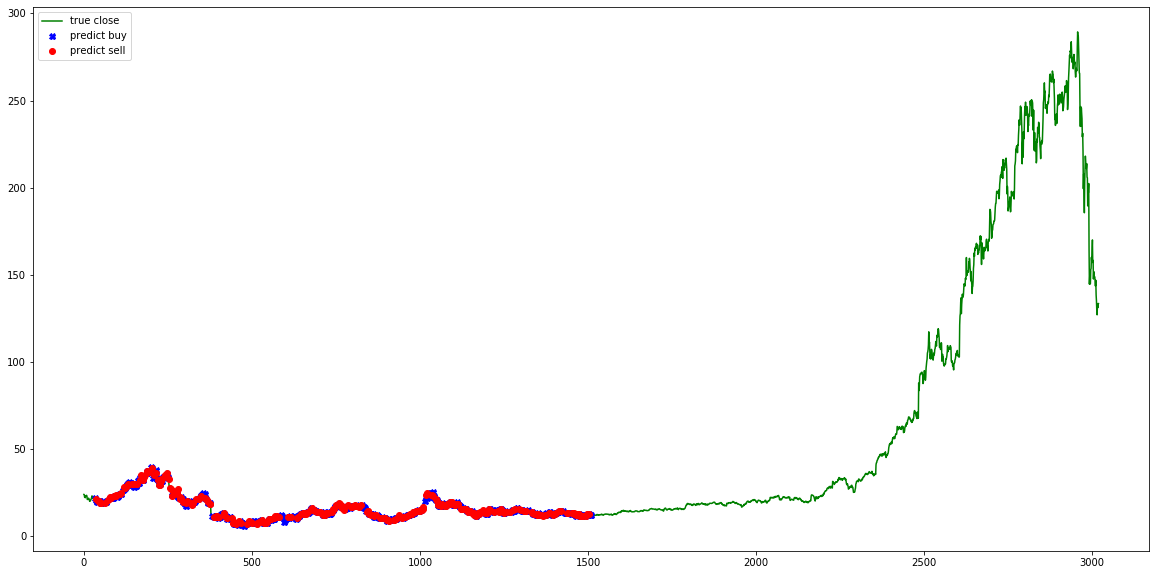

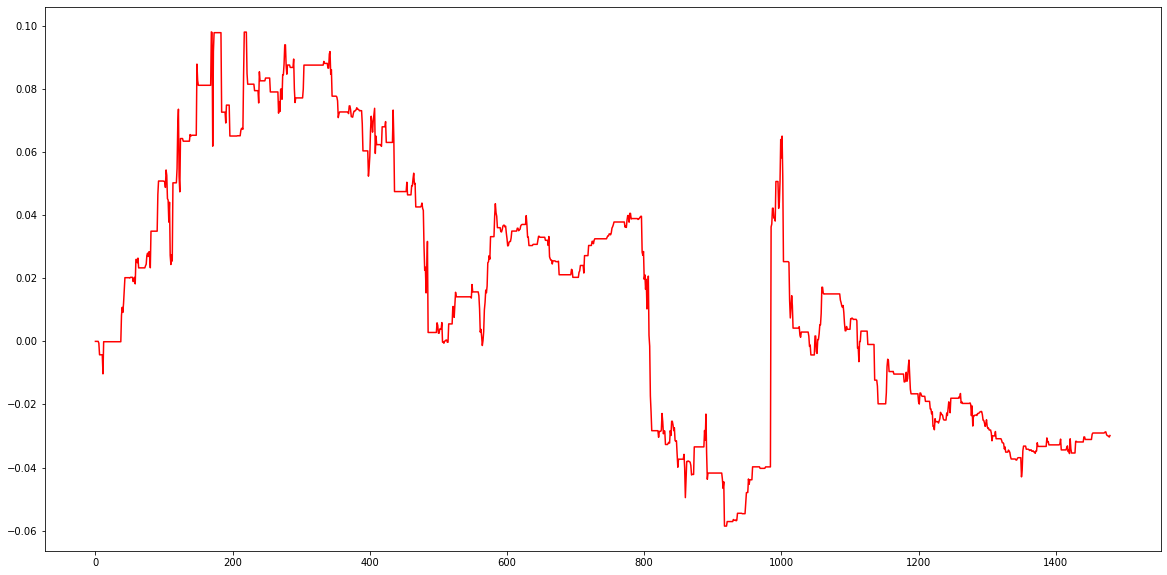


total gained 202.985270, total investment 0.202985 %


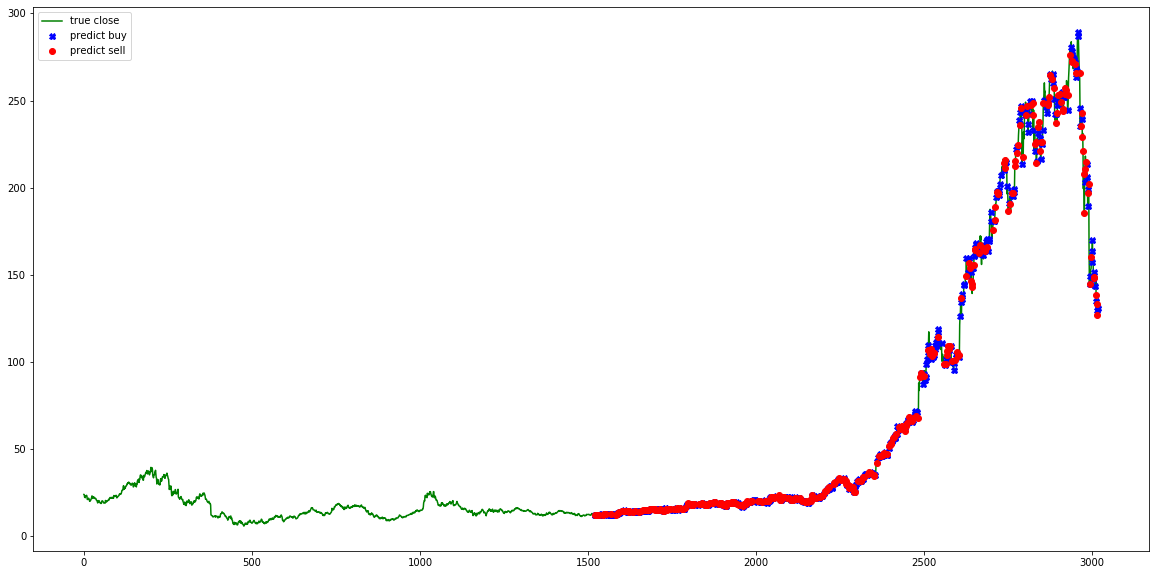

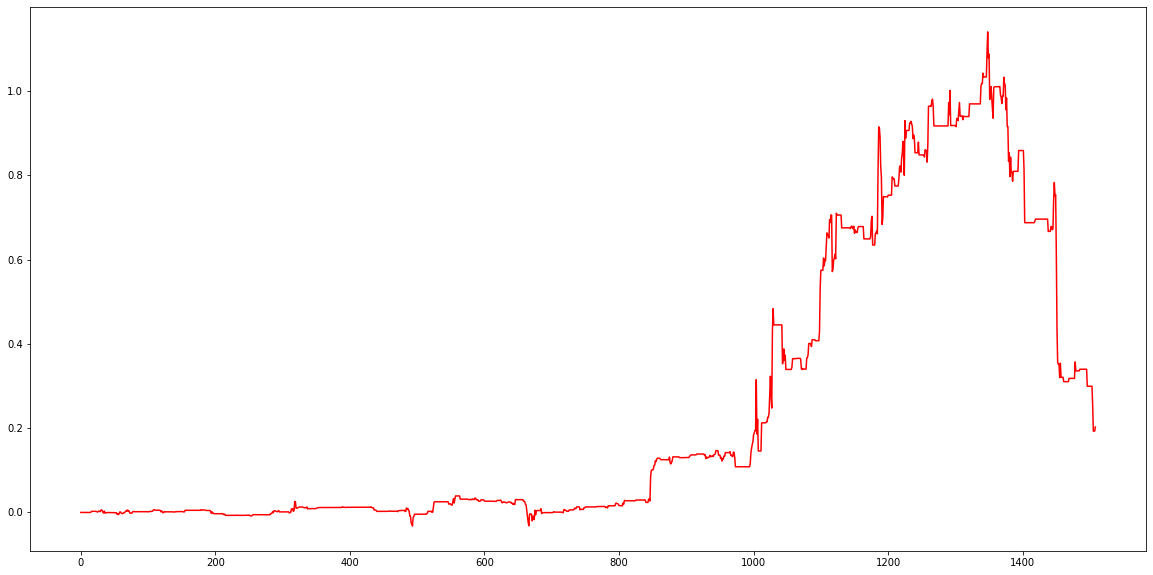

0.5
0.5
0.4995
0.474525
0.45079874999999997
iter 30. reward: 0.164335

total gained 164.405467, total investment 0.164405 %


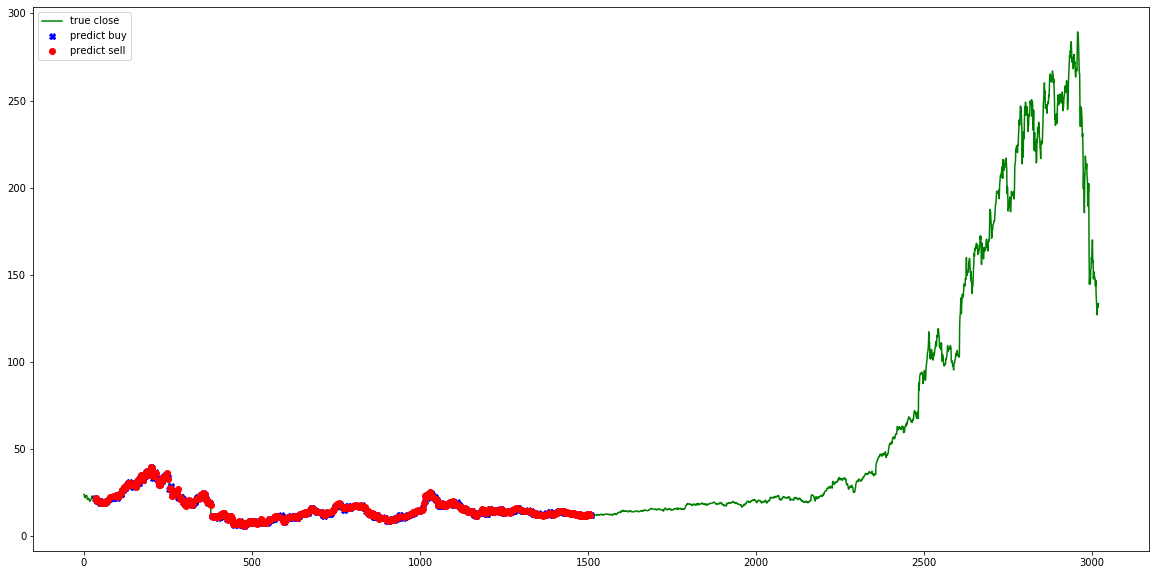

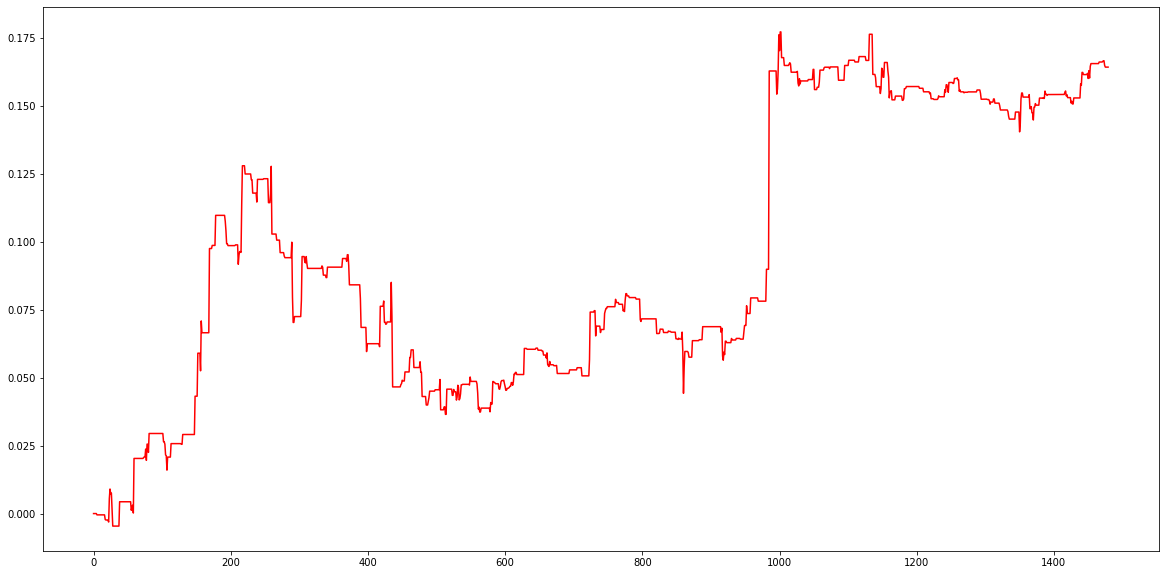


total gained -487.340580, total investment -0.487341 %


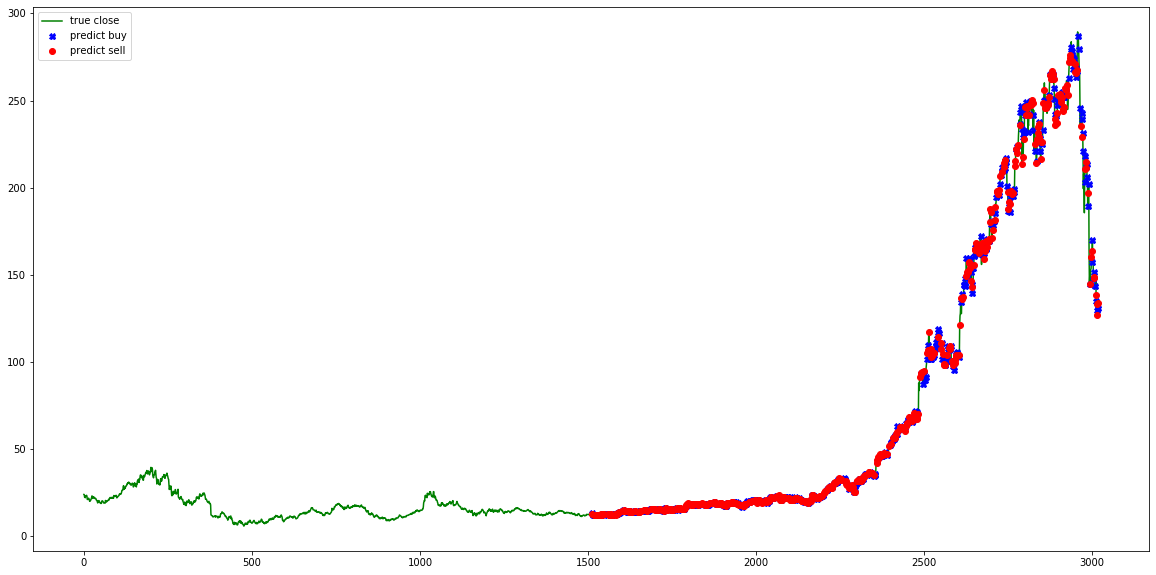

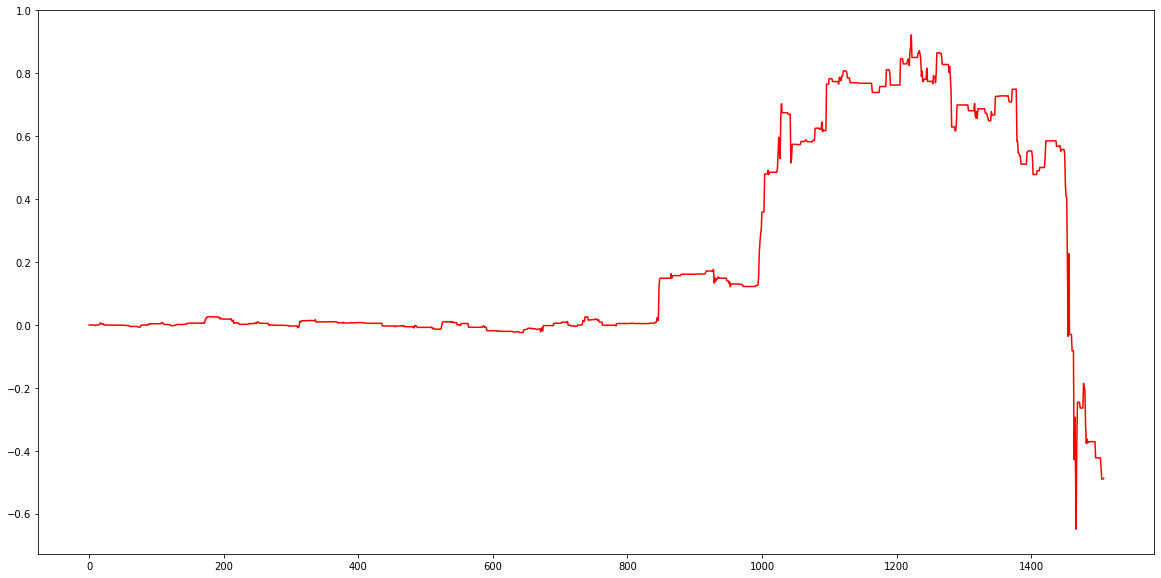

0.45079874999999997
0.45079874999999997
0.4282588125
0.4282588125
0.4282588125
iter 35. reward: 0.233297

total gained 233.432433, total investment 0.233432 %


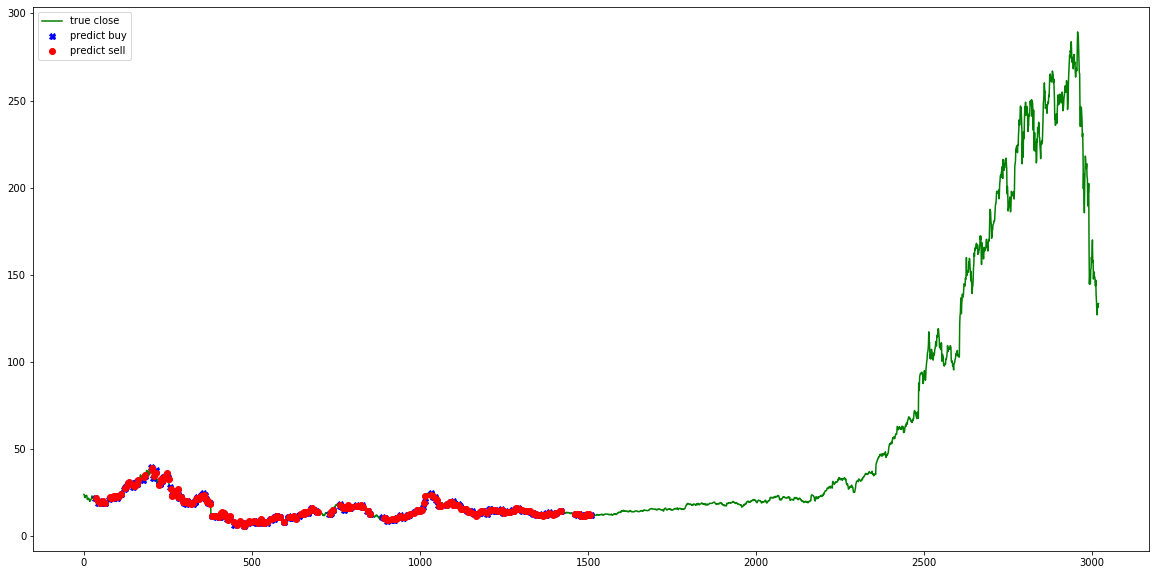

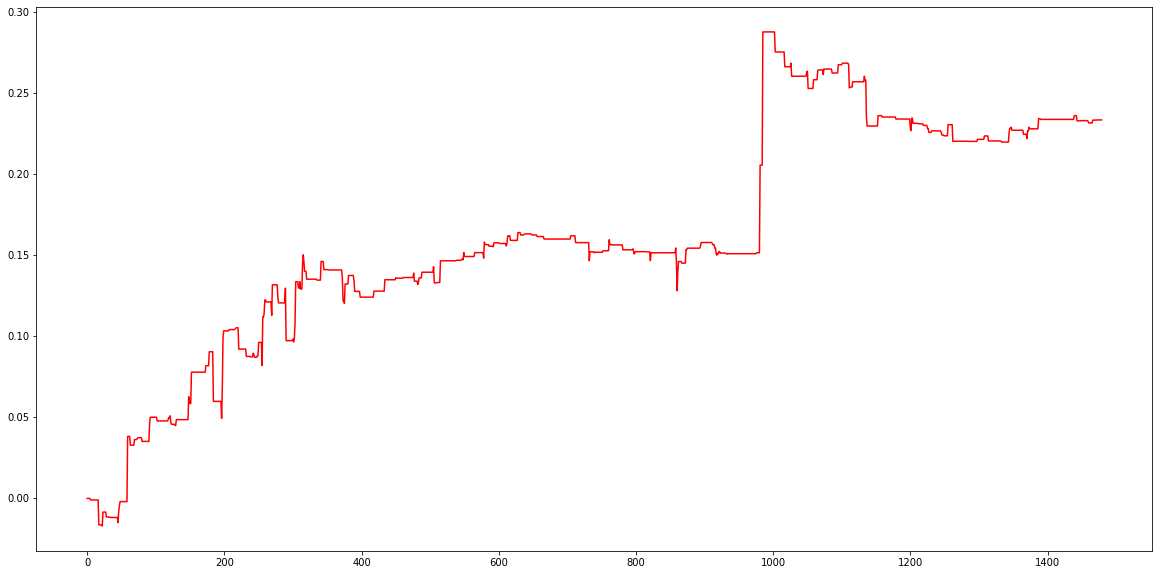


total gained 810.015770, total investment 0.810016 %


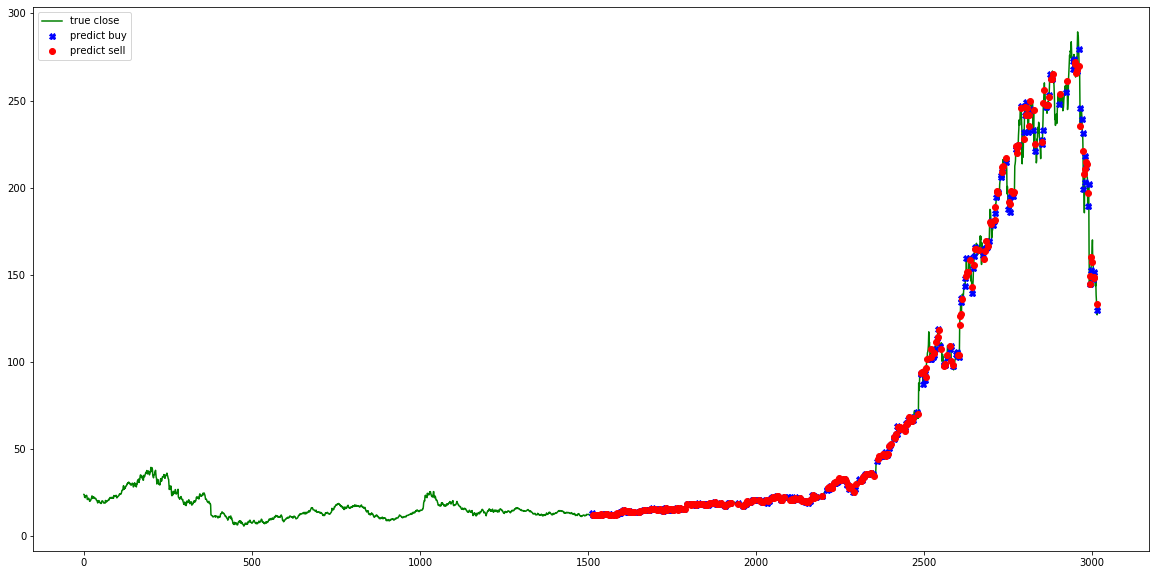

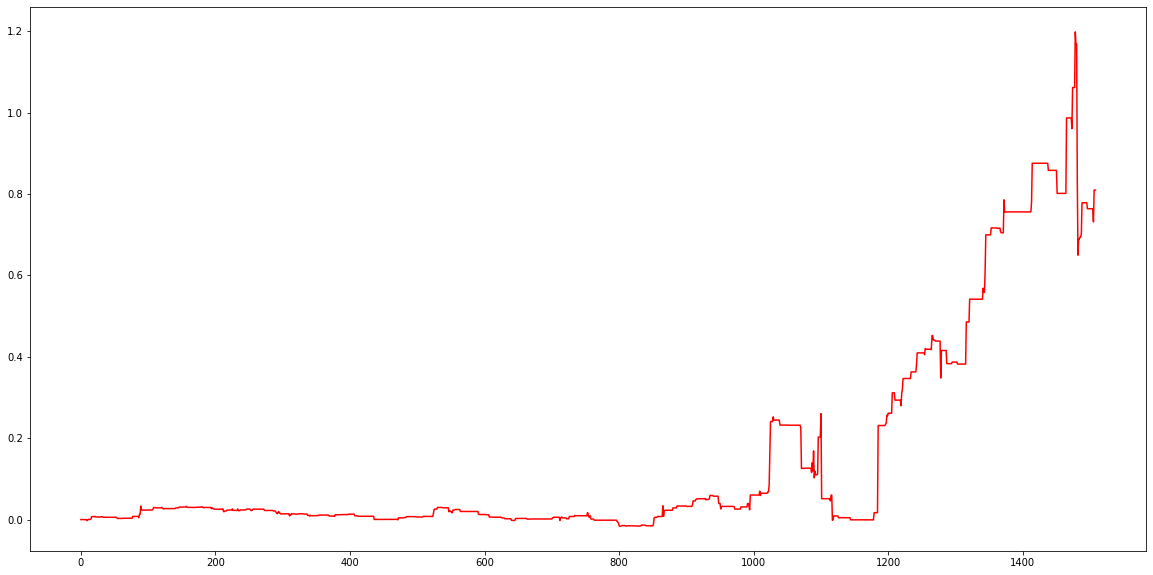

0.4282588125
0.40684587187499993
0.40684587187499993
0.40684587187499993
0.40684587187499993
iter 40. reward: 0.424007

total gained 424.513233, total investment 0.424513 %


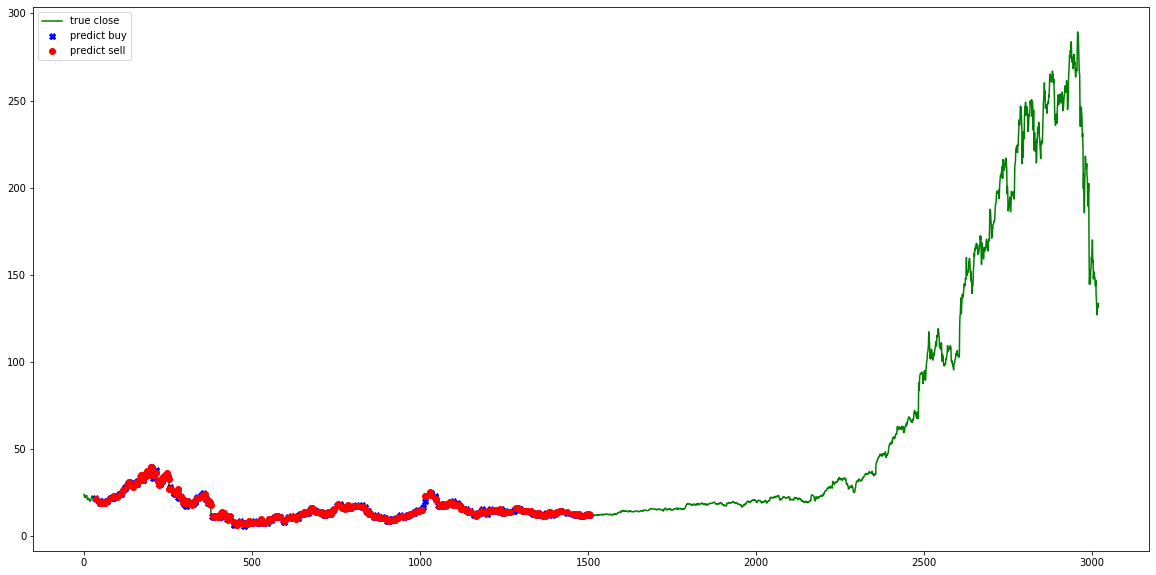

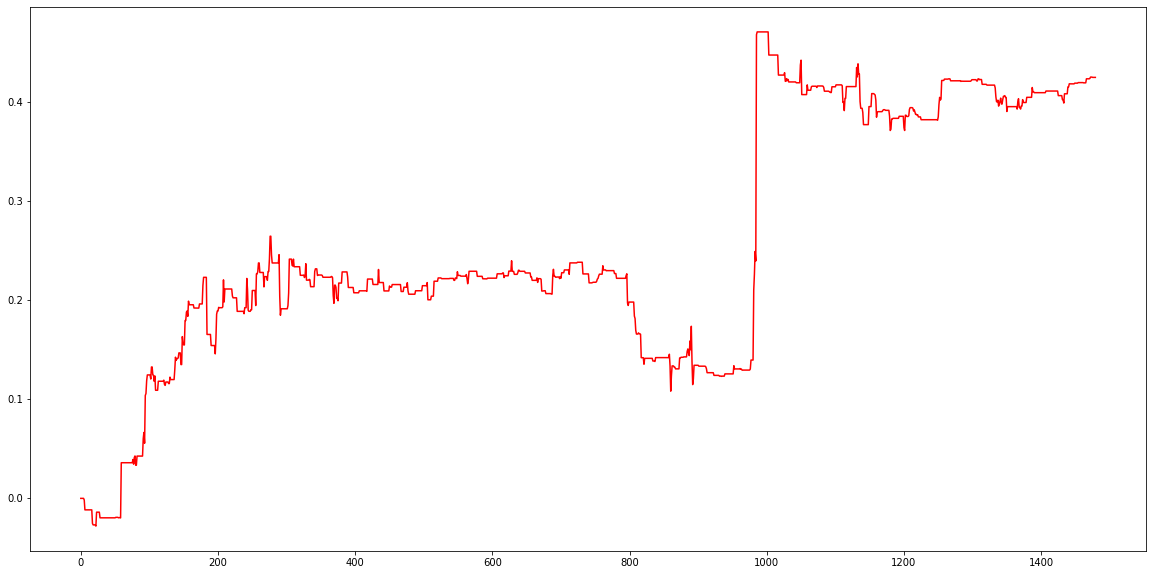


total gained 152.748850, total investment 0.152749 %


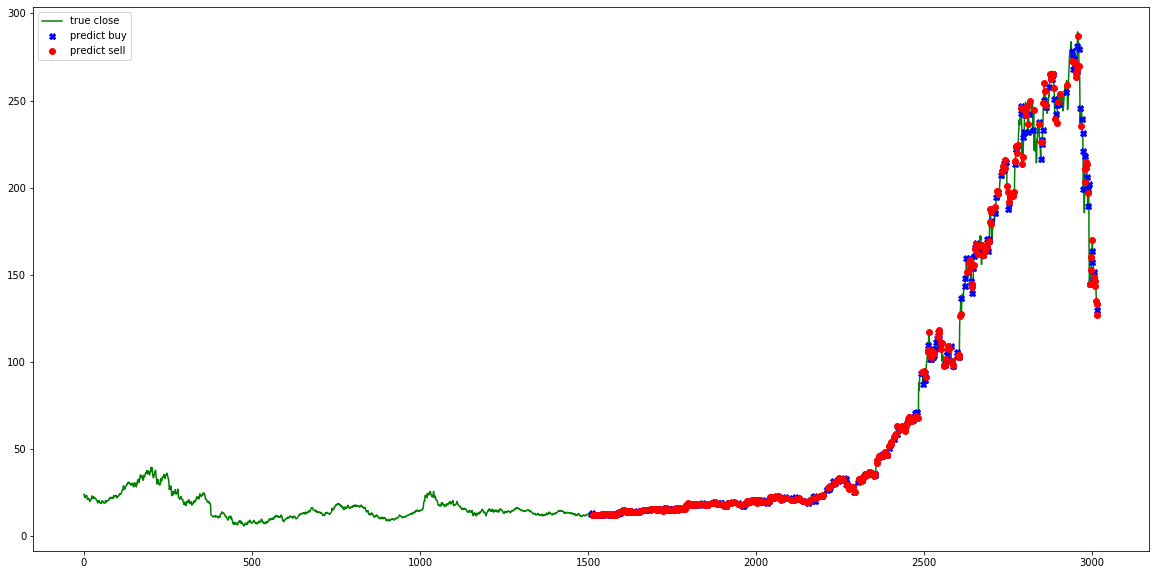

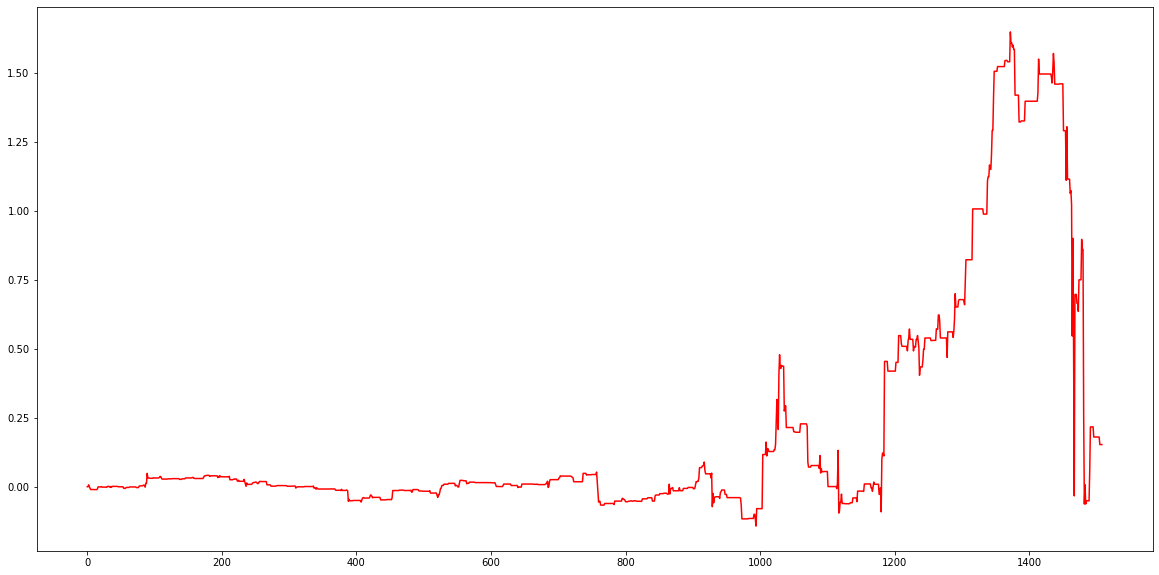

0.5
0.5
0.5
0.5
0.5
iter 45. reward: -0.086659

total gained -86.659367, total investment -0.086659 %


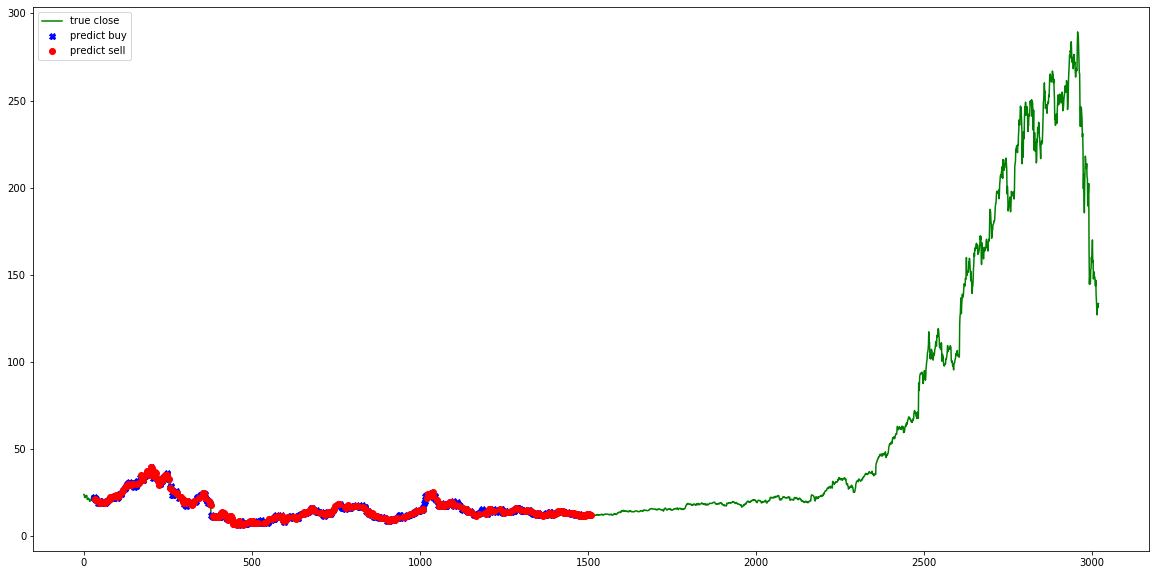

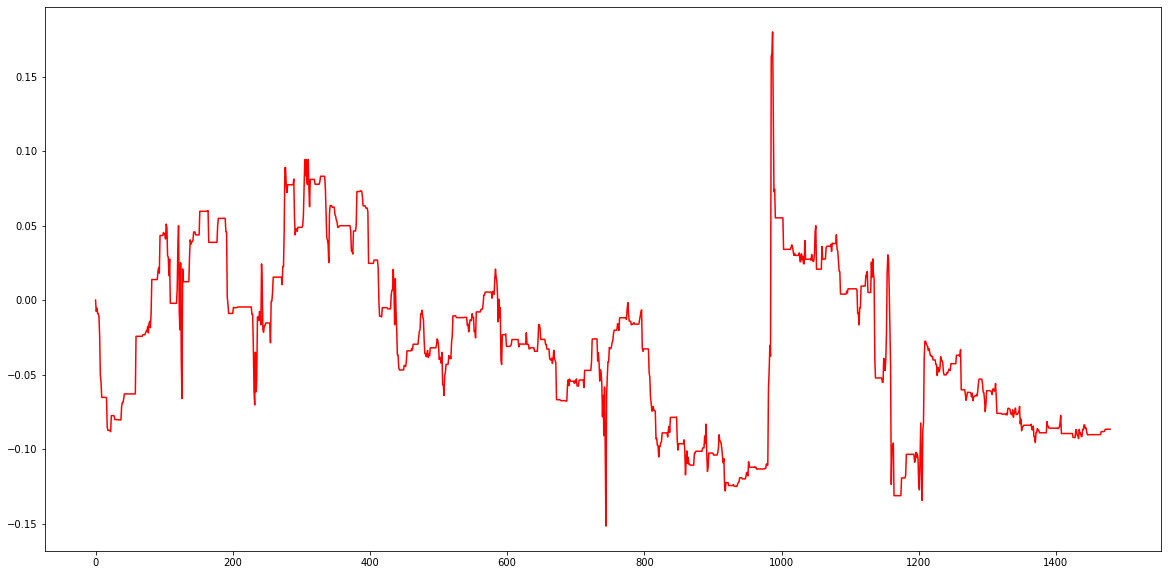


total gained 1458.349580, total investment 1.458350 %


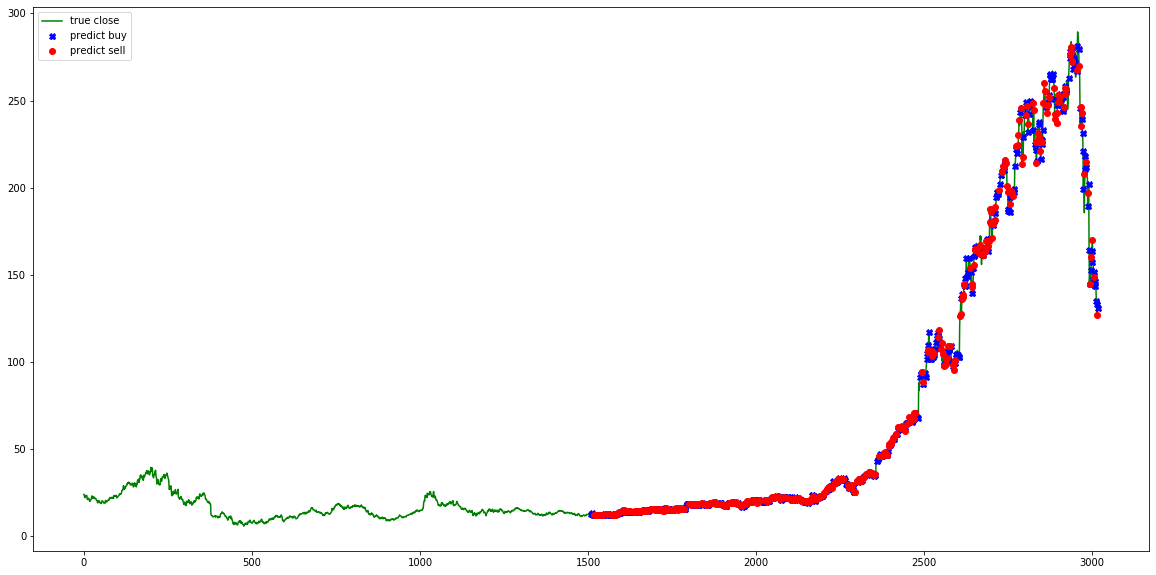

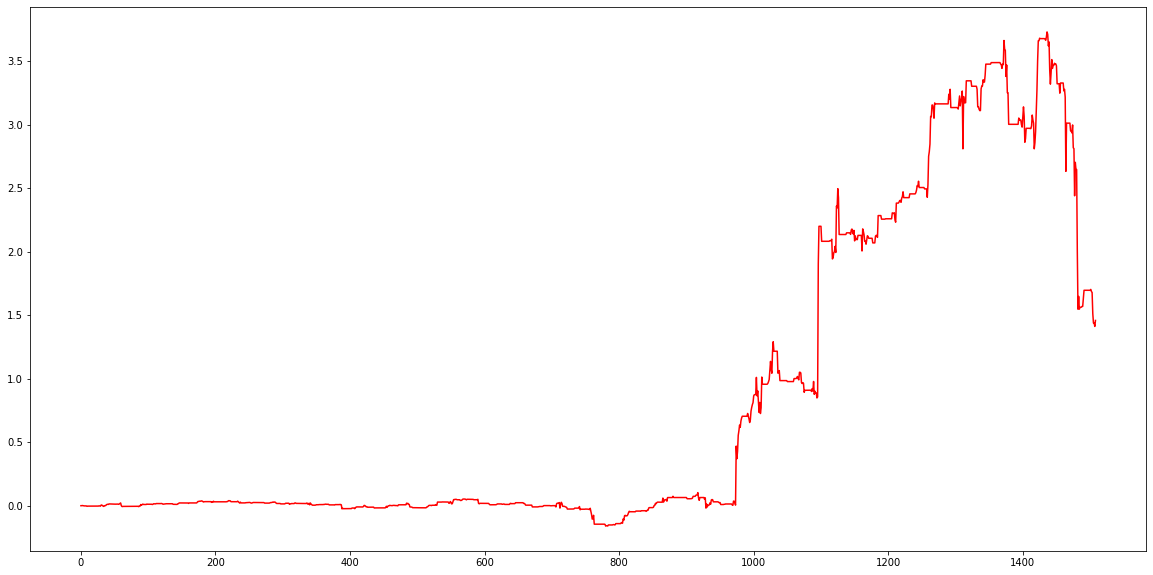

0.5
0.5
0.475
0.475
0.5
iter 50. reward: -0.093930

total gained -93.930433, total investment -0.093930 %


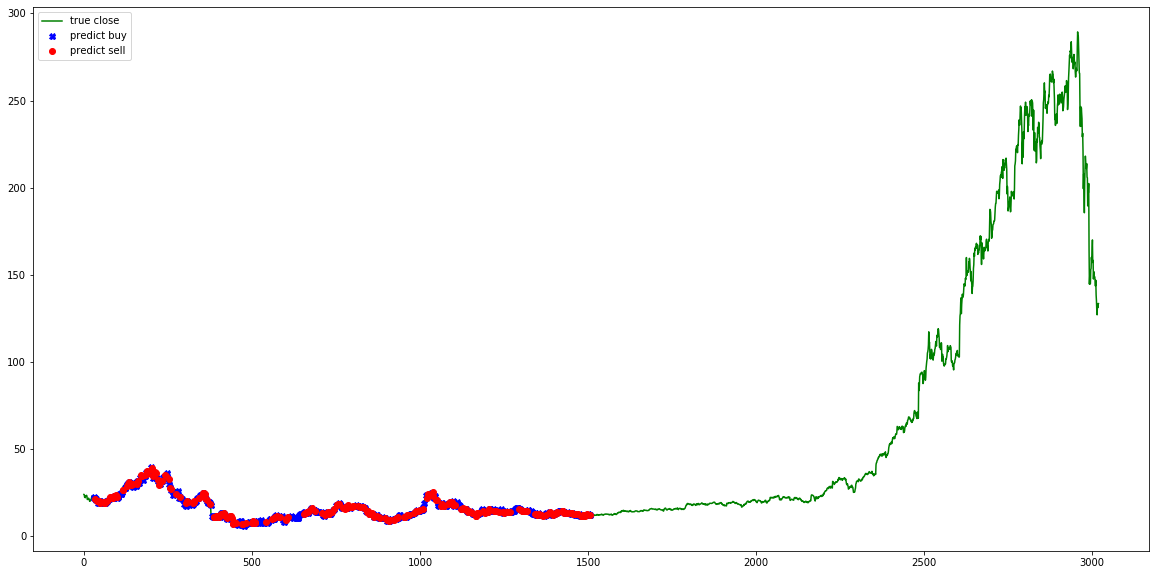

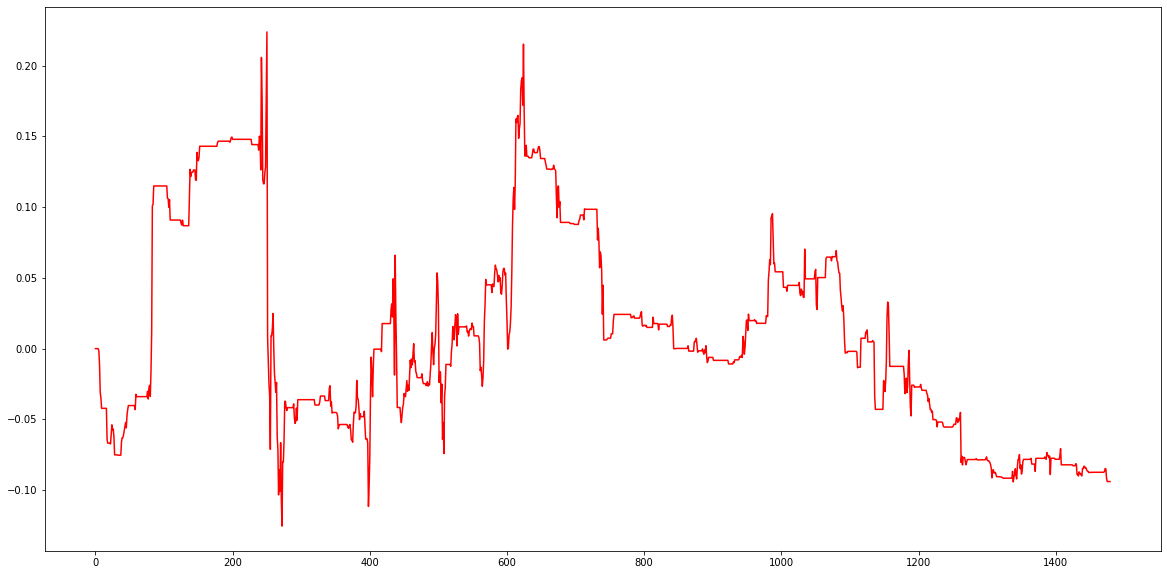


total gained 859.921660, total investment 0.859922 %


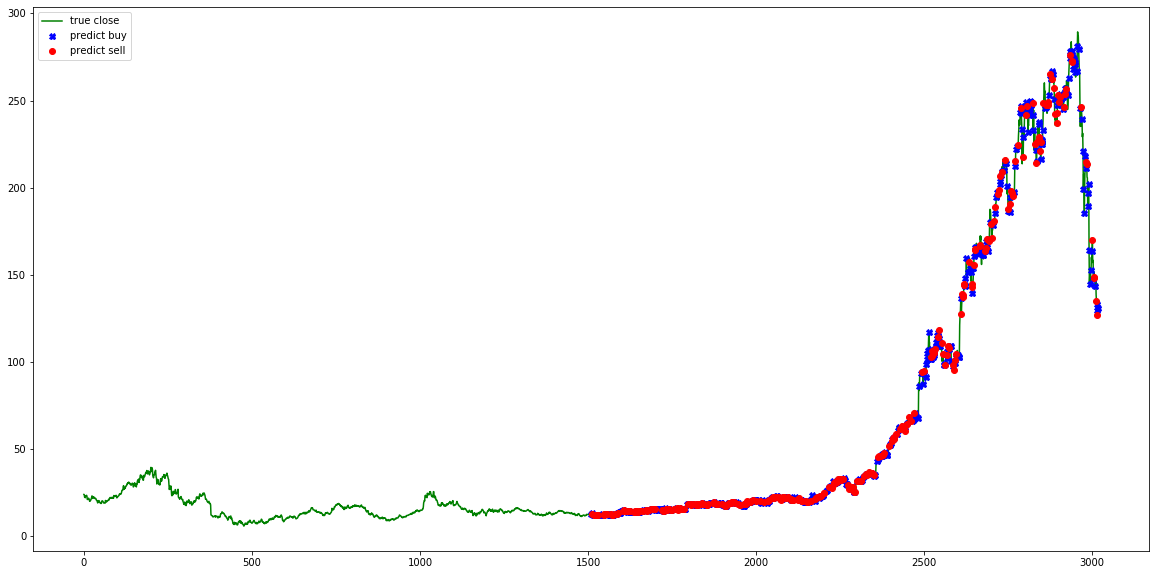

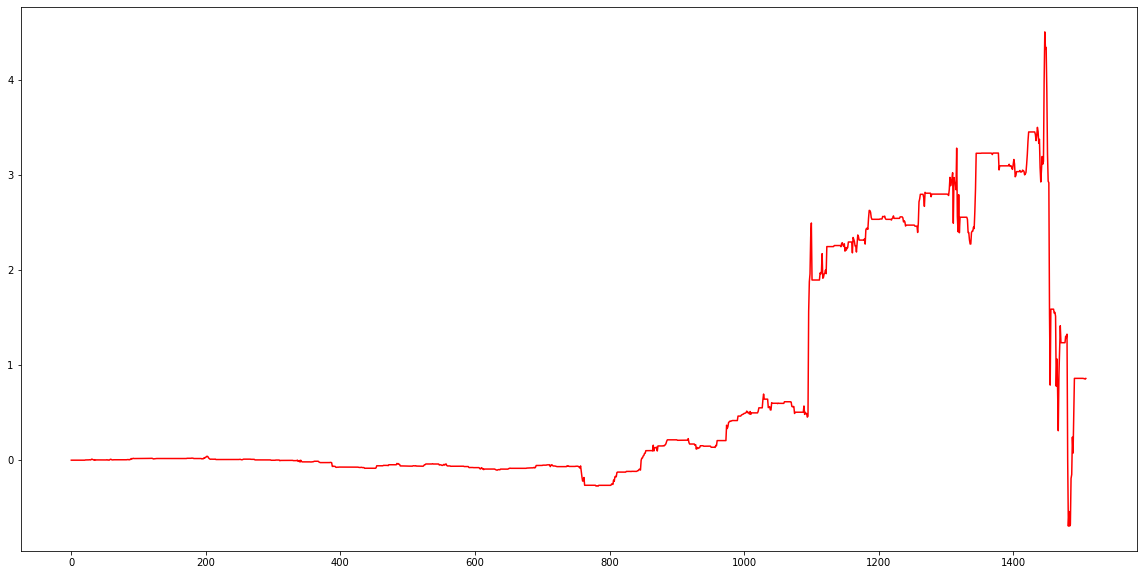

0.475
0.475
0.475
0.45125
0.45125
iter 55. reward: 0.586419

total gained 587.493834, total investment 0.587494 %


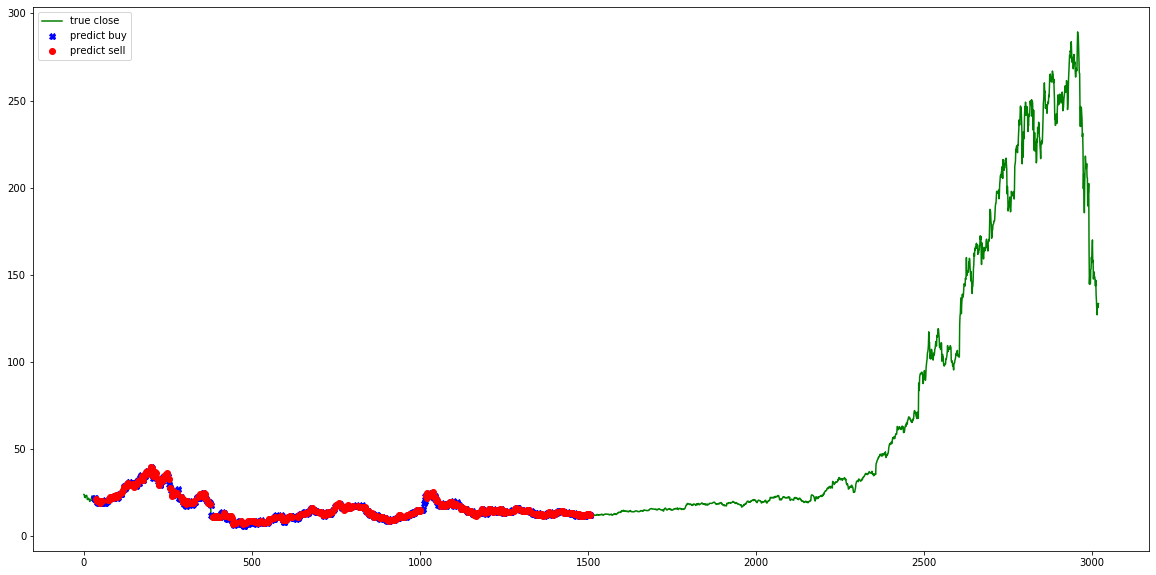

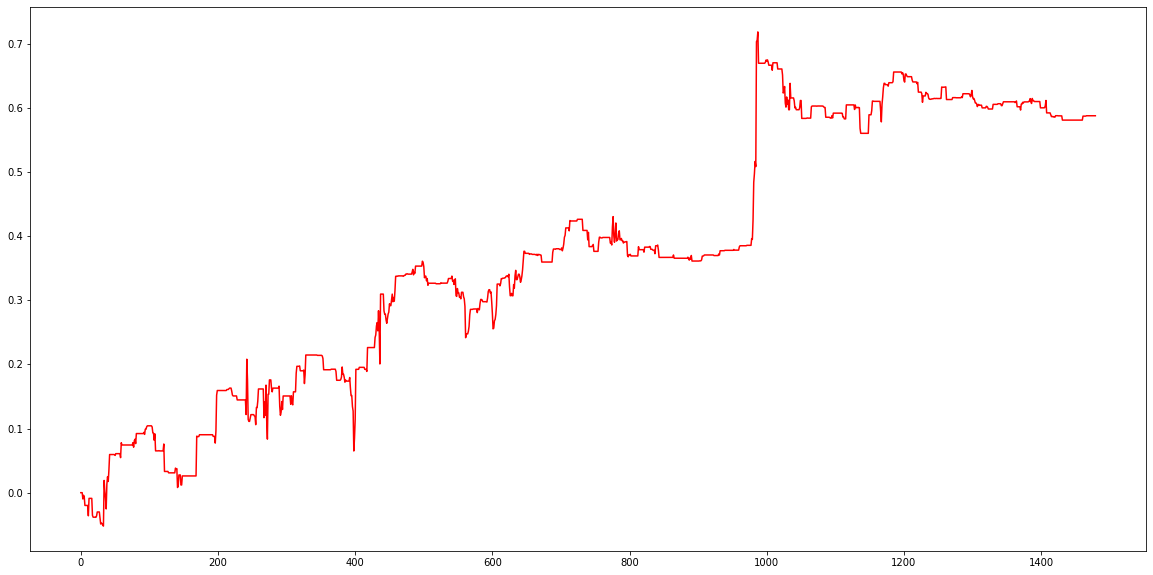


total gained 1602.509030, total investment 1.602509 %


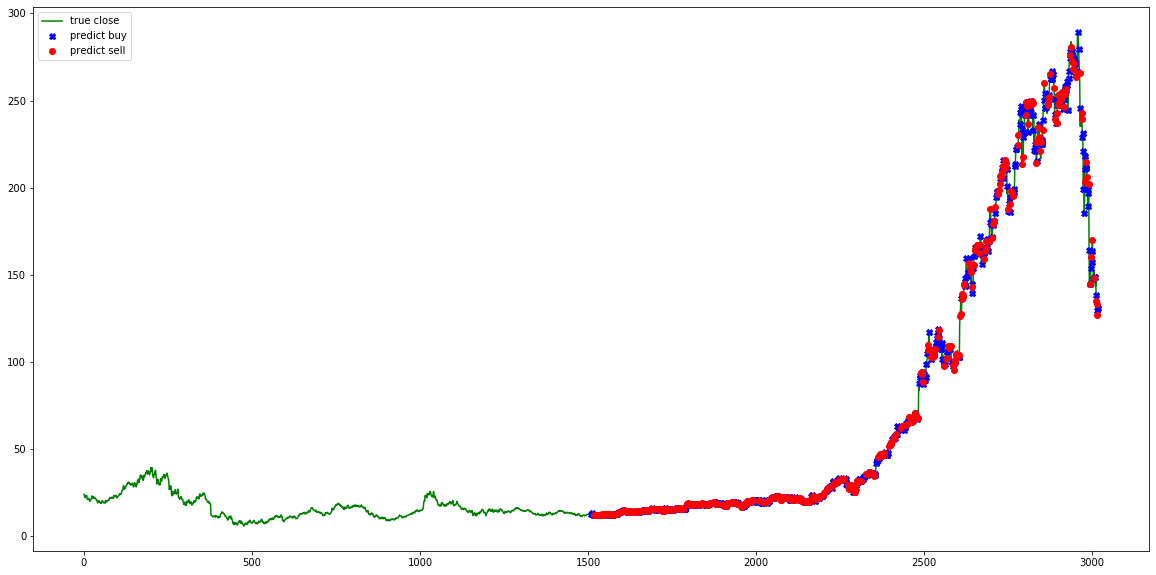

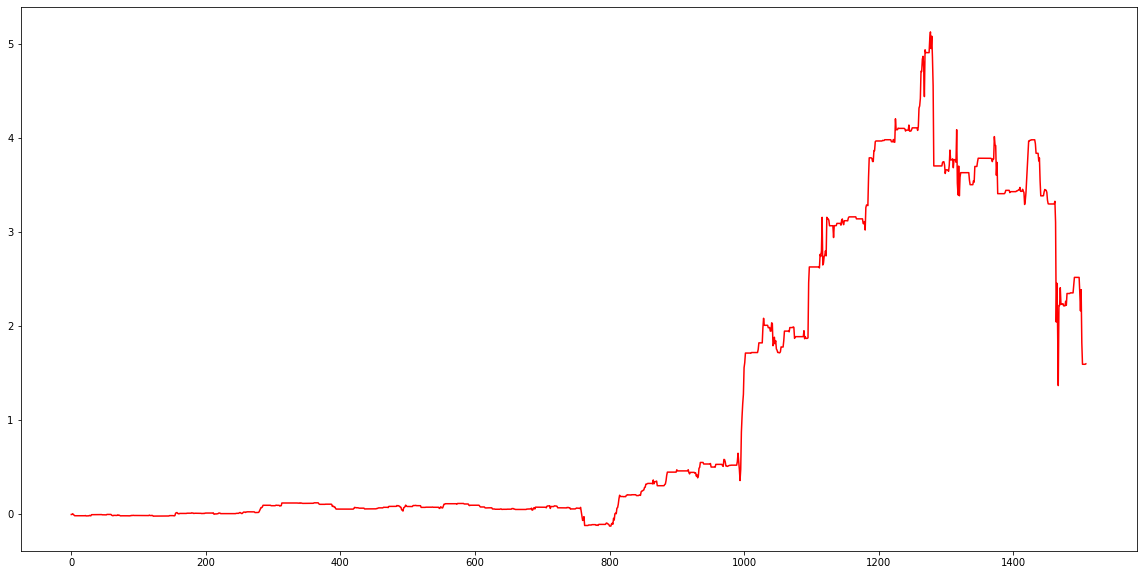

0.45125
0.45125
0.42868749999999994
0.40725312499999994
0.40725312499999994
iter 60. reward: 0.766351

total gained 770.741967, total investment 0.770742 %


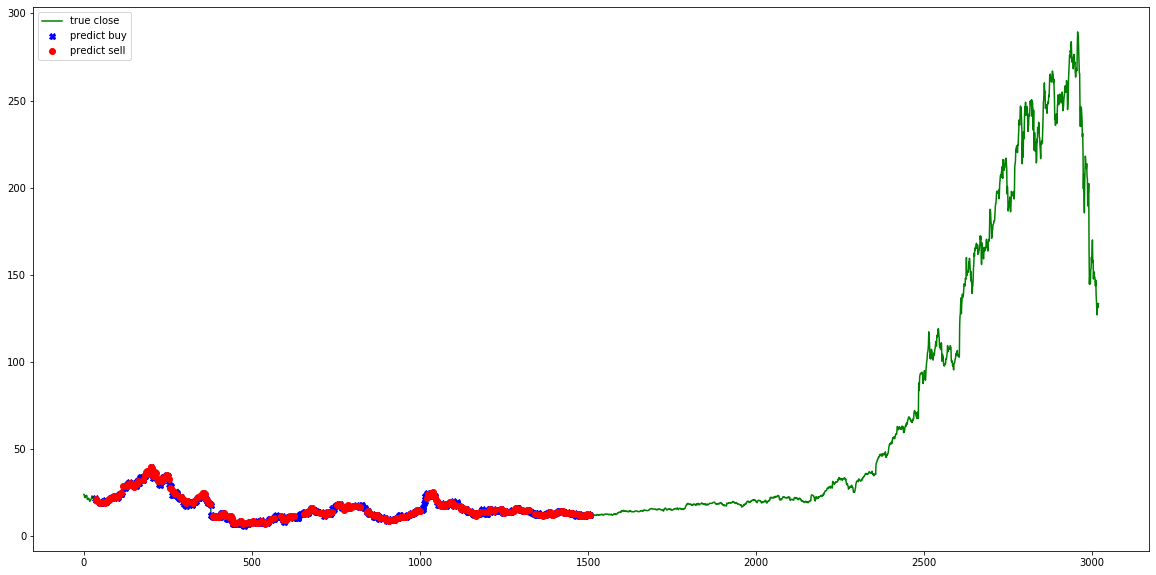

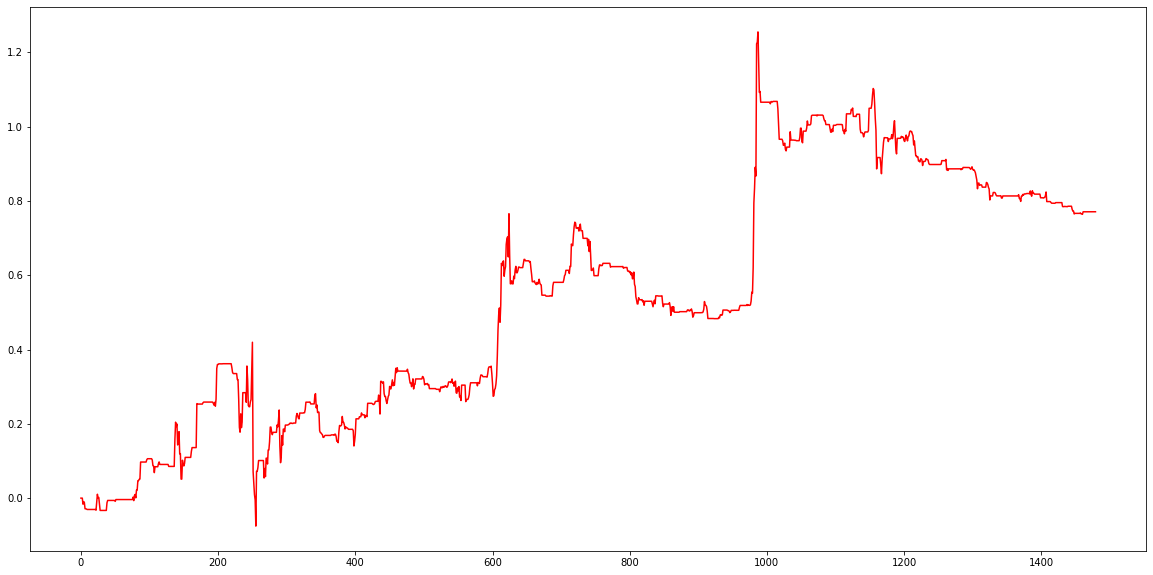


total gained 6241.384050, total investment 6.241384 %


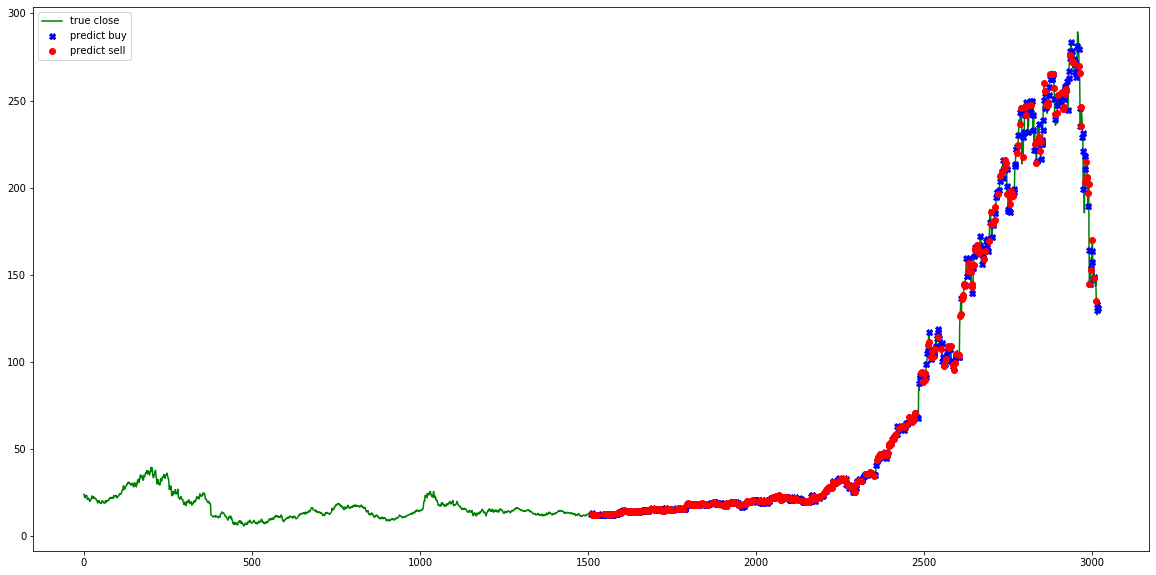

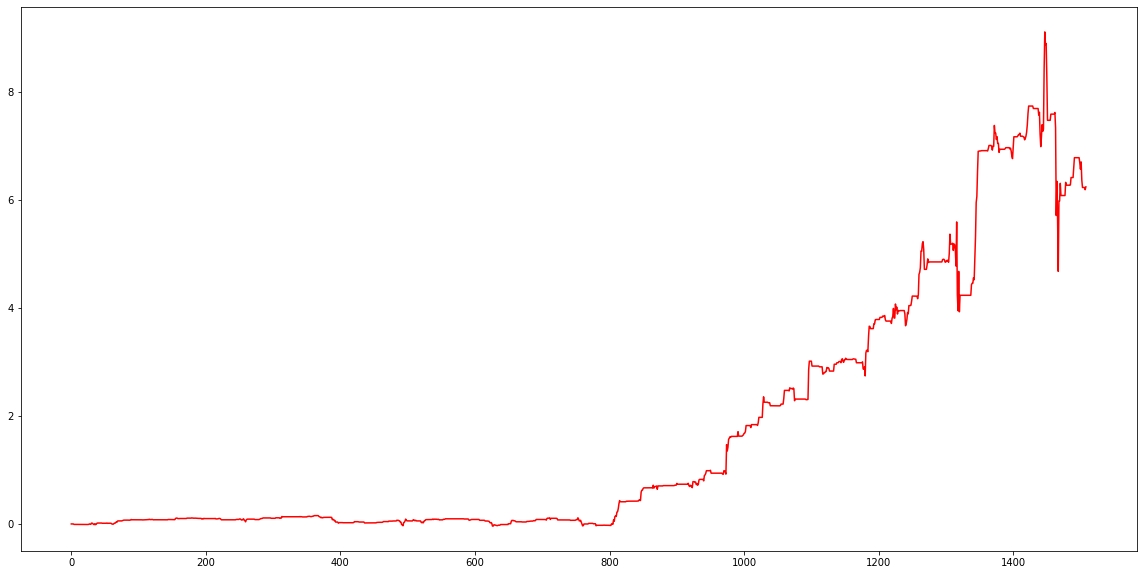

0.40725312499999994
0.40725312499999994
0.40725312499999994
0.40725312499999994
0.38689046874999994
iter 65. reward: 3.079778

total gained 3101.602701, total investment 3.101603 %


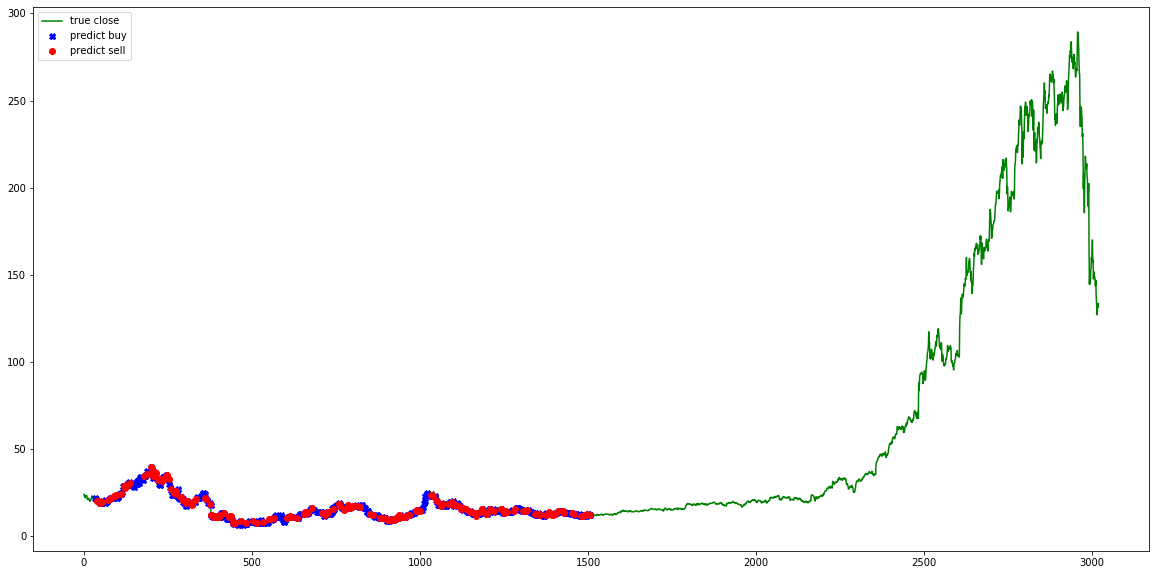

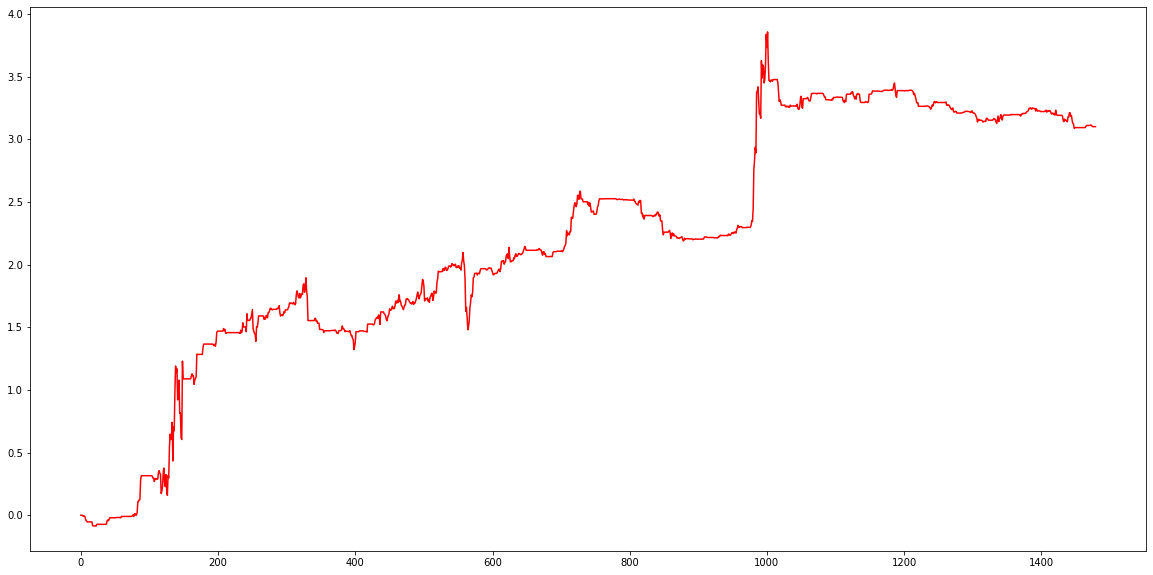


total gained 4617.684770, total investment 4.617685 %


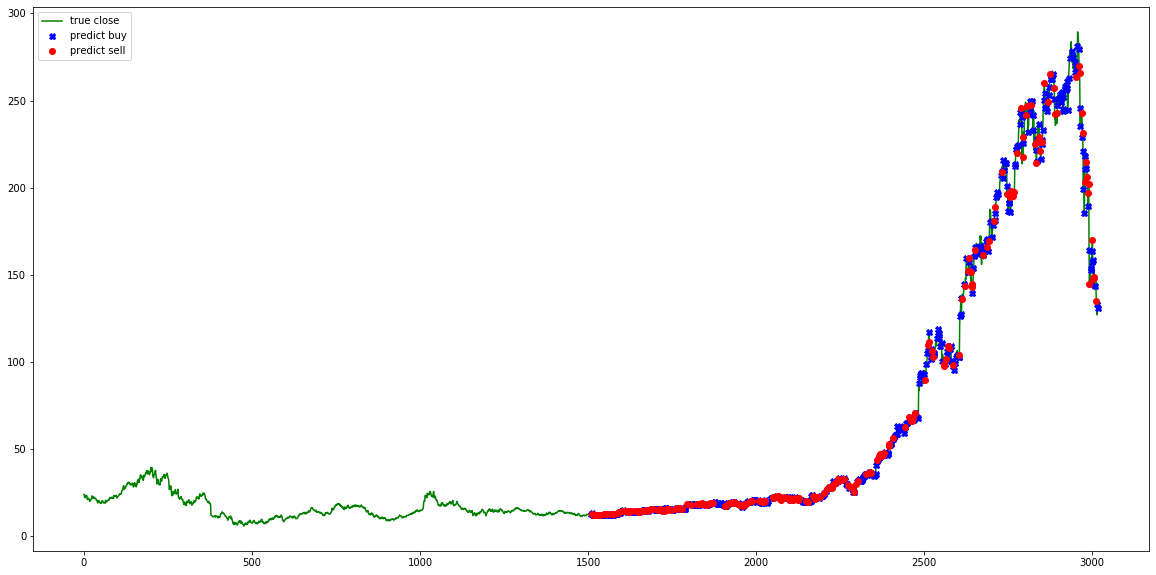

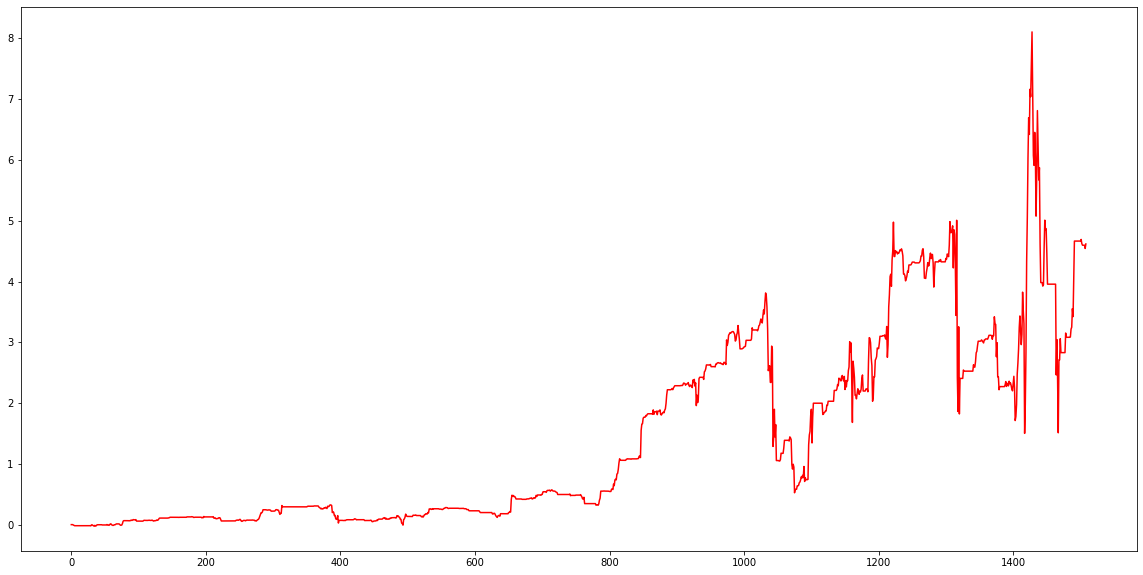

0.38689046874999994
0.38689046874999994
0.3675459453124999
0.3675459453124999
0.3675459453124999
iter 70. reward: 2.755481

total gained 2768.404033, total investment 2.768404 %


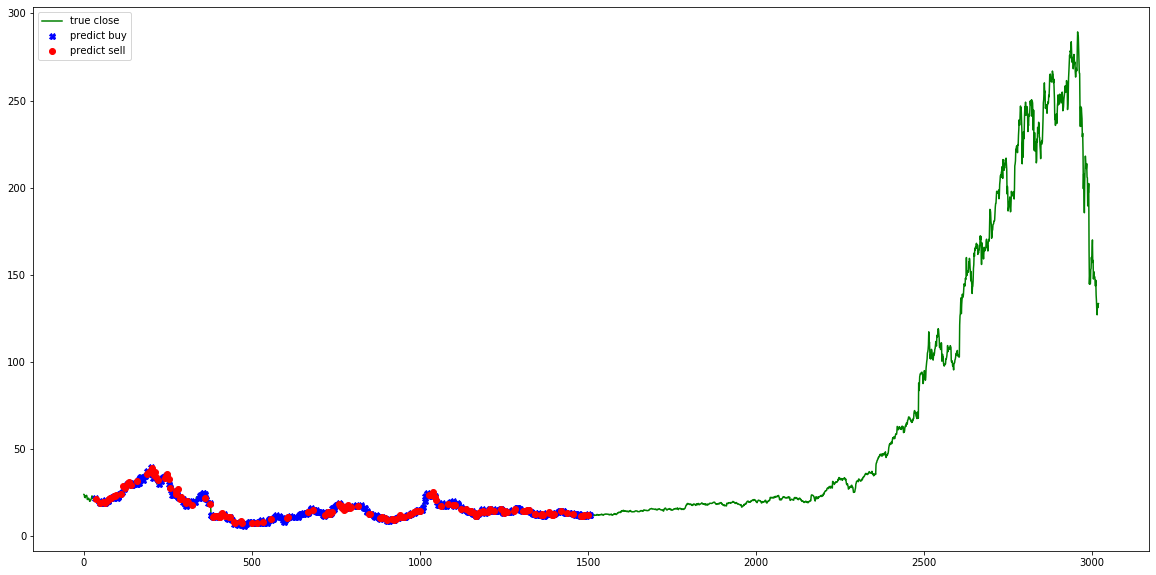

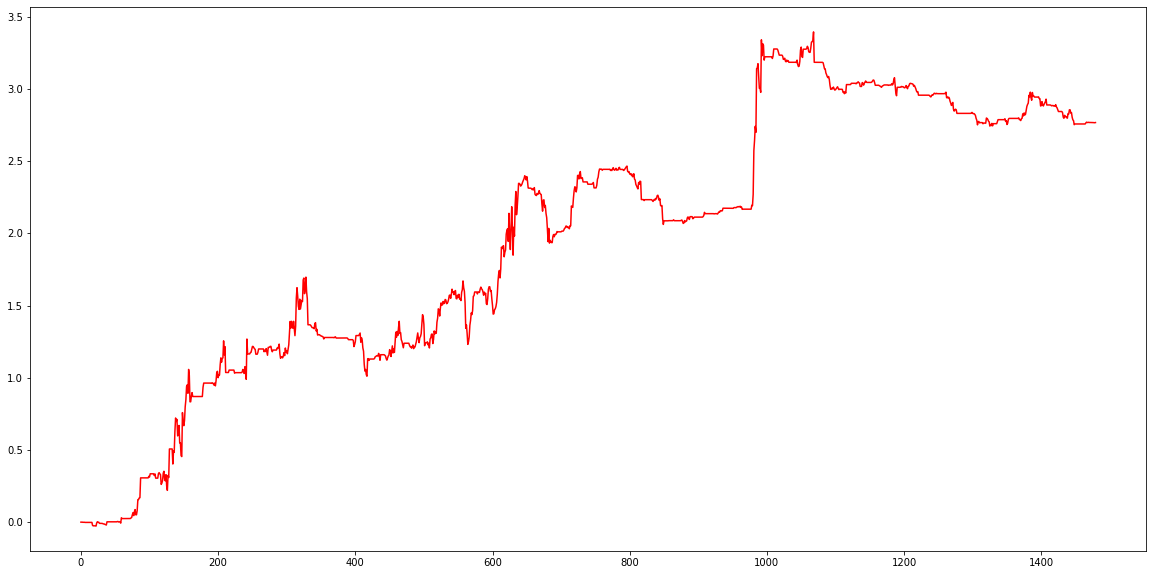


total gained 6093.664650, total investment 6.093665 %


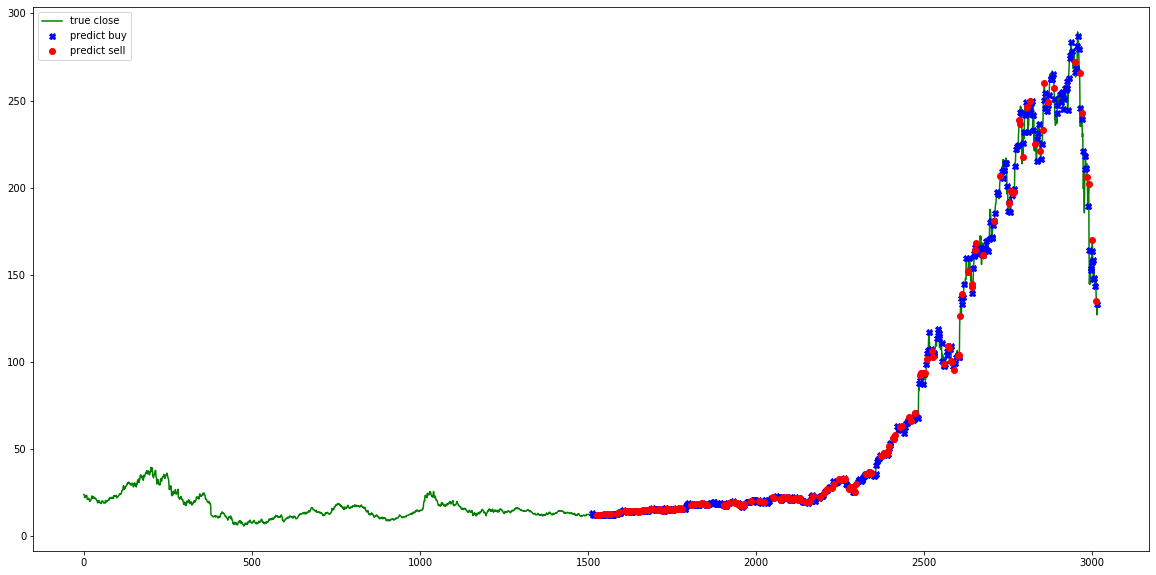

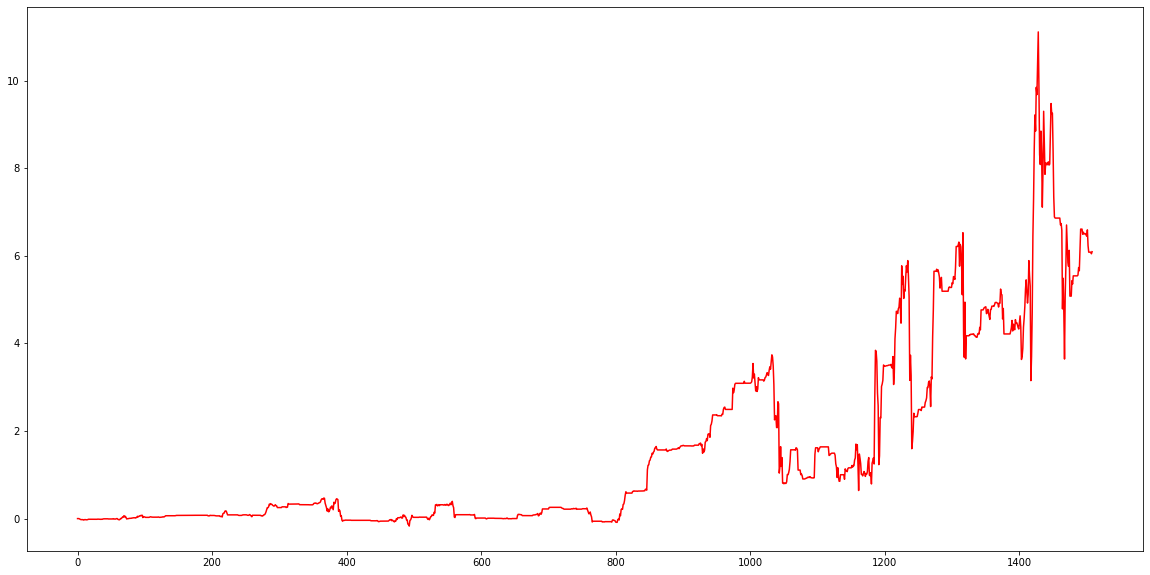

0.3675459453124999
0.34916864804687486
0.34916864804687486
0.34916864804687486
0.34916864804687486
iter 75. reward: 2.665401

total gained 2883.647604, total investment 2.883648 %


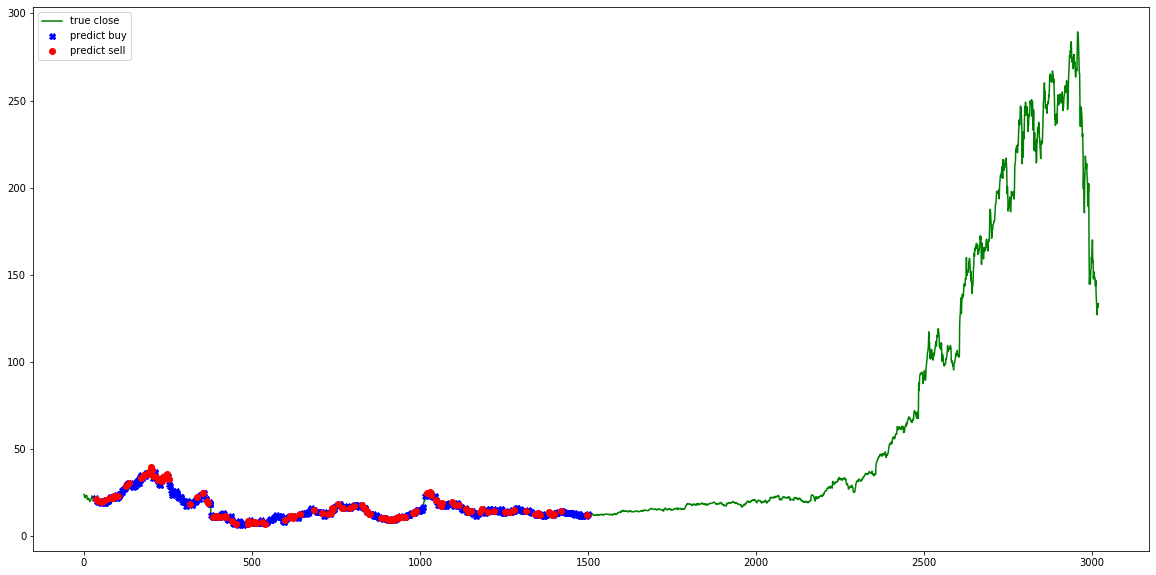

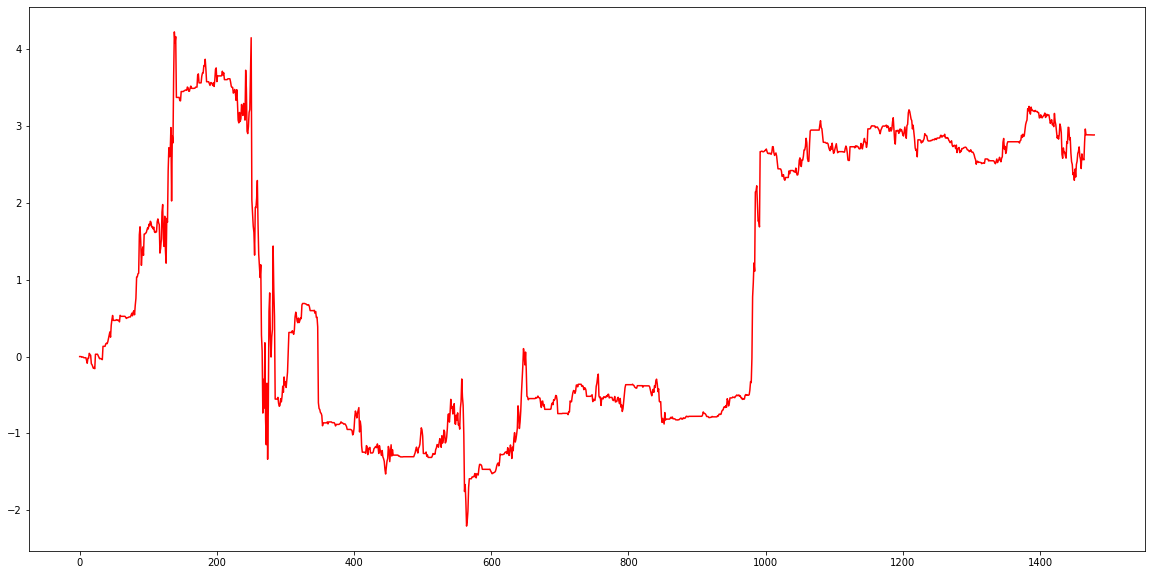


total gained 5728.935350, total investment 5.728935 %


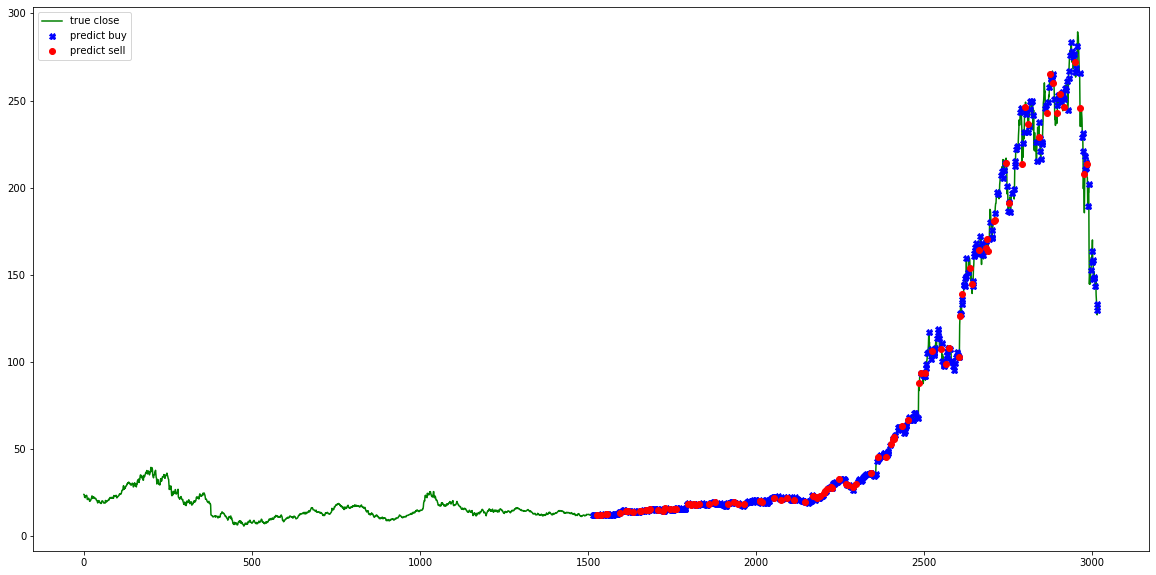

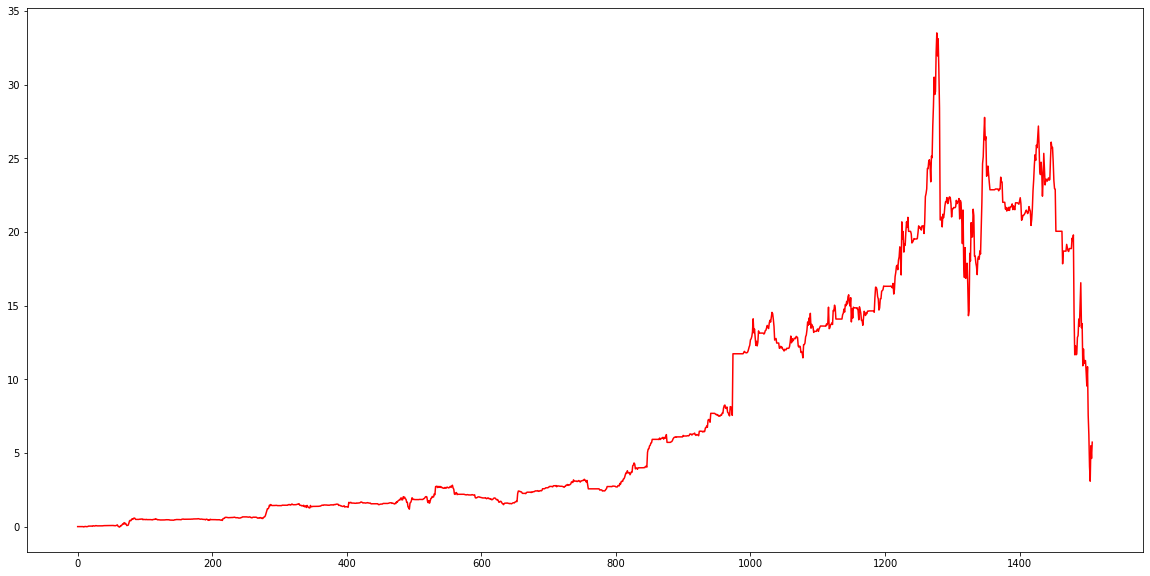

0.3317102156445311
0.3317102156445311
0.3317102156445311
0.3317102156445311
0.3317102156445311
iter 80. reward: 5.245321

total gained 5292.189667, total investment 5.292190 %


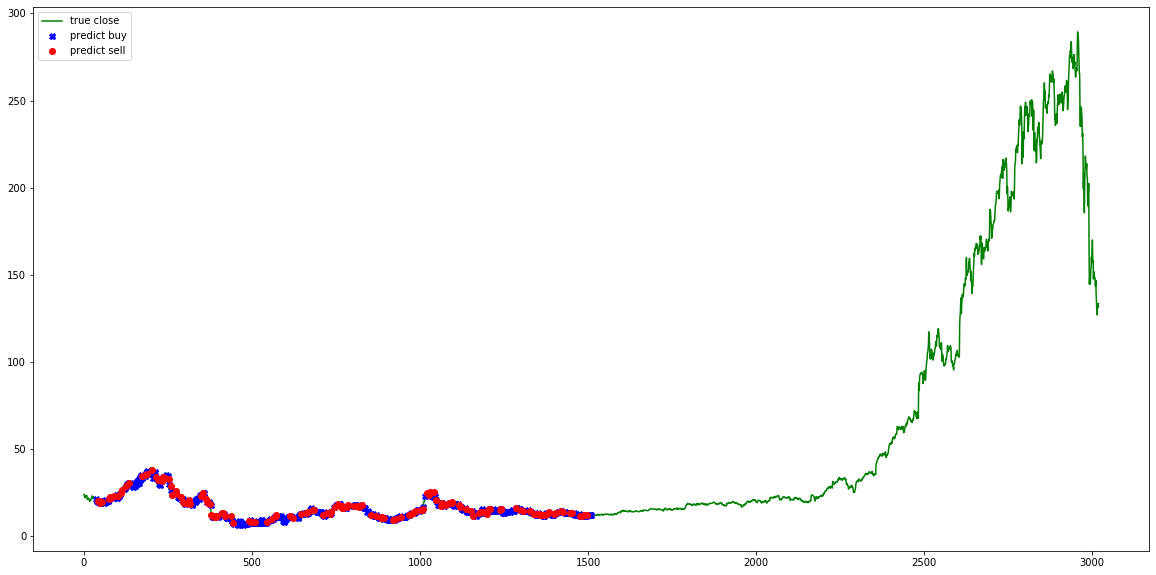

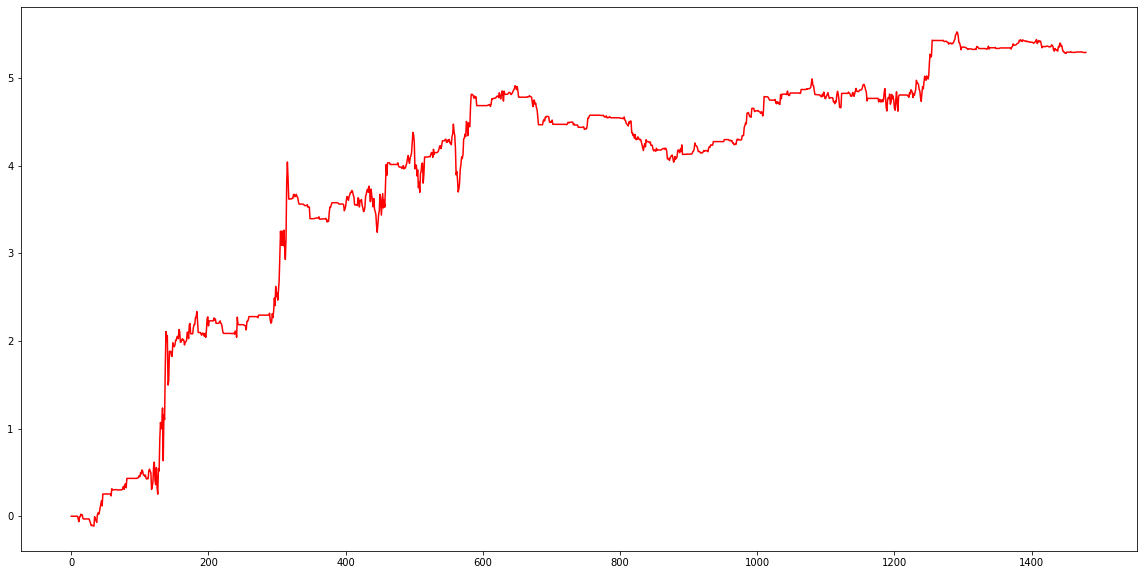


total gained -160.106850, total investment -0.160107 %


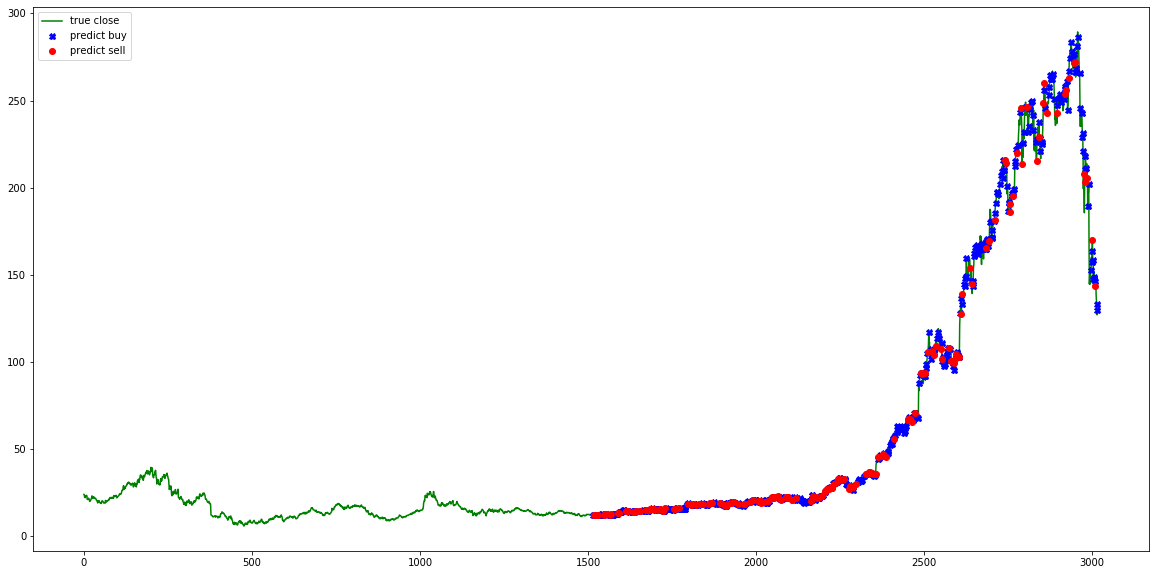

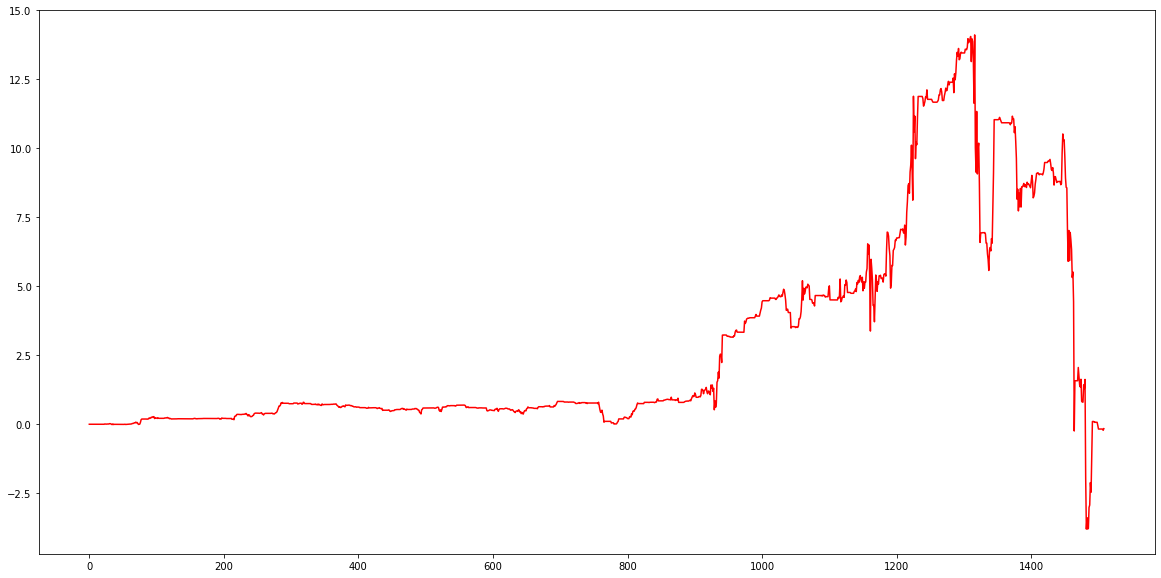

0.3317102156445311
0.31512470486230454
0.31512470486230454
0.2993684696191893
0.2993684696191893
iter 85. reward: 4.130928

total gained 4285.285432, total investment 4.285285 %


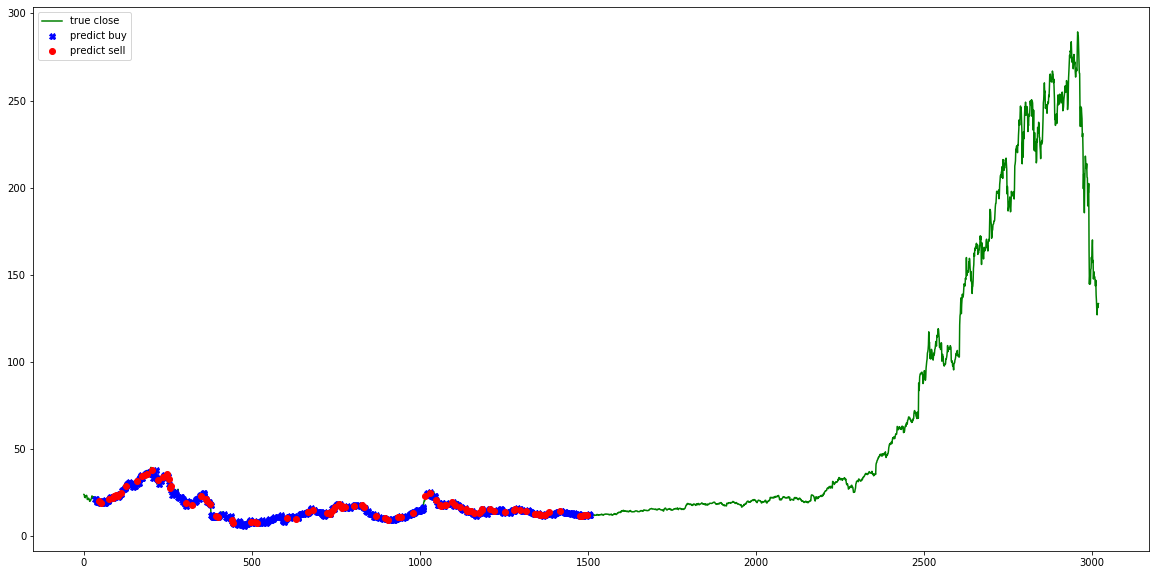

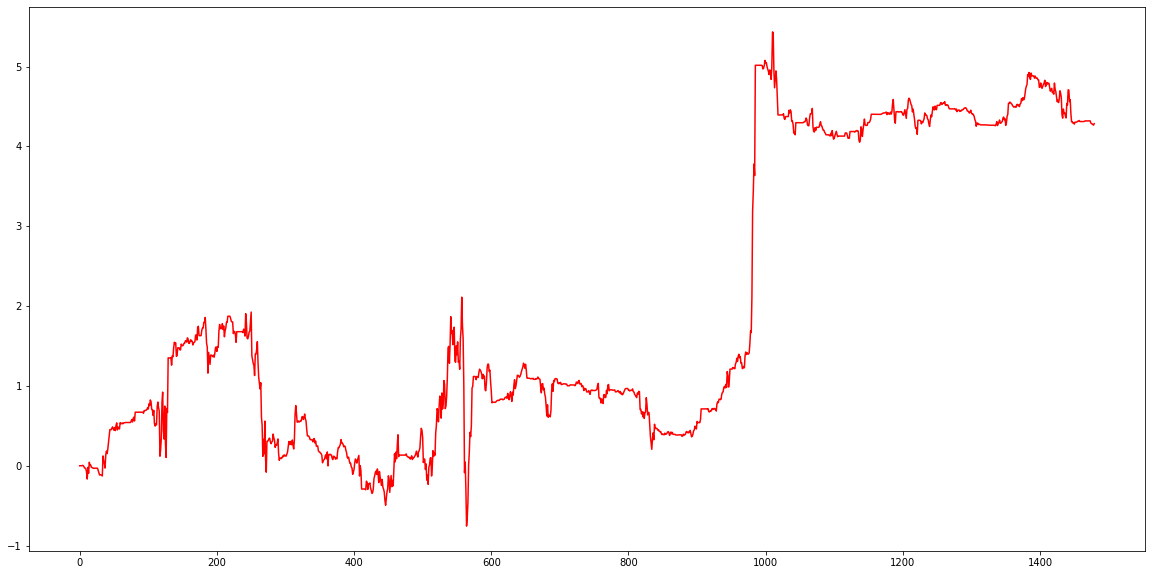


total gained -14282.880010, total investment -14.282880 %


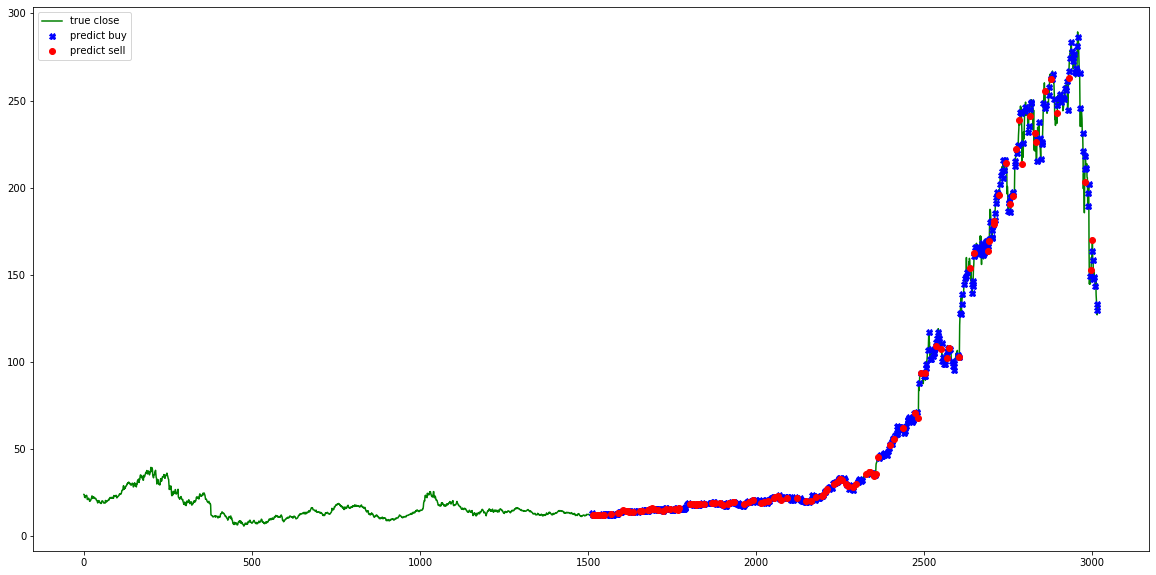

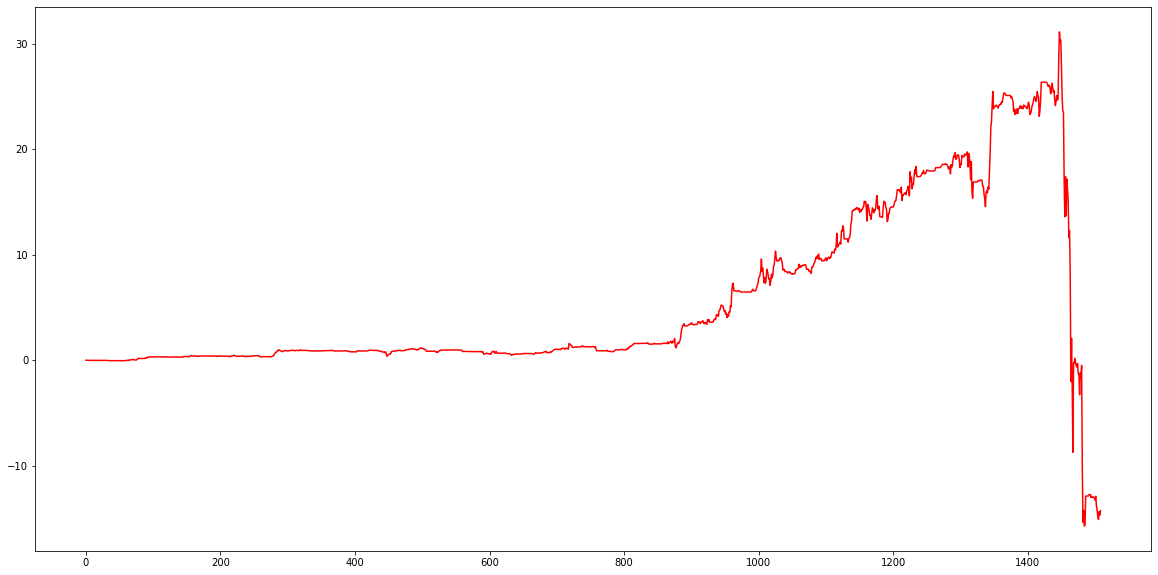

0.2993684696191893
0.2844000461382298
0.2701800438313183
0.2701800438313183
0.2701800438313183
iter 90. reward: 4.159224

total gained 4525.176770, total investment 4.525177 %


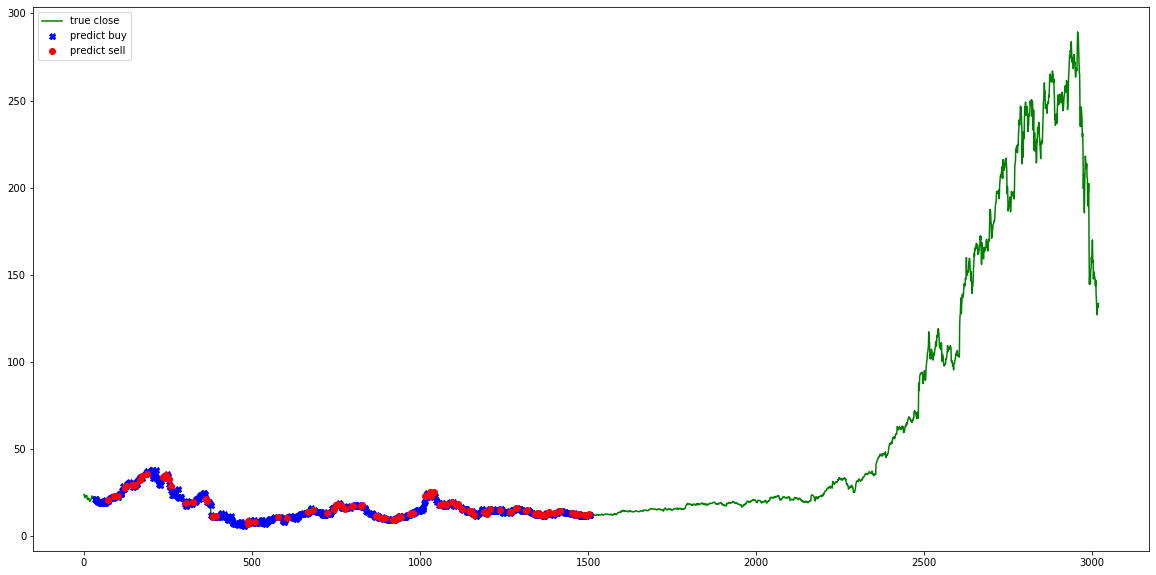

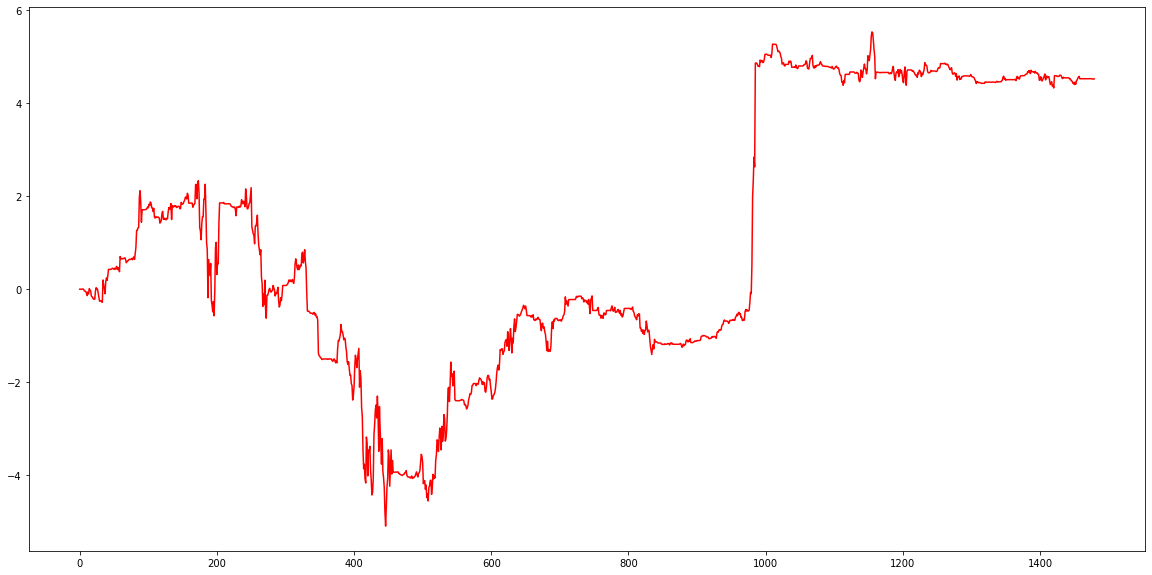


total gained -13432.194640, total investment -13.432195 %


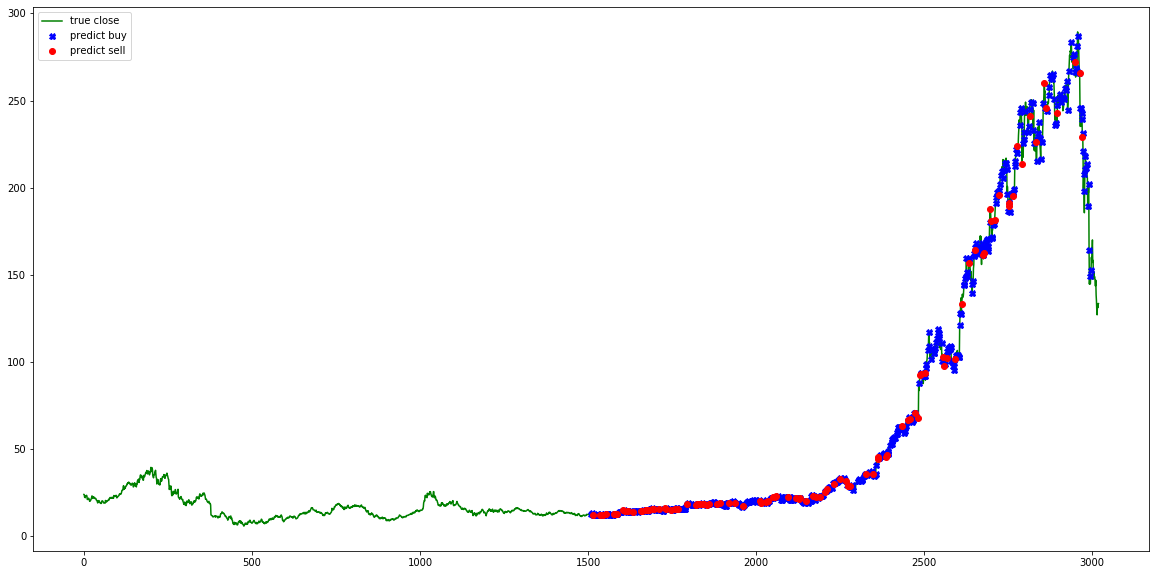

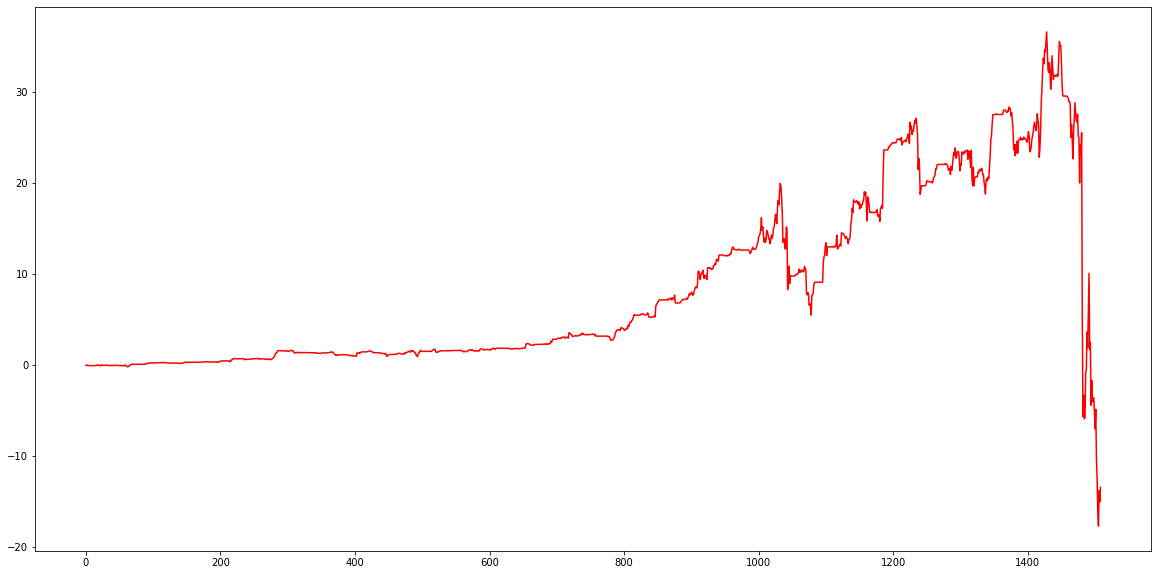

0.2701800438313183
0.2701800438313183
0.2701800438313183
0.25667104163975235
0.25667104163975235
iter 95. reward: 6.033143

total gained 8090.551532, total investment 8.090552 %


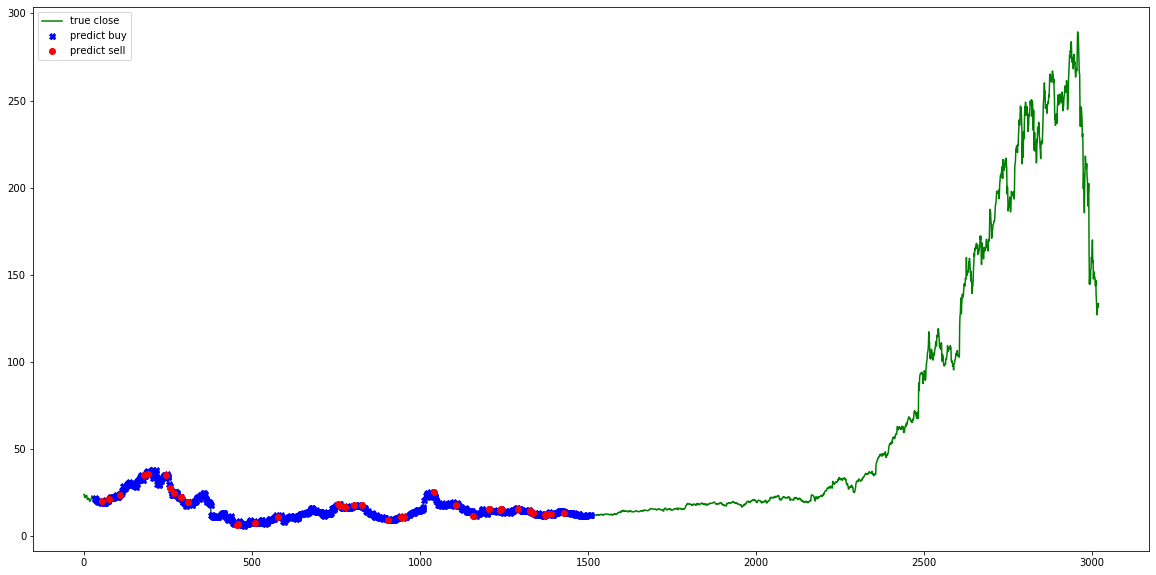

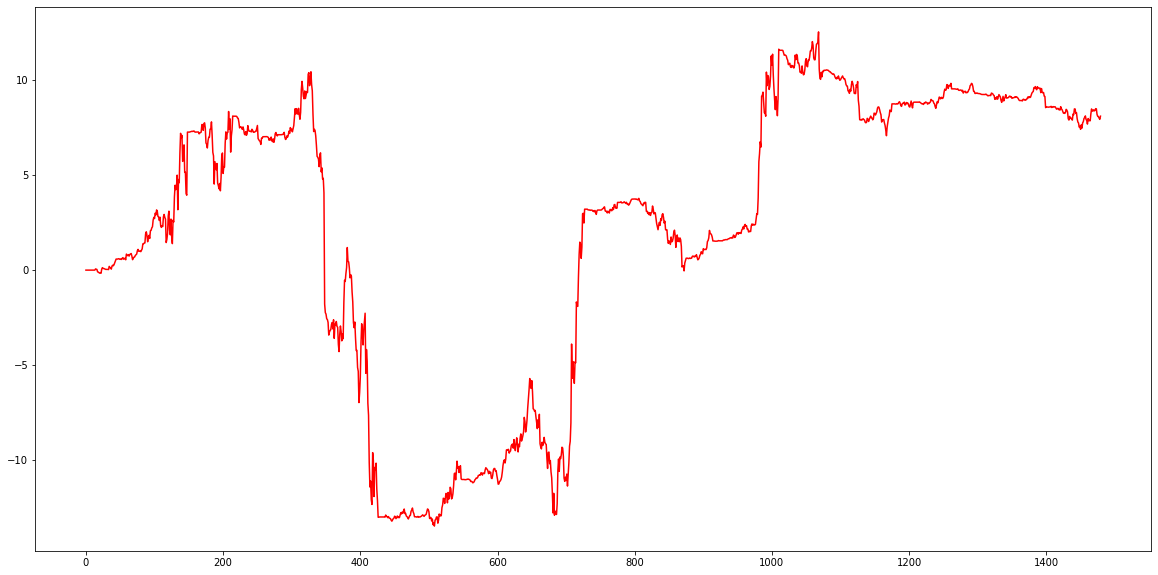


total gained 70817.005310, total investment 70.817005 %


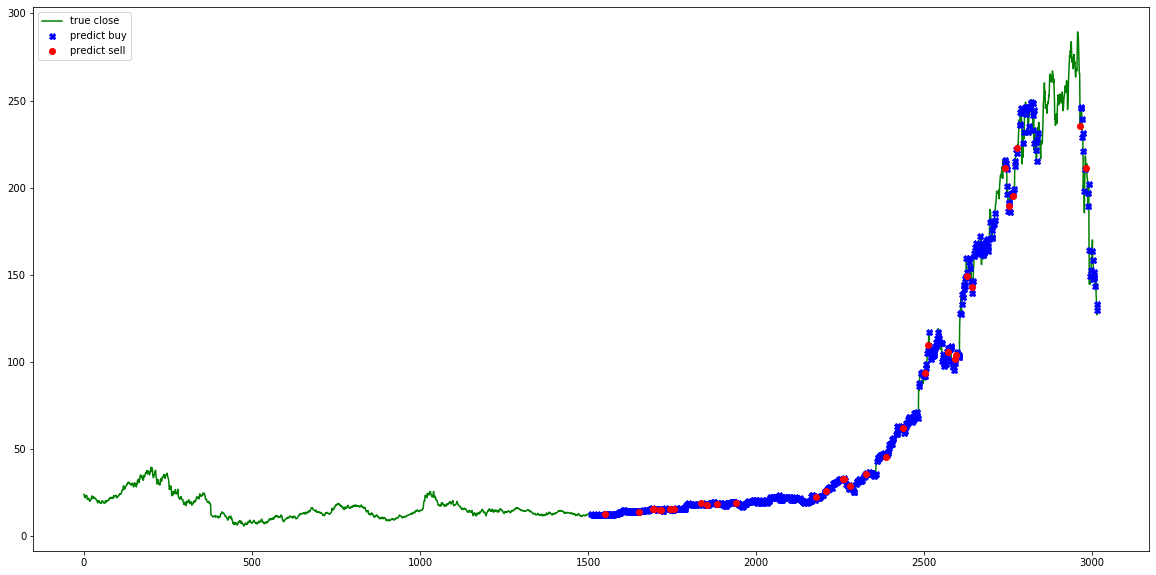

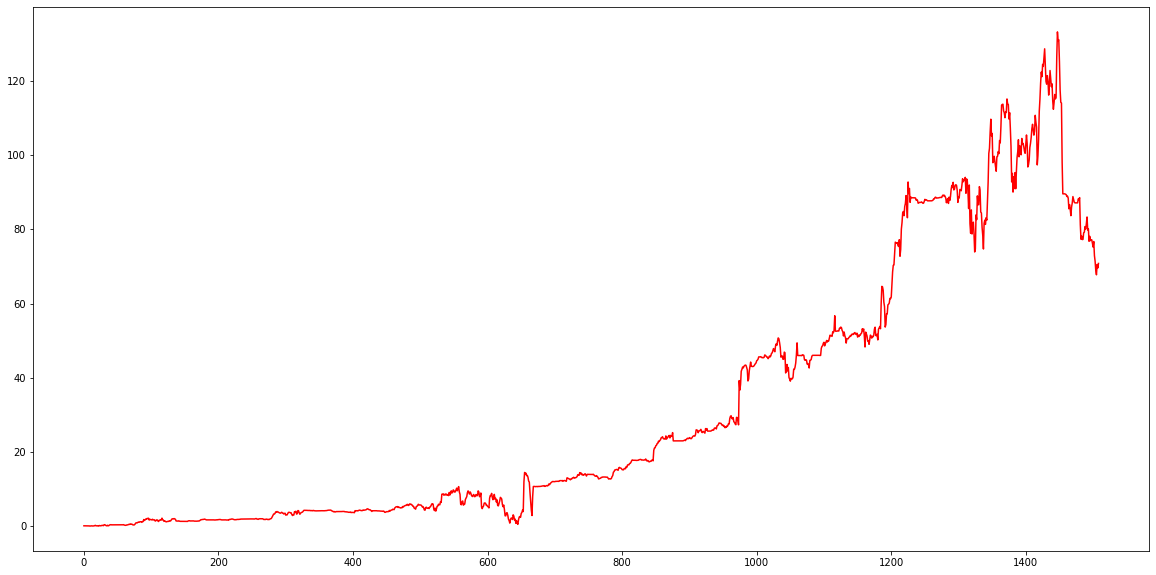

0.25667104163975235
0.25667104163975235
0.25667104163975235
0.25667104163975235
0.25667104163975235
iter 100. reward: 14.460338

total gained 15628.442771, total investment 15.628443 %


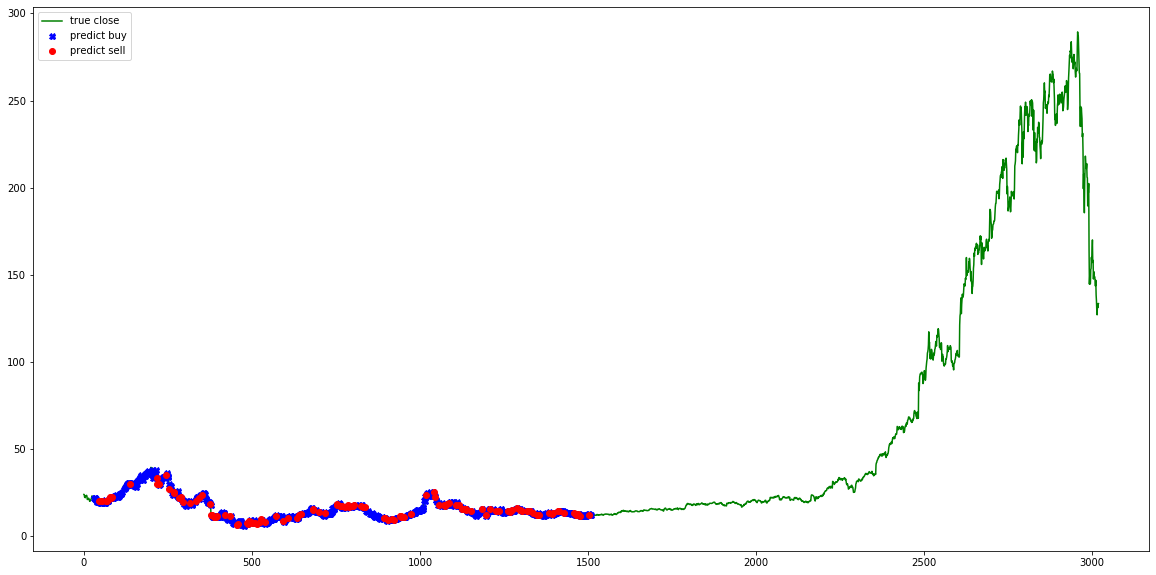

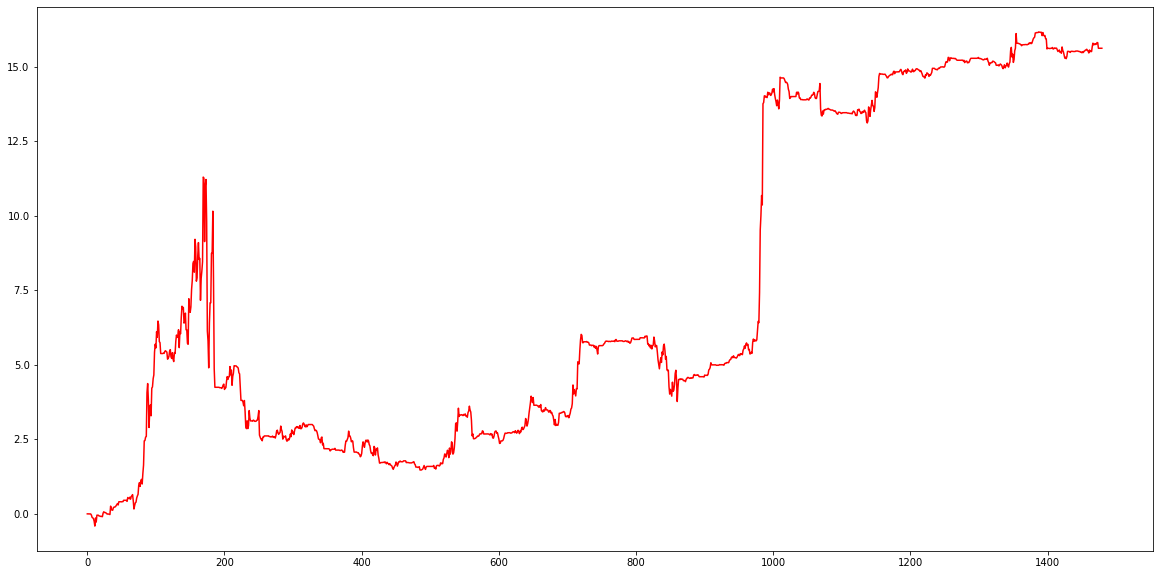


total gained 6986.305730, total investment 6.986306 %


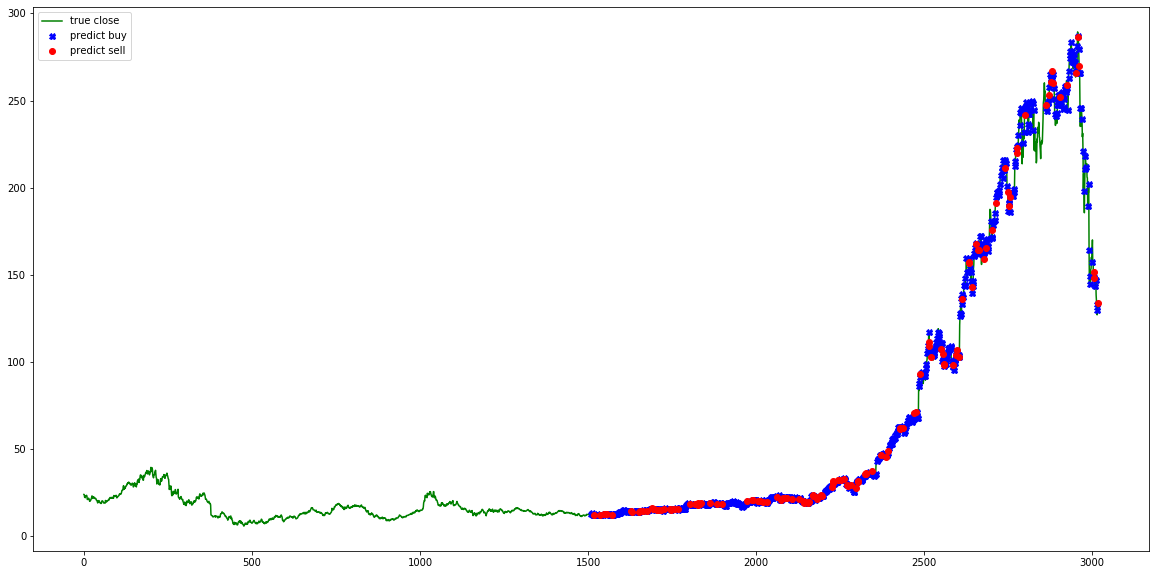

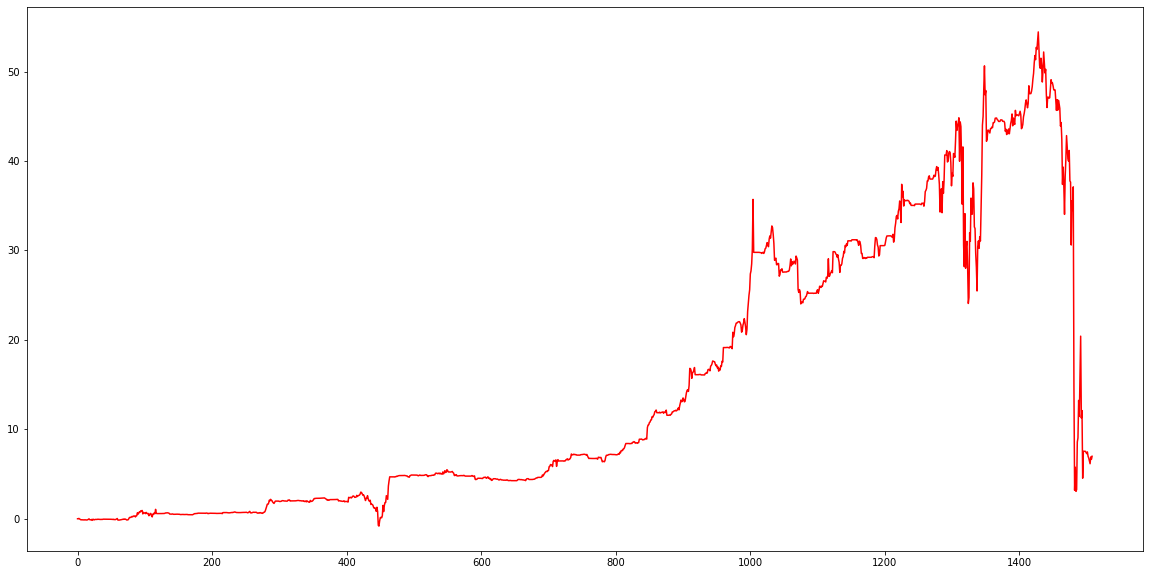

0.25667104163975235
0.25667104163975235
0.25667104163975235
0.5
0.475
iter 105. reward: 20.058119

total gained 20681.758634, total investment 20.681759 %


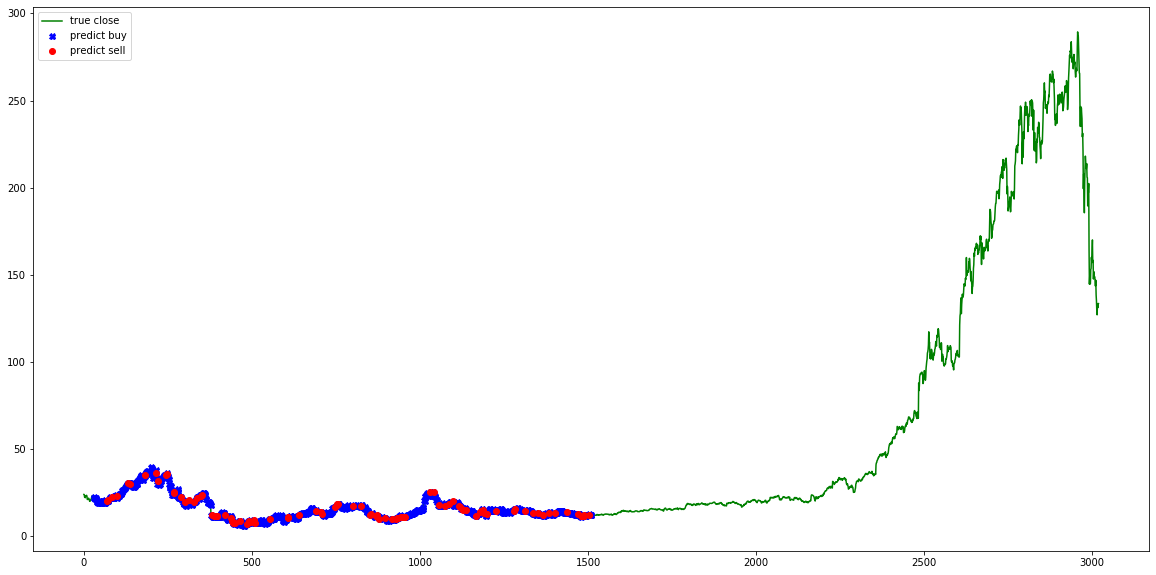

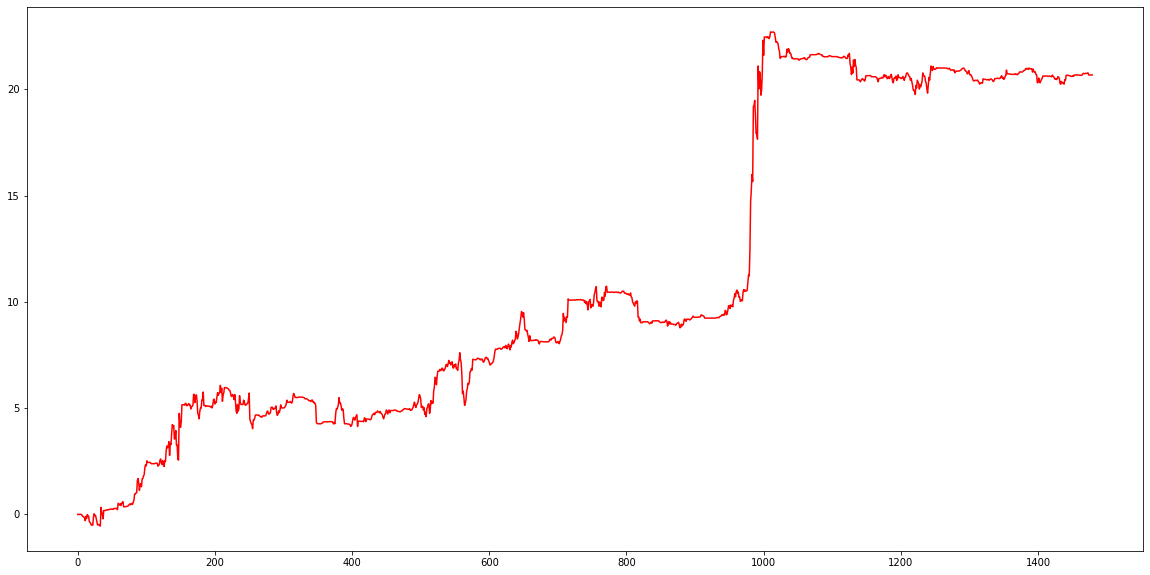


total gained 56758.586680, total investment 56.758587 %


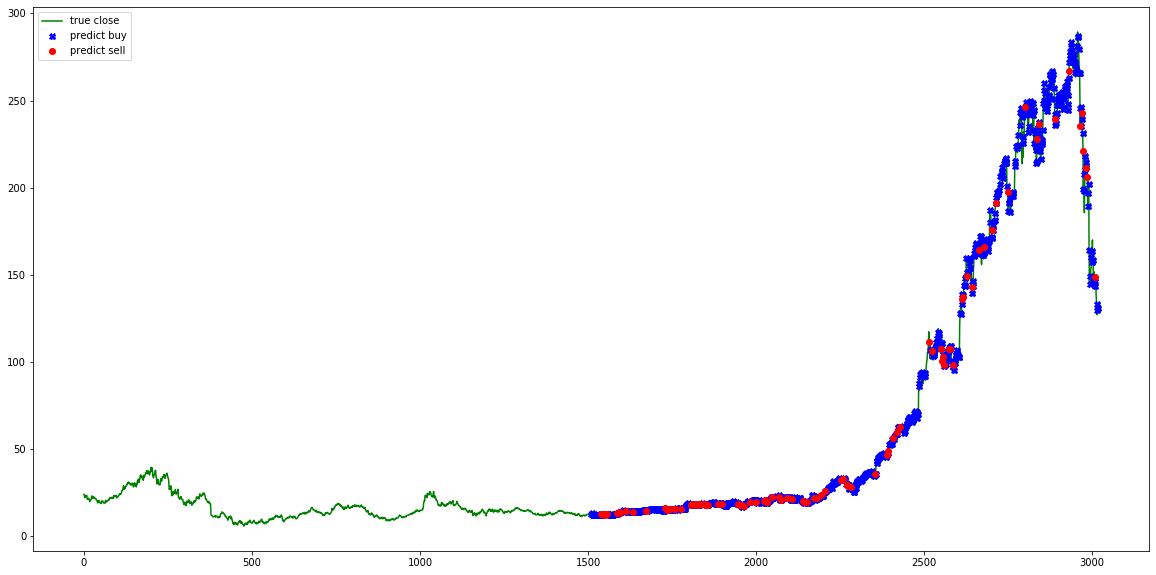

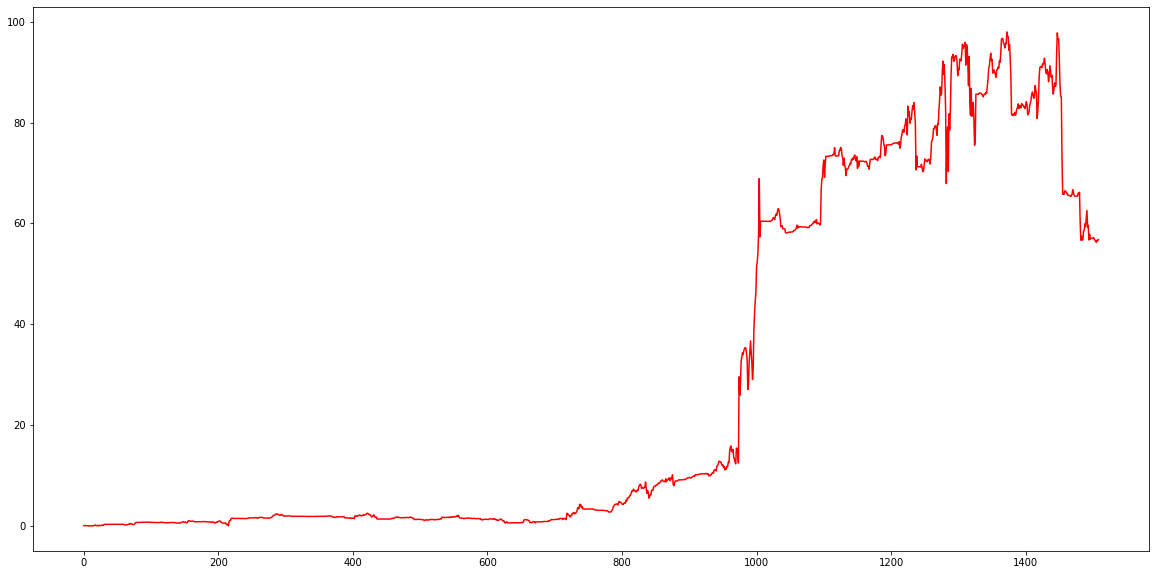

0.475
0.475
0.475
0.475
0.475
iter 110. reward: 18.958818

total gained 24778.256569, total investment 24.778257 %


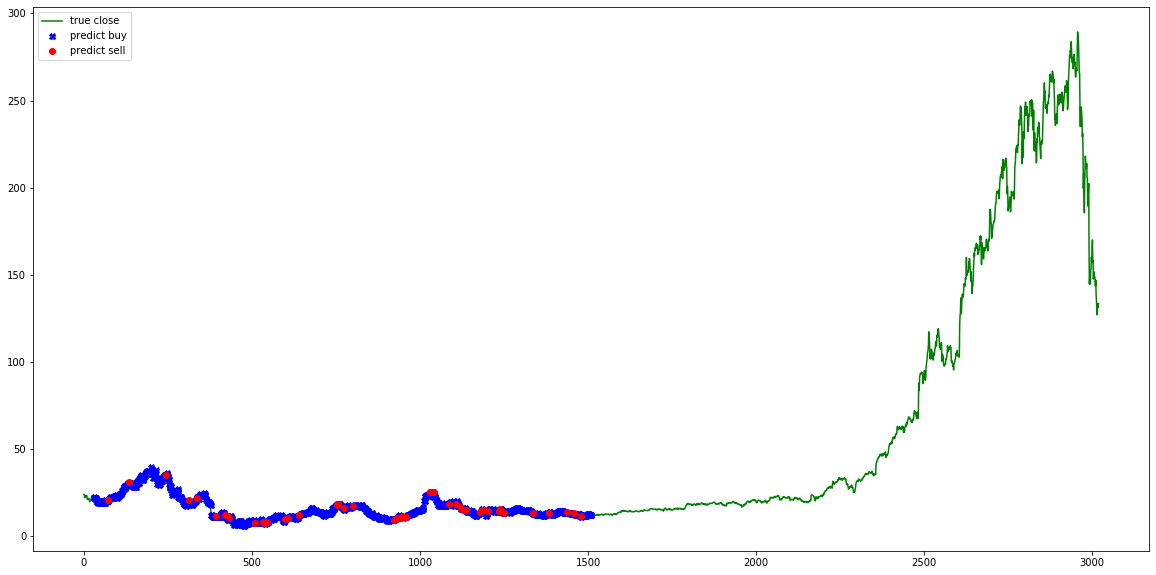

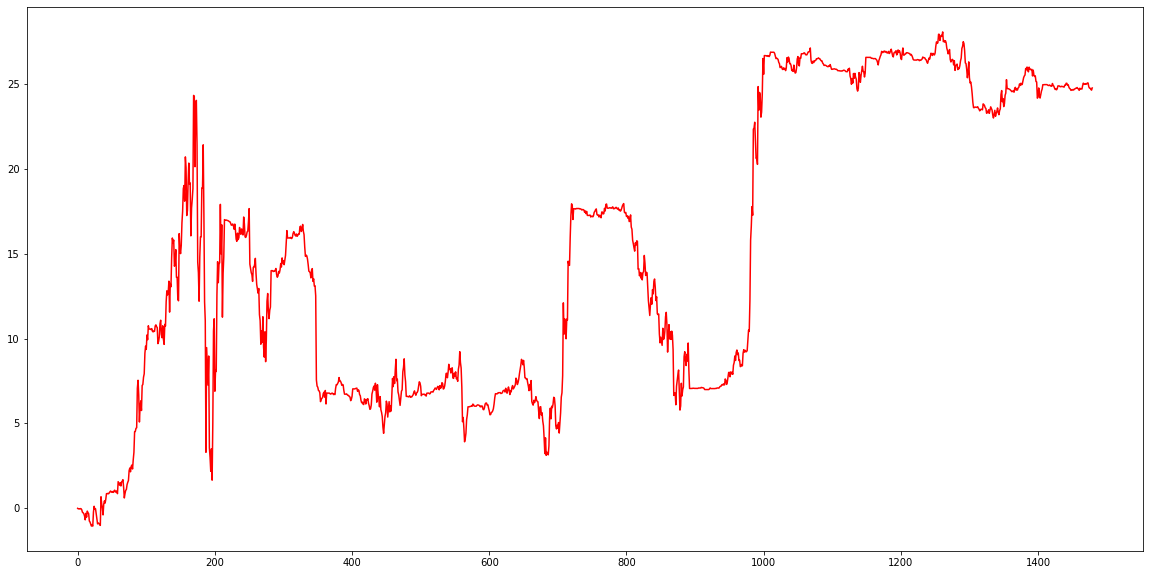


total gained 132397.693820, total investment 132.397694 %


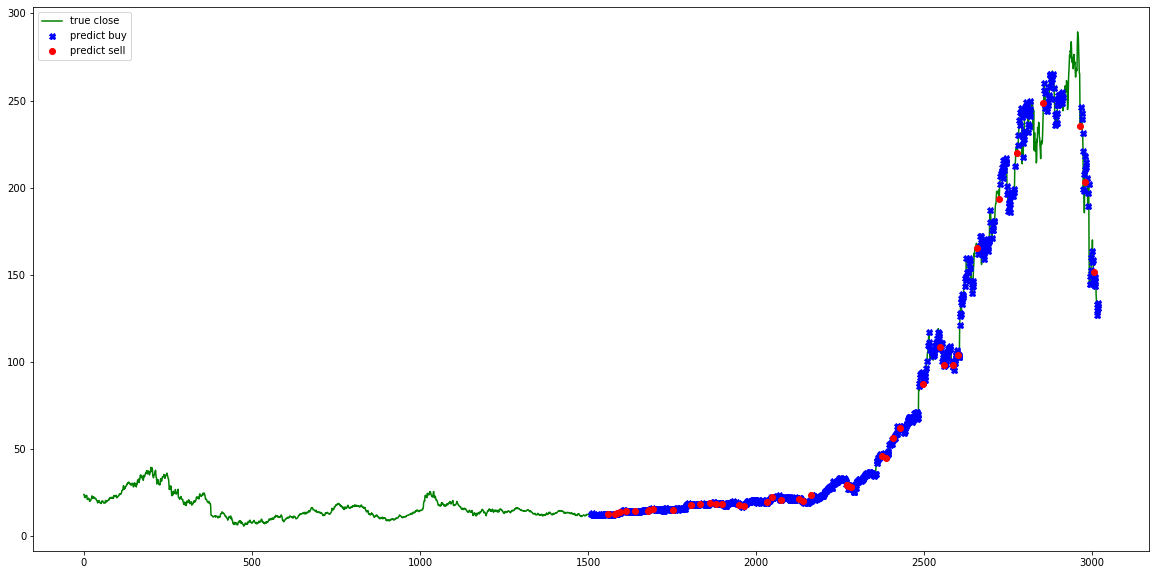

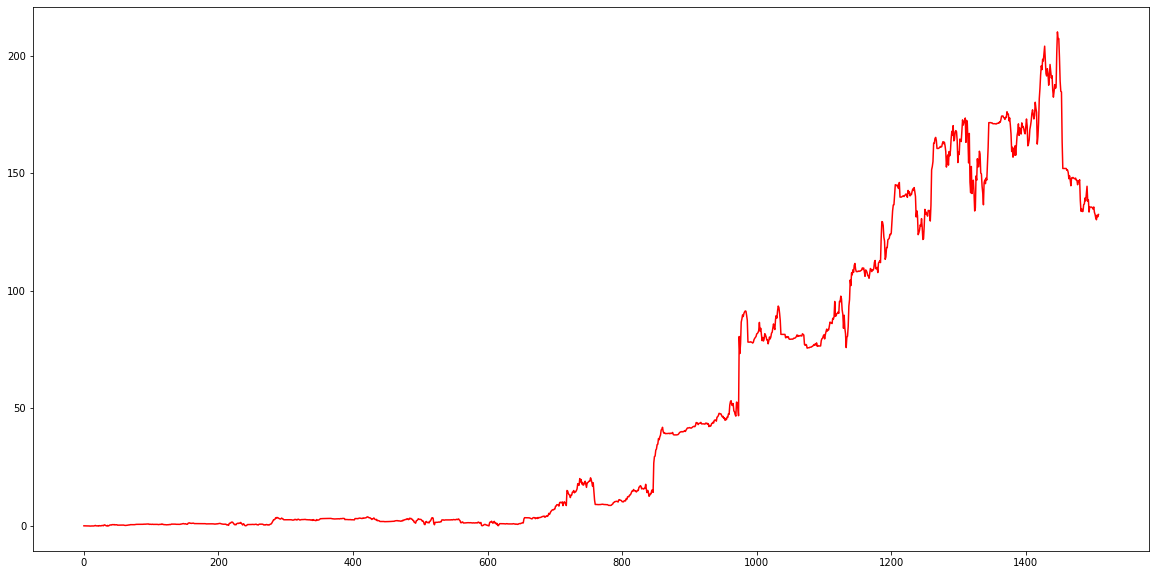

0.45125
0.42868749999999994
0.40725312499999994
0.40725312499999994
0.40725312499999994
iter 115. reward: 18.141939

total gained 19068.881707, total investment 19.068882 %


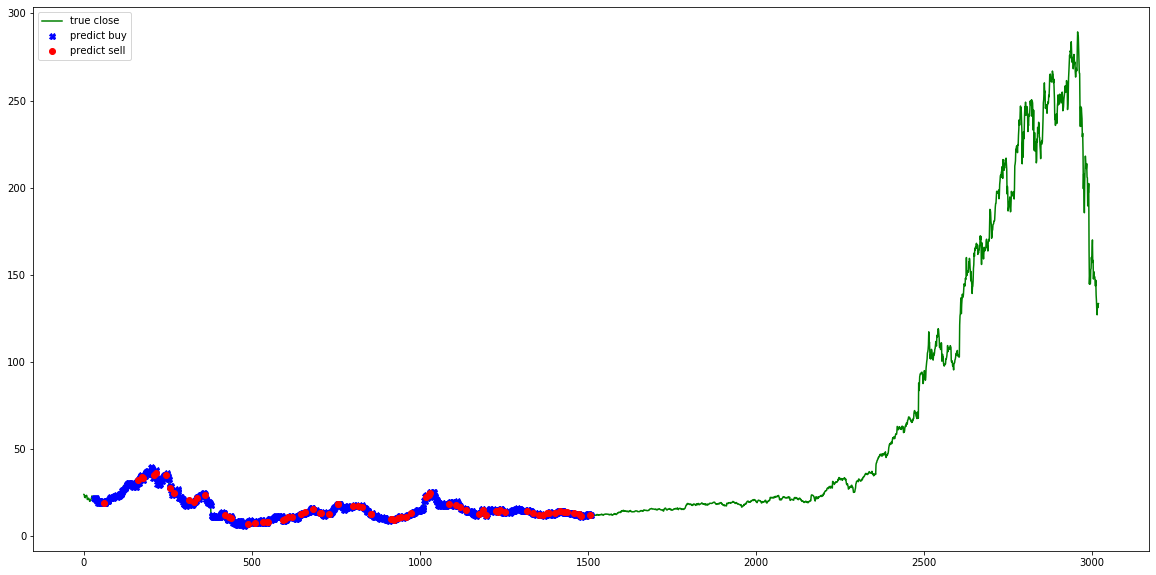

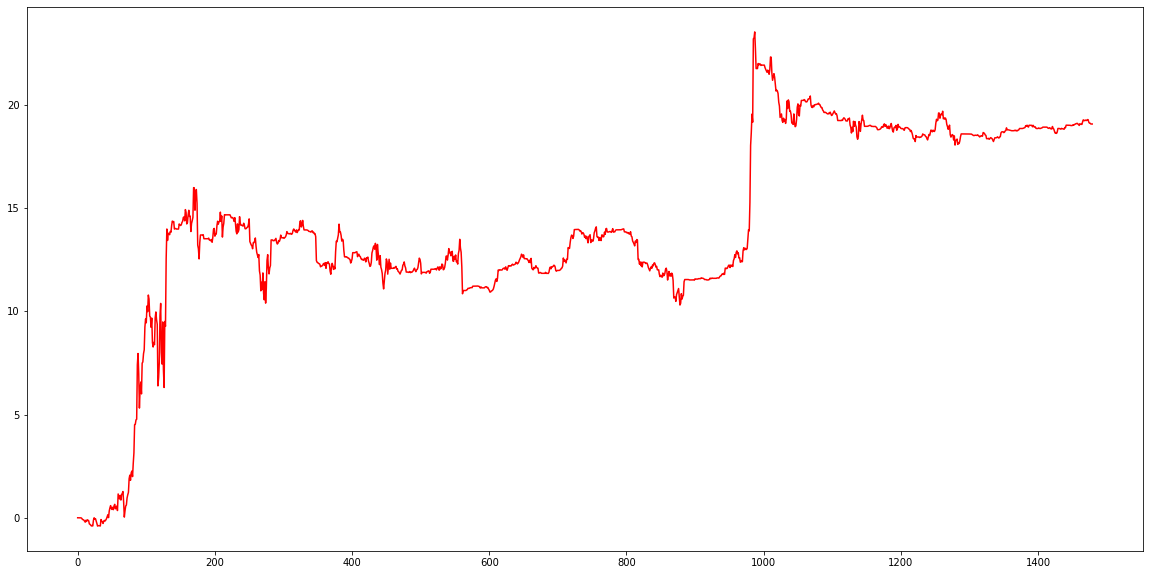


total gained 9407.580170, total investment 9.407580 %


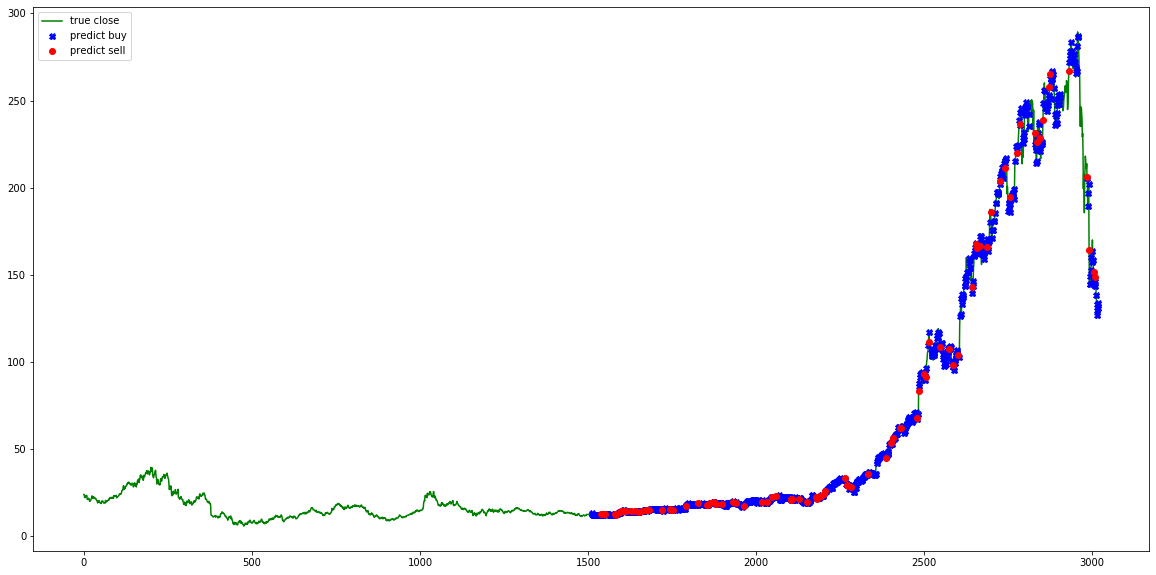

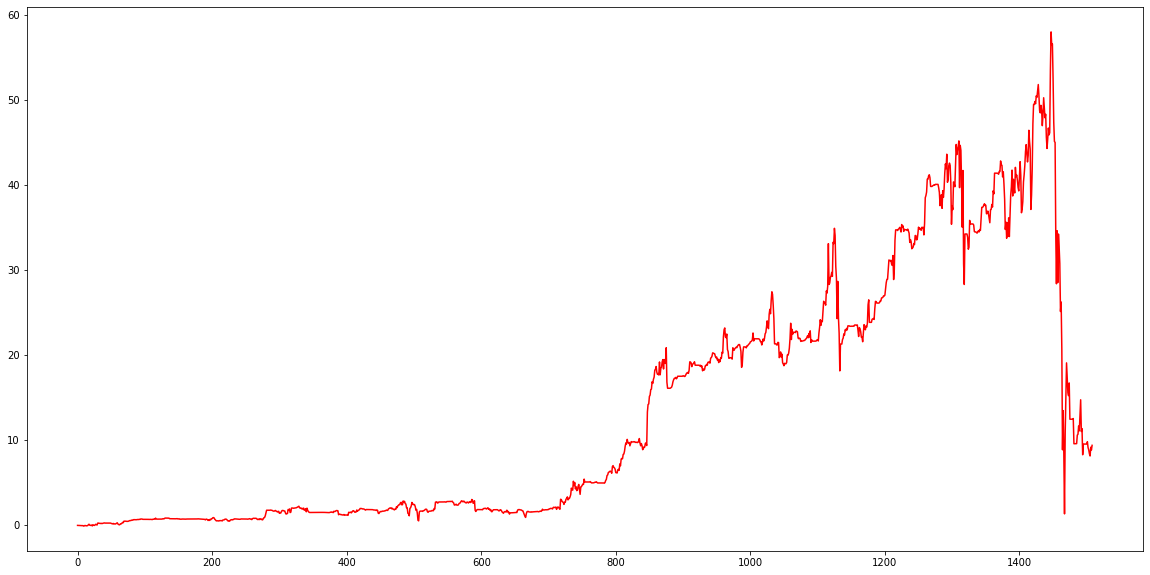

0.40725312499999994
0.40725312499999994
0.40725312499999994
0.40725312499999994
0.40725312499999994
iter 120. reward: 16.442936

total gained 17017.925866, total investment 17.017926 %


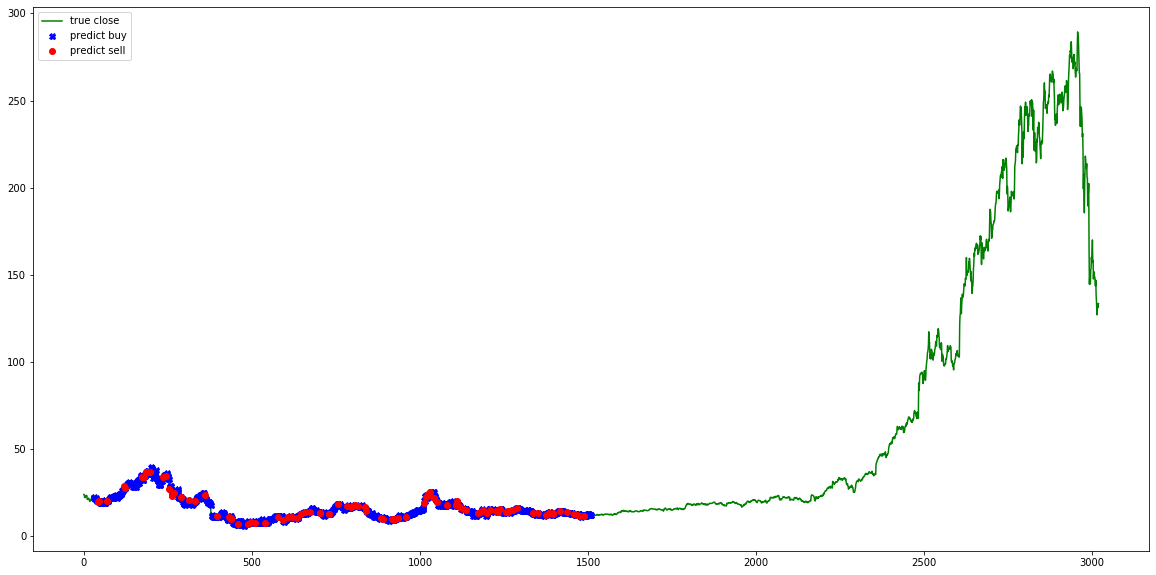

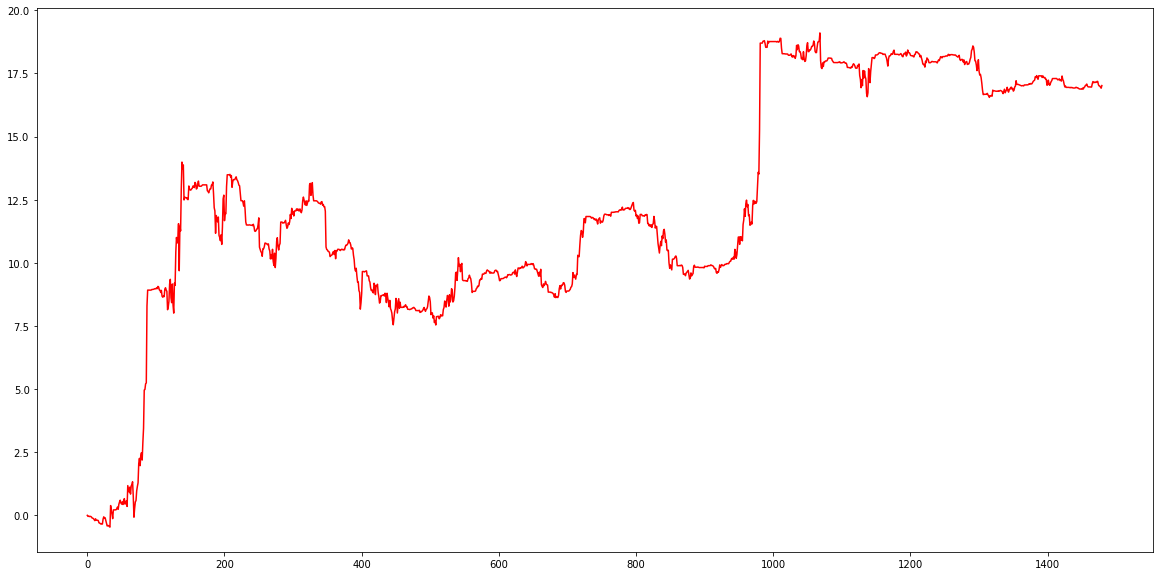


total gained 40864.036750, total investment 40.864037 %


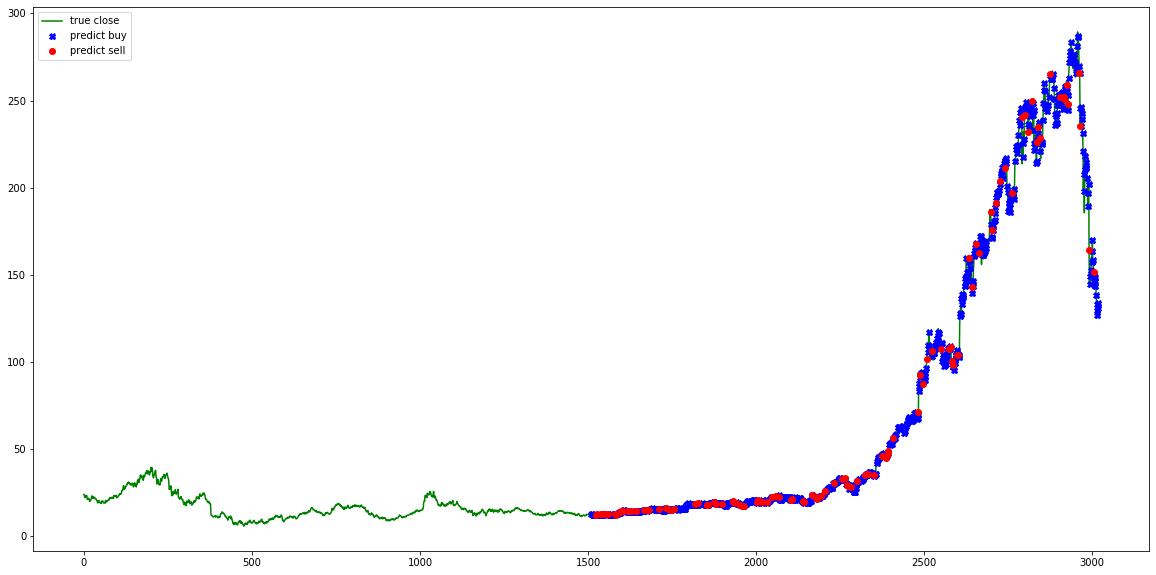

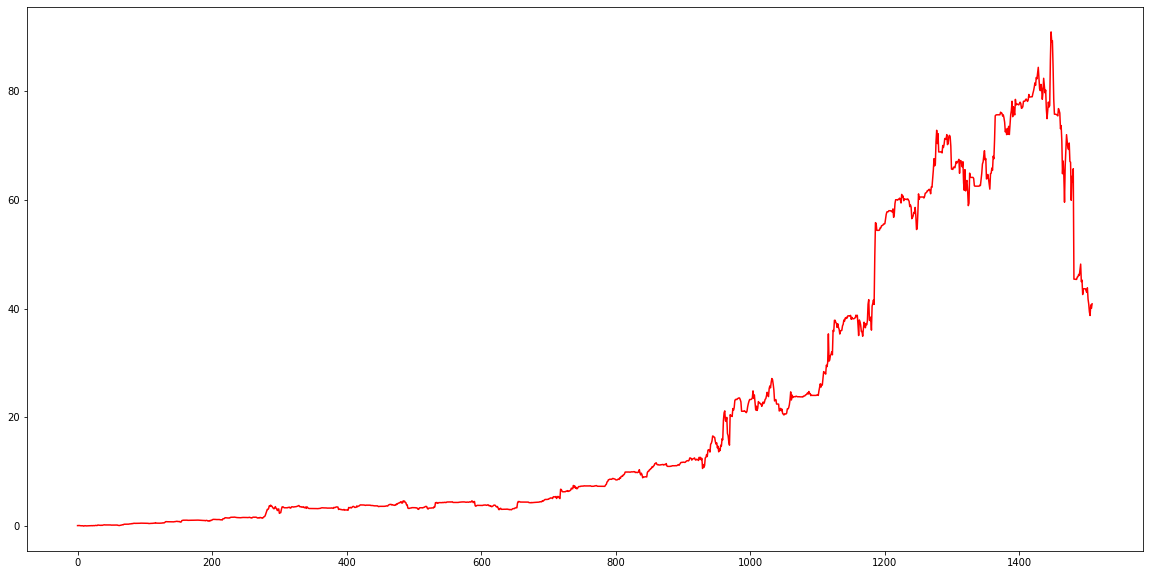

0.40725312499999994
0.40725312499999994
0.38689046874999994
0.38689046874999994
0.3675459453124999
iter 125. reward: 29.318656

total gained 33547.956436, total investment 33.547956 %


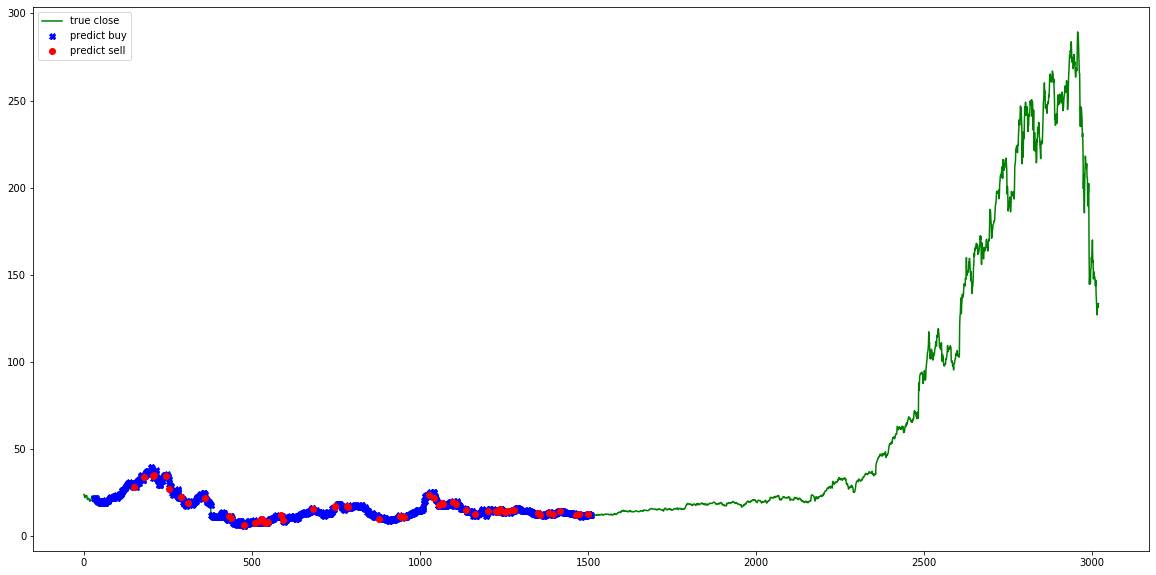

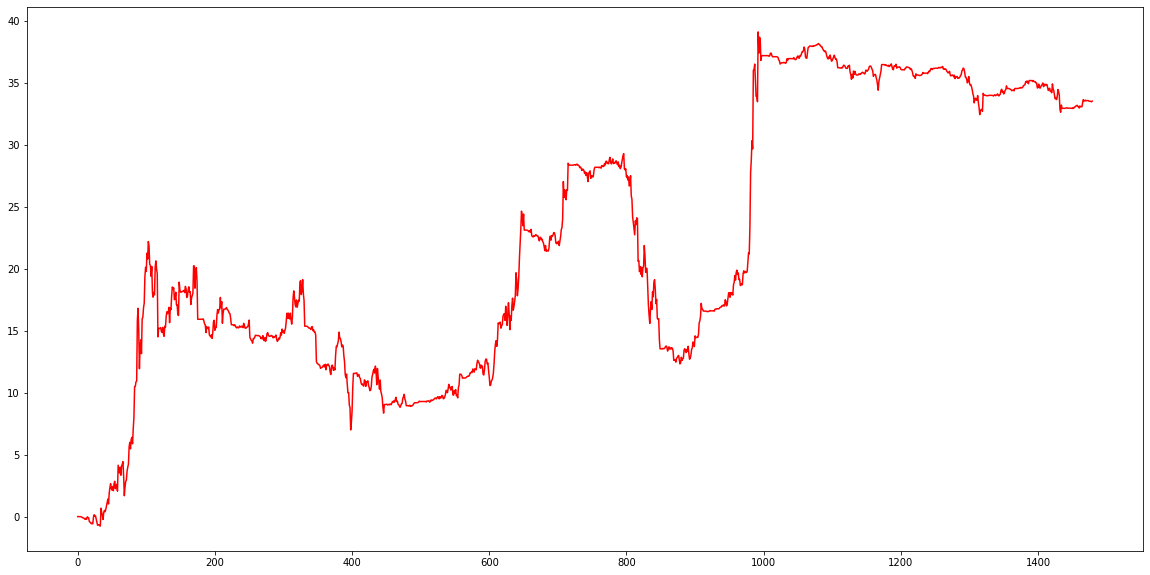


total gained 70191.354390, total investment 70.191354 %


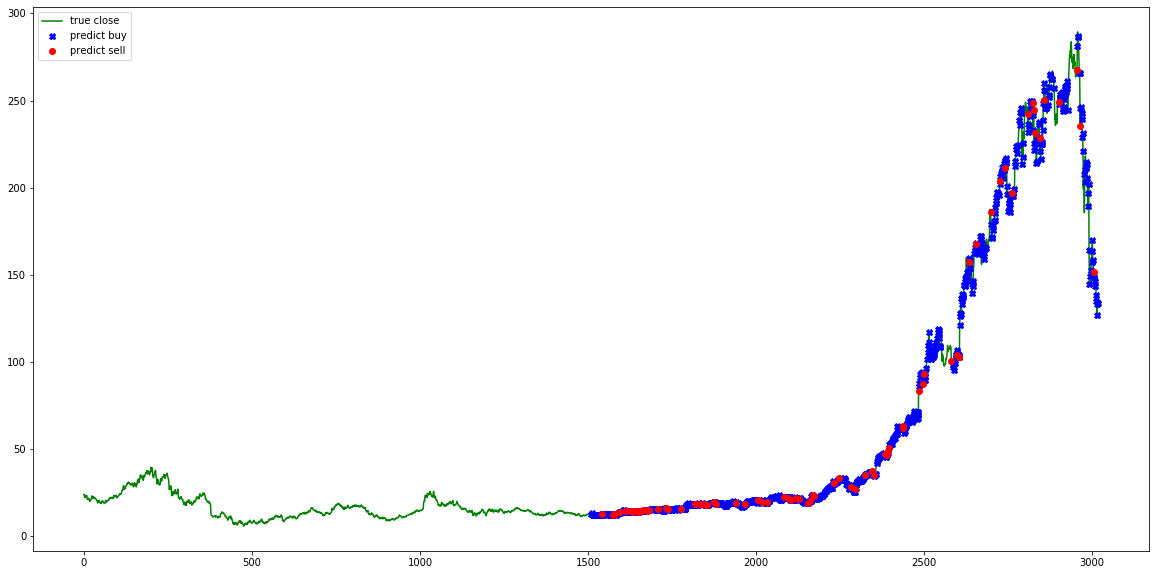

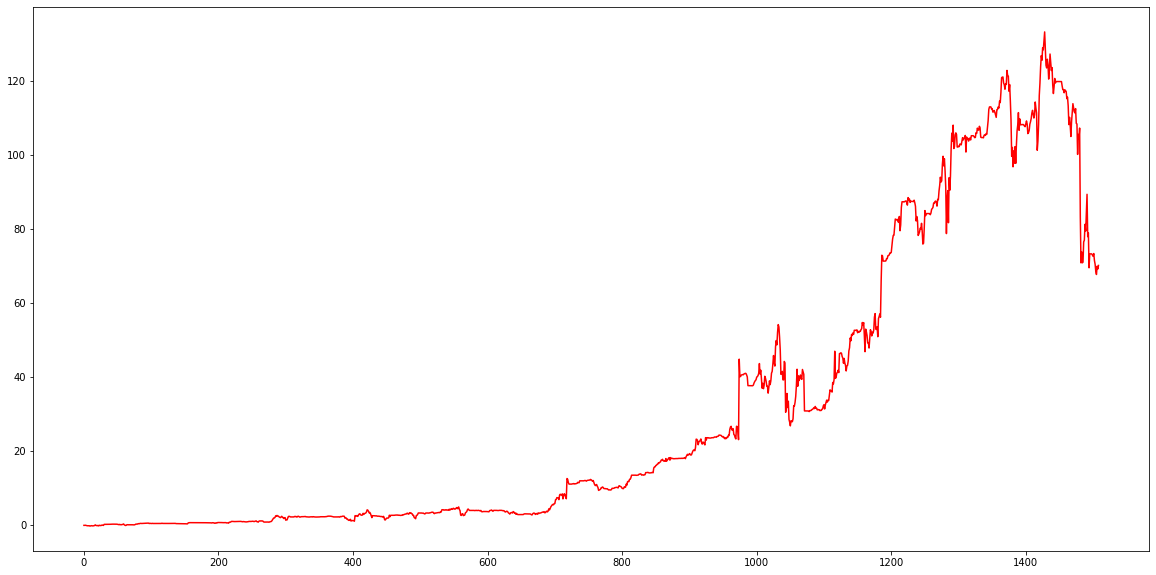

0.3675459453124999
0.3675459453124999
0.5
0.5
0.475
iter 130. reward: 30.144035

total gained 34013.909335, total investment 34.013909 %


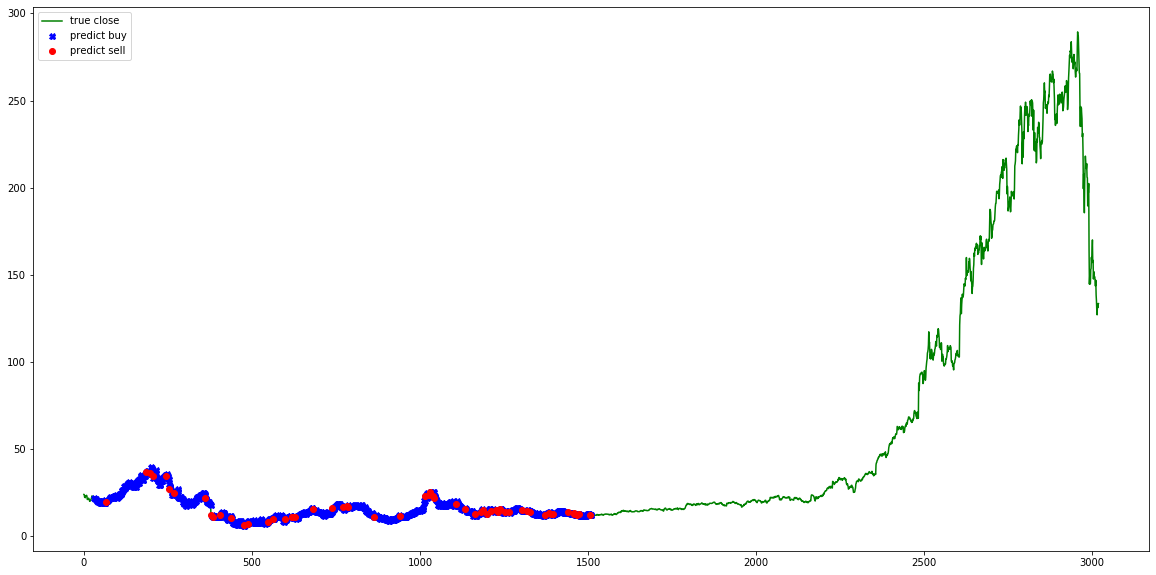

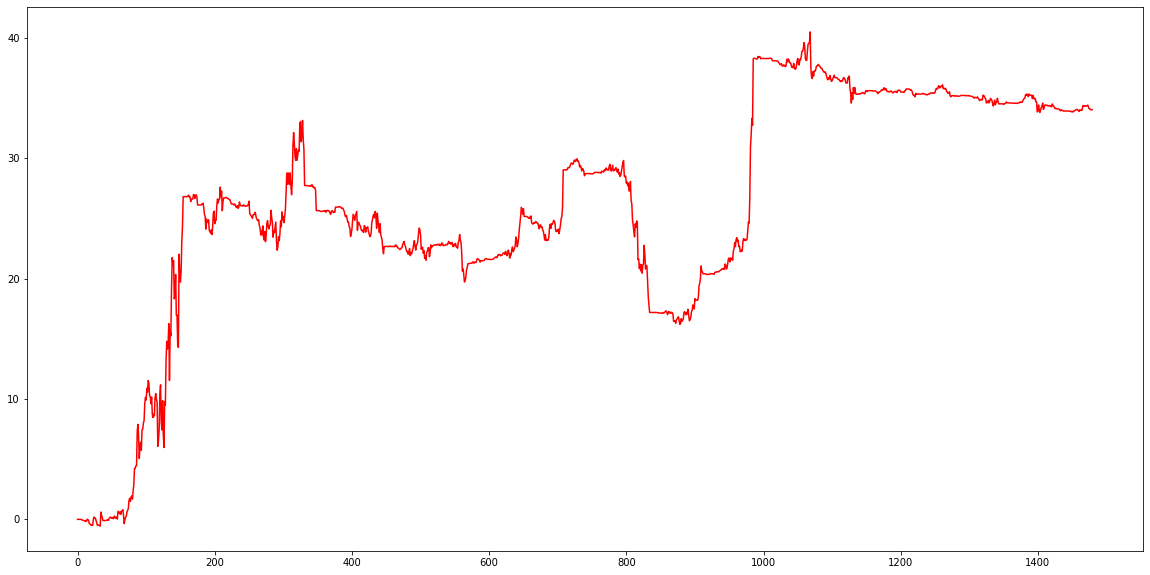


total gained 104551.601660, total investment 104.551602 %


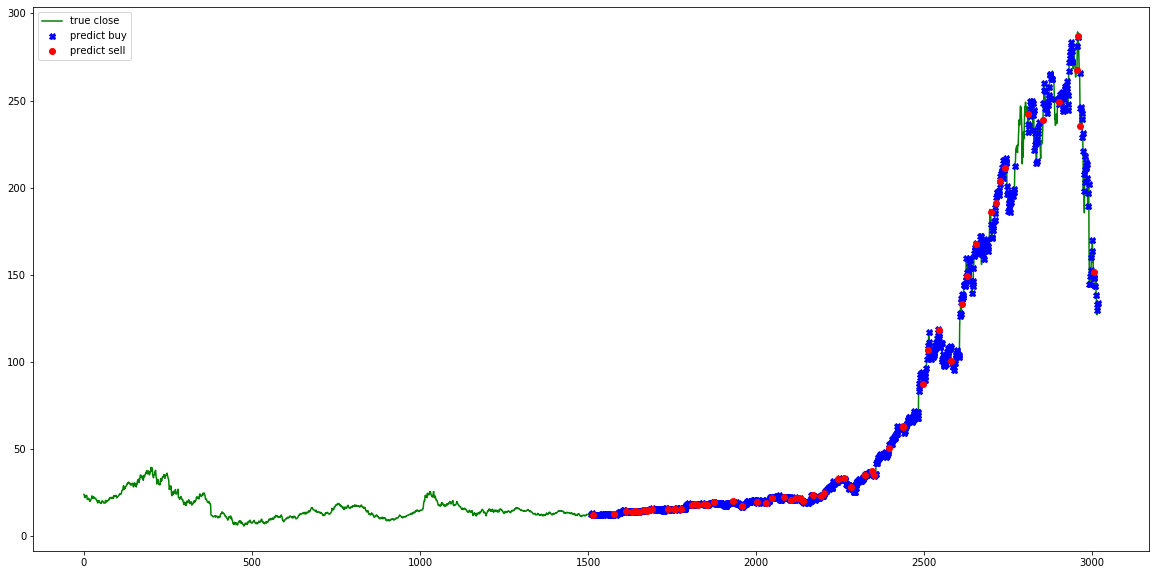

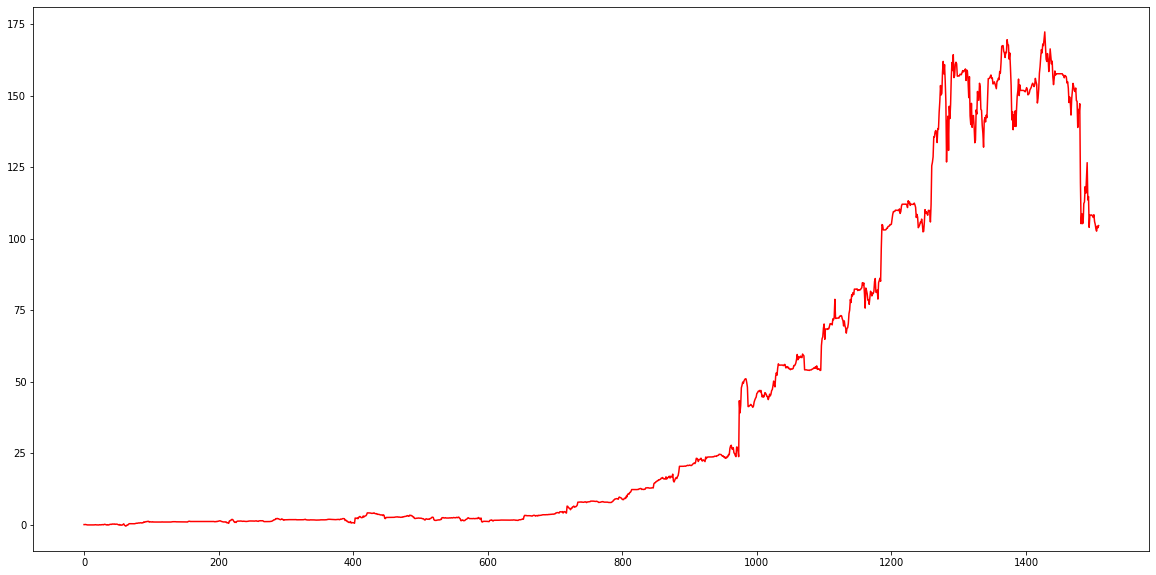

0.475
0.475
0.475
0.475
0.45125
iter 135. reward: 30.952174

total gained 35815.259773, total investment 35.815260 %


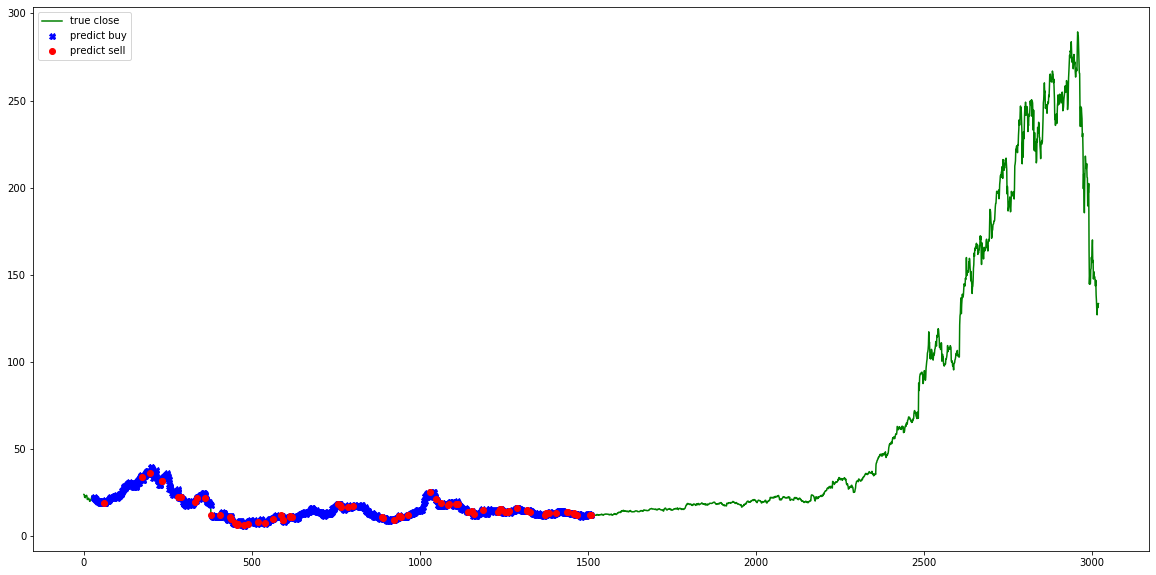

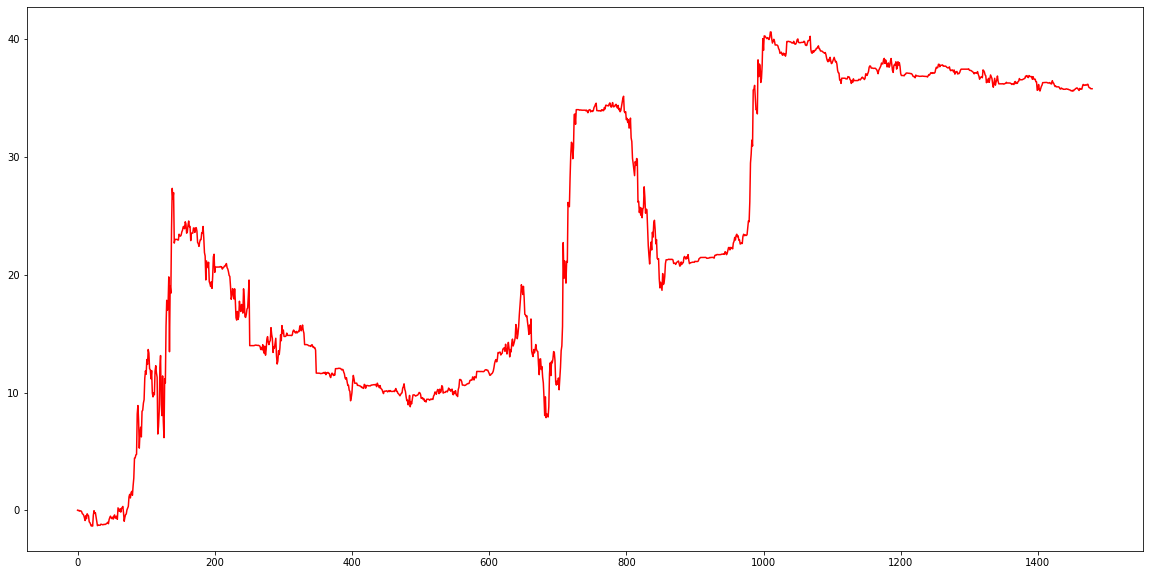


total gained 109559.504560, total investment 109.559505 %


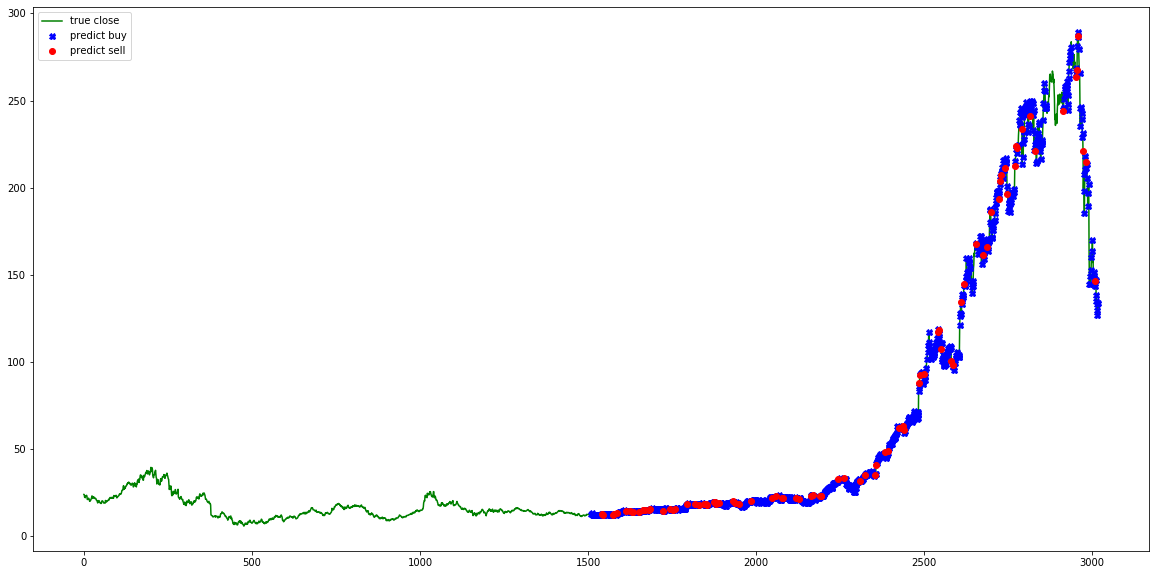

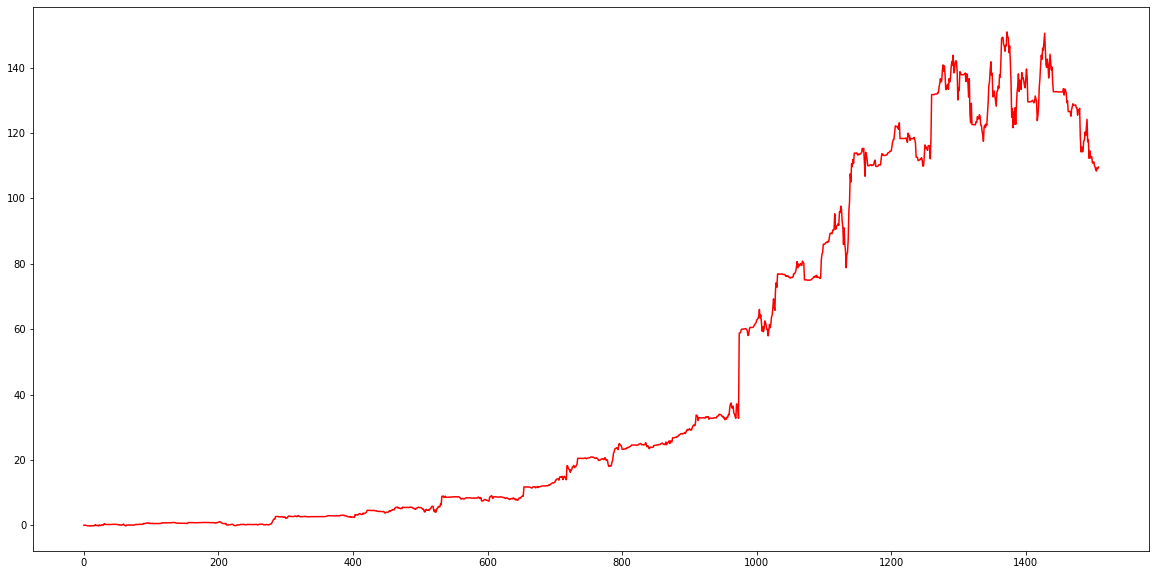

0.45125
0.45125
0.45125
0.45125
0.45125
iter 140. reward: 20.025888

total gained 21678.424906, total investment 21.678425 %


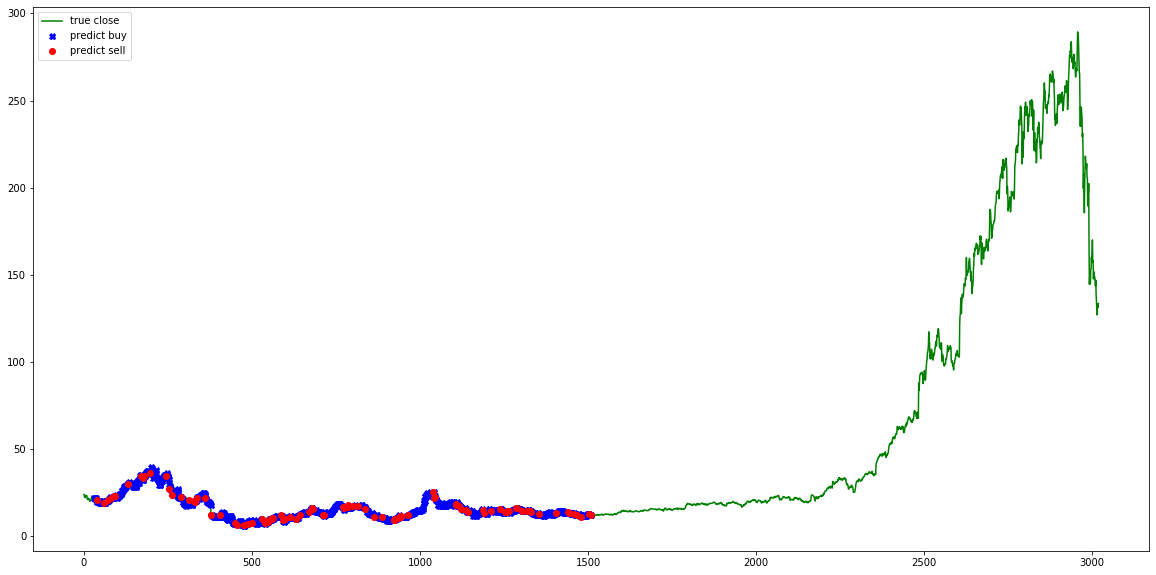

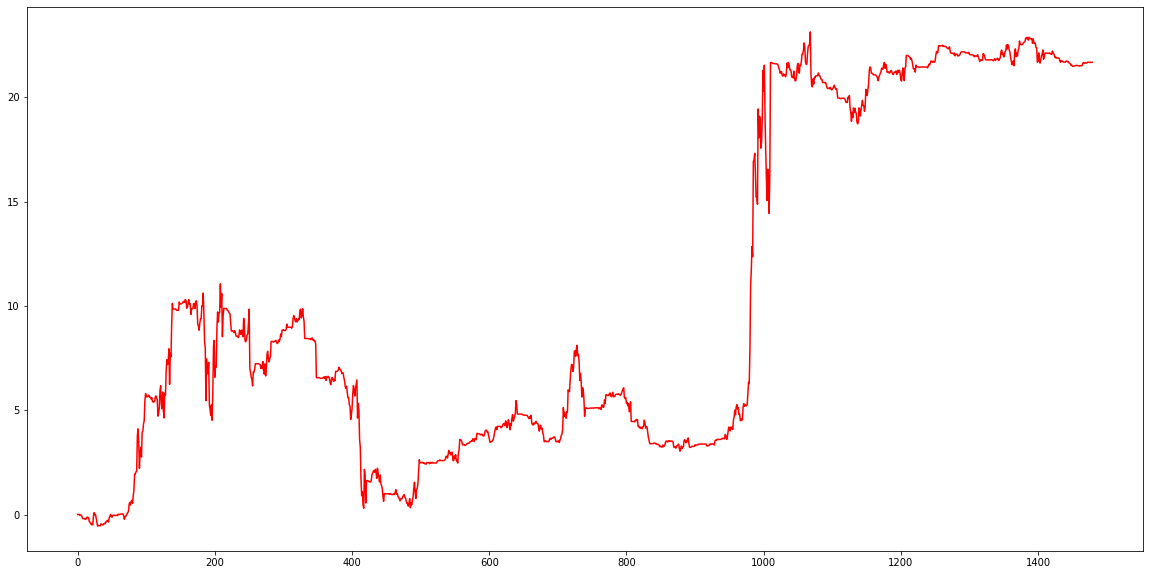


total gained 18447.124270, total investment 18.447124 %


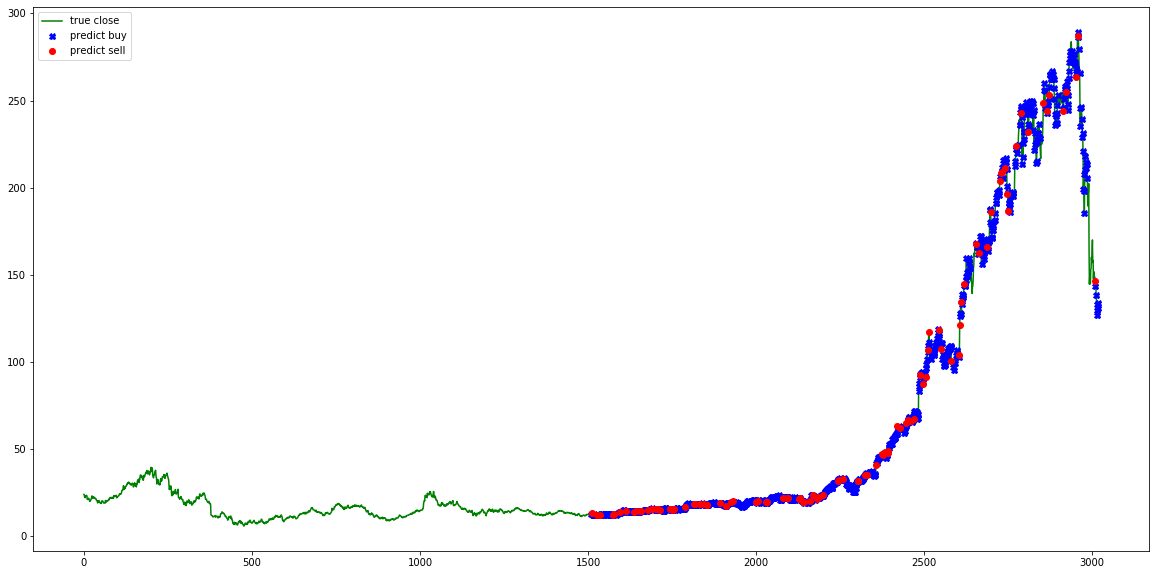

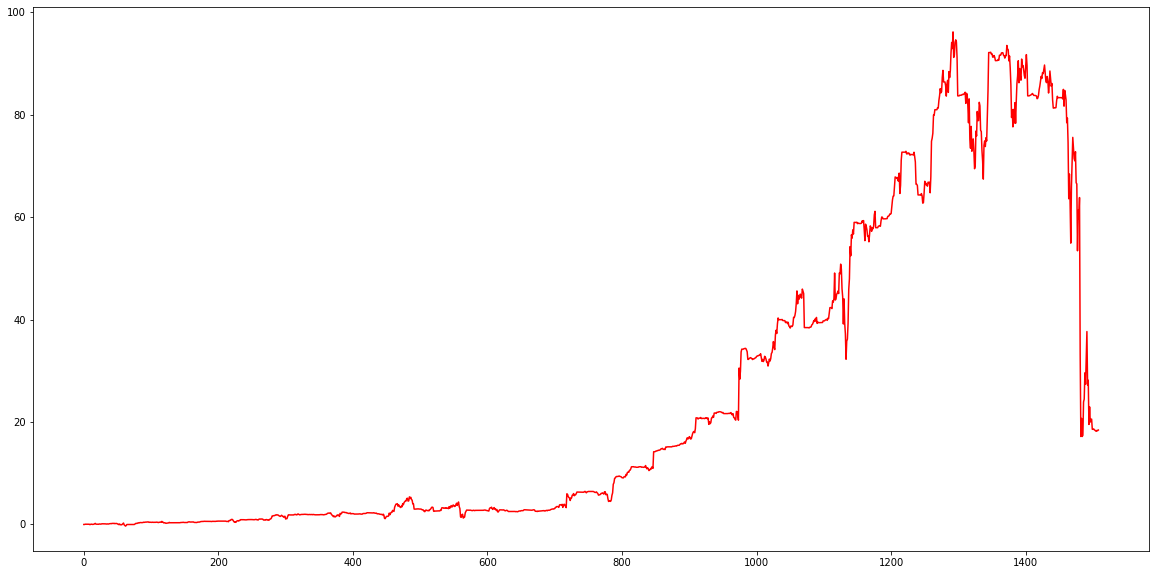

0.45125
0.45125
0.42868749999999994
0.45012187499999995
0.42761578124999994
iter 145. reward: 22.942922

total gained 26589.255463, total investment 26.589255 %


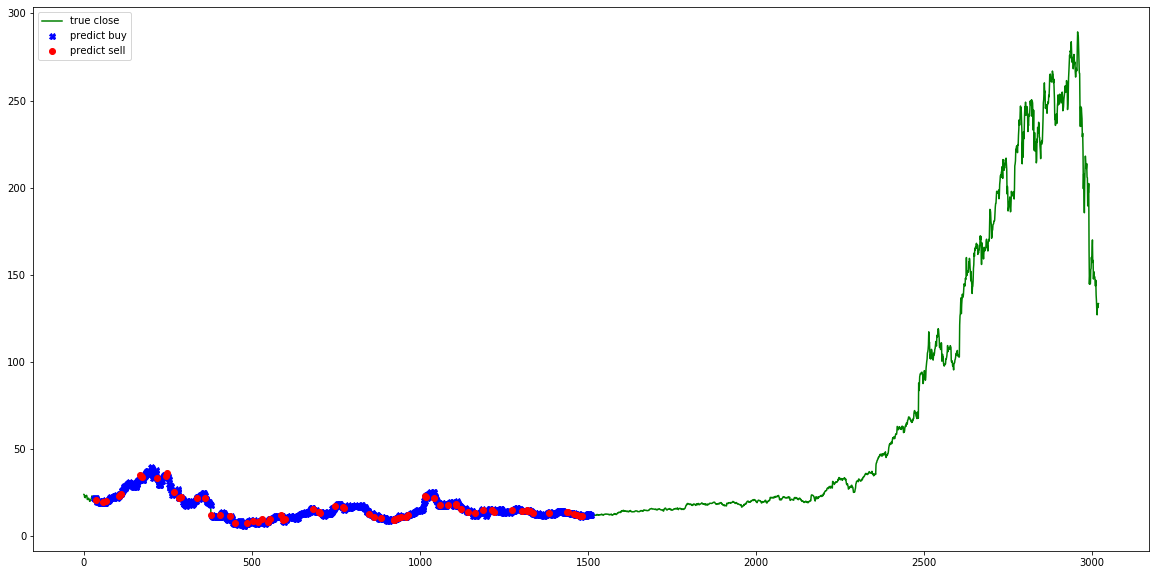

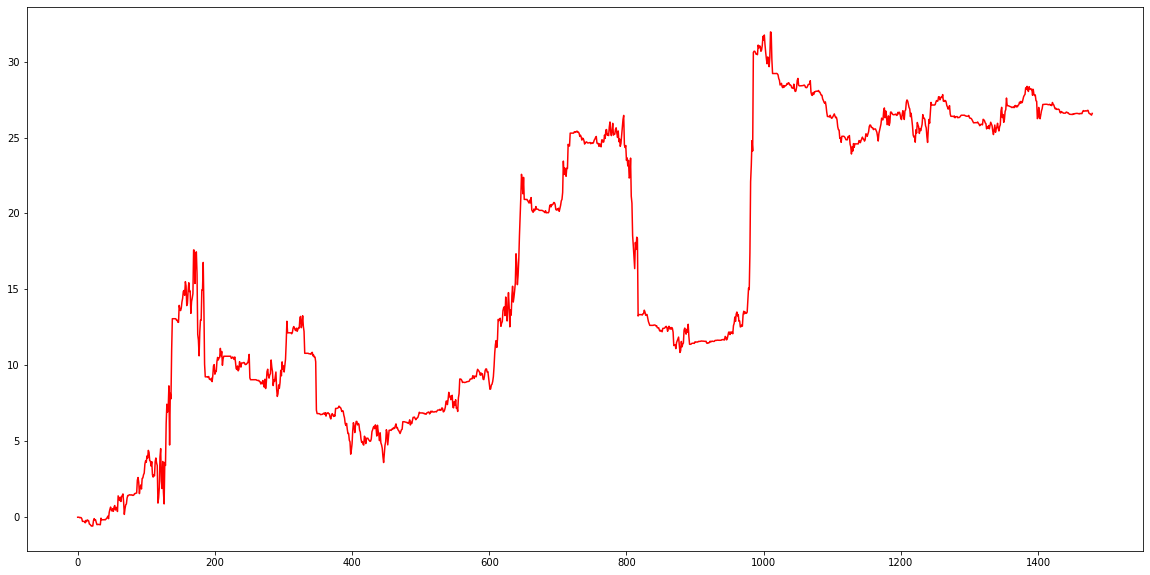


total gained 22848.557650, total investment 22.848558 %


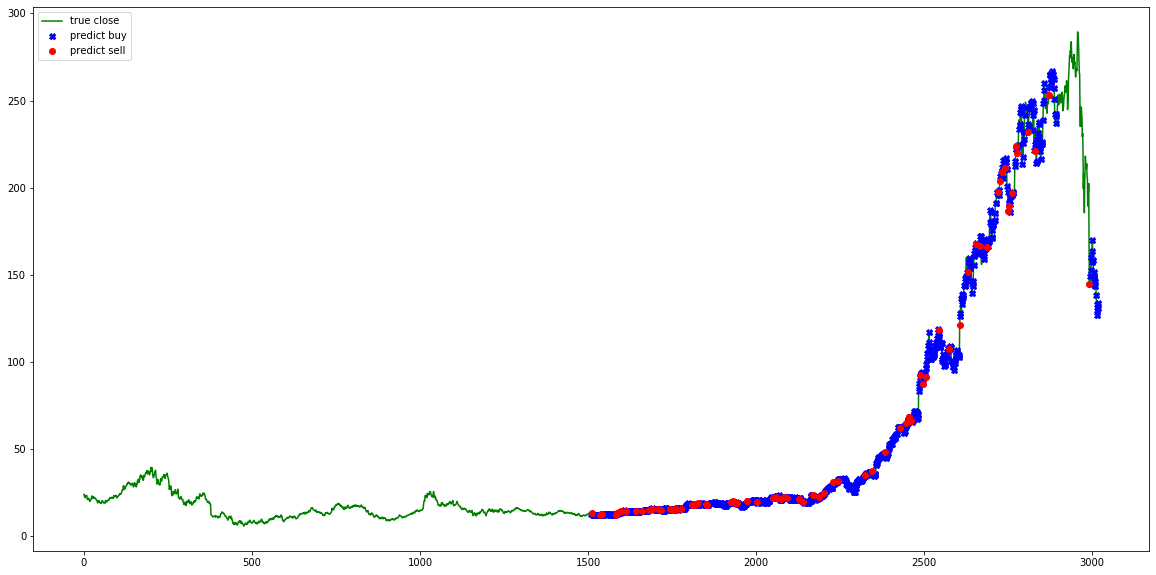

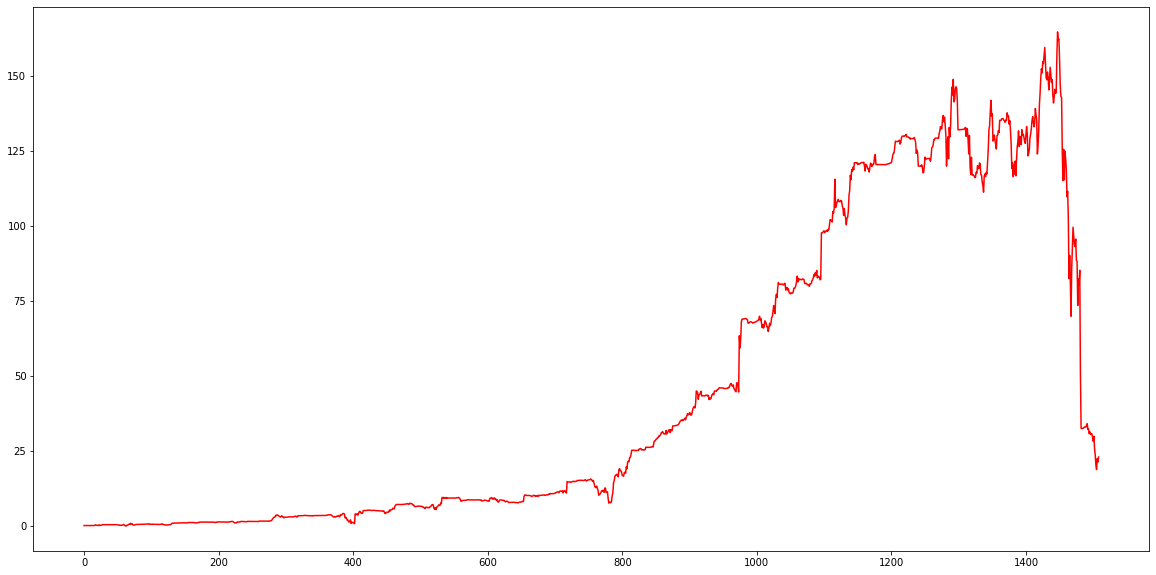

0.4062349921874999
0.4062349921874999
0.4062349921874999
0.3859232425781249


In [0]:
model = Model(input_size = 30*3, 
              layer_size = 500, 
              output_size = 3)
agent = Agent(population_size = 15, 
              sigma = 0.5, 
              learning_rate = 0.5, 
              model = model, 
              money = 100000,  
              skip = 1, 
              window_size = 30)
agent.fit(500, 5)

In [0]:
model = Model(input_size = int(np.around(NN_BAYESIAN.max['params']['window_size']))*4, 
              layer_size = int(np.around(NN_BAYESIAN.max['params']['size_network'])), 
              output_size = 3)
agent = Agent(population_size = int(np.around(NN_BAYESIAN.max['params']['population_size'])), 
              sigma = NN_BAYESIAN.max['params']['sigma'], 
              learning_rate = NN_BAYESIAN.max['params']['learning_rate'], 
              model = model, 
              money = 100000, 
              skip = int(np.around(NN_BAYESIAN.max['params']['skip'])), 
              window_size = int(np.around(NN_BAYESIAN.max['params']['window_size'])))
agent.fit(500, 100)